# Figures

```
snakemake -p -s ~/work/chipseq-smk-pipeline/Snakefile all --cores all  --use-conda  --directory $(pwd) --config genome=hg38 fastq_dir=$(pwd) start_with_bams=True bams_dir=bams bamCoverage_params="--ignoreDuplicates" macs2=True --rerun-trigger mtime;
snakemake -p -s ~/work/chipseq-smk-pipeline/Snakefile all --cores all  --use-conda  --directory $(pwd) --config genome=hg38 fastq_dir=$(pwd) start_with_bams=True bams_dir=bams bamCoverage_params="--ignoreDuplicates" macs2=True macs2_mode=broad macs2_params="--broad --broad-cutoff=0.1" macs2_suffix="broad0.1"  --rerun-trigger mtime;
snakemake -p -s ~/work/chipseq-smk-pipeline/Snakefile all --cores all  --use-conda  --directory $(pwd) --config genome=hg38 fastq_dir=$(pwd) start_with_bams=True bams_dir=bams bamCoverage_params="--ignoreDuplicates" span=True sicer=True span_bin=100 span_params="--keep-cache --debug" --rerun-trigger mtime;

```


In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import pandas as pd
import seaborn as sns
from IPython.display import display
from tqdm.auto import tqdm

sns.set_style("whitegrid")
import matplotlib.pyplot as plt
import math
import numpy as np
import os
import re
from itertools import product
import tempfile

sns.set_theme(style="whitegrid")

In [2]:
def bedl(file):
    try:
        tf = pd.read_csv(file, sep='\t', header=None)
        return tf[2] - tf[1]
    except:
        return np.zeros(0)  # Empty file


def lines(file):
    try:
        tf = pd.read_csv(file, sep='\t', header=None)
        return len(tf)
    except:
        return 0  # Empty file


def d(a, b):
    return a / b if b != 0 else 0


def last_col(file):
    try:
        cols = len(pd.read_csv(file, sep='\t', nrows=1, header=None).columns)
        return pd.read_csv(file, sep='\t', header=None, usecols=[cols - 1])[cols - 1]
    except:
        return np.zeros(0)  # Empty file


def sorted_file(file):
    ts = tempfile.mktemp()
    ! cat {file} | sort -k1,1 -k2,2n -k3,3n > {ts}
    return ts

# Load peaks


In [3]:
GSE26320_PATH = os.path.expanduser('~/data/2023_GSE26320')
GSE26320_CELLS = ['GM12878', 'HMEC', 'HSMM', 'K562', 'NHEK', 'NHLF', 'H1', 'Huvec', 'HepG2']
MODIFICATIONS = ['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3']
GSE26320_REPS = ['rep1', 'rep2']

IMMUNE_PATH = os.path.expanduser('~/data/2023_Immune')
IMMUNE_CELLS = ['CD4ABT', 'TCellBB', 'BCell', 'TCell', 'Monocyte', 'PBMC', 'NK', 'CD34', 'CD4', ]  ## Longest first
IMMUNE_REPS = ['rep1', 'rep2', 'rep3', '']

ABF_PATH = os.path.expanduser('~/data/2018_chipseq_y20o20')
ABF_MODIFICATIONS = ['k4me3', 'k27ac', 'k4me1', 'k27me3', 'k36me3']
ABF_REPLICATES = [f'OD{i}' for i in range(1, 30)] + [f'YD{i}' for i in range(1, 30)]

! mkdir -p {GSE26320_PATH}/pics
! mkdir -p {IMMUNE_PATH}/pics
! mkdir -p {ABF_PATH}/pics

In [4]:
TOOLS = ['MACS2', 'MACS2 broad', 'SPAN', 'SICER']
palette = plt.cm.get_cmap('tab10')
TOOLS_PALETTE = {t: palette(i) for i, t in enumerate(TOOLS)}

In [5]:
def load_peaks(path, suffix, modifications, cells, replicates):
    df = pd.DataFrame(columns=['file', 'modification', 'cell', 'replicate', 'peaks'],
                      dtype=object)
    for f in tqdm(os.listdir(path)):
        if not f.endswith(suffix):
            continue
        cell = next((c for c in cells if f'{c}_' in f), None)
        mod = next((m for m in modifications if f'{m}_' in f), None)
        rep = next((r for r in replicates if f'{r}_' in f or f'{r}-' in f), None)
        if mod and cell is not None and rep is not None:
            peaks_path = os.path.join(path, f)
            ps = lines(peaks_path)
            df.loc[len(df)] = (peaks_path, mod, cell, rep, ps)
    return df

In [6]:
def load_peaks_path(path, modifications, cells, replicates):
    df_macs2 = load_peaks(os.path.join(path, 'macs2'), '.narrowPeak', modifications, cells, replicates)
    df_macs2['tool'] = 'MACS2'
    print('MACS2', len(df_macs2))

    df_macs2broad = load_peaks(os.path.join(path, 'macs2'), '.broadPeak', modifications, cells, replicates)
    df_macs2broad['tool'] = 'MACS2 broad'
    print('MACS2 broad', len(df_macs2broad))

    df_sicer = load_peaks(os.path.join(path, 'sicer'), 'summary-FDR0.01', modifications, cells, replicates)
    df_sicer['tool'] = 'SICER'
    print('SICER', len(df_sicer))

    df_span = load_peaks(os.path.join(path, 'span'), '.peak', modifications, cells, replicates)
    df_span['tool'] = 'SPAN'
    print('SPAN', len(df_span))

    return pd.concat([df_macs2, df_macs2broad, df_sicer, df_span]).reset_index(drop=True)

In [7]:
df_encode_peaks = load_peaks_path(GSE26320_PATH, MODIFICATIONS, GSE26320_CELLS, GSE26320_REPS)
df_encode_peaks['dataset'] = 'ENCODE'
df_encode_peaks.sample(5)

  0%|          | 0/680 [00:00<?, ?it/s]

MACS2 85


  0%|          | 0/680 [00:00<?, ?it/s]

MACS2 broad 85


  0%|          | 0/85 [00:00<?, ?it/s]

SICER 85


  0%|          | 0/936 [00:00<?, ?it/s]

SPAN 85


file modification     cell  \
108  /home/jetbrains/data/2023_GSE26320/macs2/GSM64...      H3K4me1  GM12878   
86   /home/jetbrains/data/2023_GSE26320/macs2/GSM64...      H3K4me1    Huvec   
88   /home/jetbrains/data/2023_GSE26320/macs2/GSM64...     H3K36me3     NHEK   
121  /home/jetbrains/data/2023_GSE26320/macs2/GSM64...     H3K36me3    HepG2   
285  /home/jetbrains/data/2023_GSE26320/span/GSM646...      H3K27ac       H1   

    replicate  peaks         tool dataset  
108      rep1  55876  MACS2 broad  ENCODE  
86       rep1  82501  MACS2 broad  ENCODE  
88       rep2  66951  MACS2 broad  ENCODE  
121      rep1  54590  MACS2 broad  ENCODE  
285      rep1  30885         SPAN  ENCODE

In [8]:
df_immune_peaks = load_peaks_path(IMMUNE_PATH, MODIFICATIONS, IMMUNE_CELLS, IMMUNE_REPS)
df_immune_peaks['dataset'] = 'Roadmap'
df_immune_peaks.sample(5)

  0%|          | 0/368 [00:00<?, ?it/s]

MACS2 46


  0%|          | 0/368 [00:00<?, ?it/s]

MACS2 broad 46


  0%|          | 0/47 [00:00<?, ?it/s]

SICER 46


  0%|          | 0/508 [00:00<?, ?it/s]

SPAN 46


file modification      cell  \
11   /home/jetbrains/data/2023_Immune/macs2/Monocyt...      H3K4me3  Monocyte   
147  /home/jetbrains/data/2023_Immune/span/CD34_H3K...      H3K4me1      CD34   
52   /home/jetbrains/data/2023_Immune/macs2/Monocyt...      H3K4me3  Monocyte   
121  /home/jetbrains/data/2023_Immune/sicer/CD34_H3...      H3K27ac      CD34   
88   /home/jetbrains/data/2023_Immune/macs2/TCell_H...      H3K4me1     TCell   

    replicate   peaks         tool  dataset  
11              26555        MACS2  Roadmap  
147      rep2  102680         SPAN  Roadmap  
52              24096  MACS2 broad  Roadmap  
121      rep2   21276        SICER  Roadmap  
88             145437  MACS2 broad  Roadmap

In [9]:
def update_abf_modifications(df):
    df.loc[df['modification'] == 'k4me3', 'modification'] = 'H3K4me3'
    df.loc[df['modification'] == 'k27ac', 'modification'] = 'H3K27ac'
    df.loc[df['modification'] == 'k4me1', 'modification'] = 'H3K4me1'
    df.loc[df['modification'] == 'k27me3', 'modification'] = 'H3K27me3'
    df.loc[df['modification'] == 'k36me3', 'modification'] = 'H3K36me3'

In [10]:
df_abf_peaks_all = load_peaks_path(ABF_PATH, ABF_MODIFICATIONS, [''], ABF_REPLICATES)
update_abf_modifications(df_abf_peaks_all)
df_abf_peaks_all['dataset'] = 'ABF'
# Drop outliers
ABF_OUTLIERS = {'k27ac': ['YD1', 'YD6'],
                'k27me3': ['OD9', 'YD1', 'YD2', 'YD3', 'YD4', 'YD9', 'YD10', 'YD11'],
                'k36me3': ['OD3', 'OD6', 'OD12', 'OD18', 'OD20', 'YD1', 'YD3', 'YD4', 'YD5'],
                'k4me3': ['OD6', 'OD7', 'OD14', 'YD2', 'YD3', 'YD10', 'YD14']}
t_outliers = [any(f'{o}_h3{m}'.lower() in f.lower() or f'{o}_{m}'.lower() in f.lower()
                  for m, ol in ABF_OUTLIERS.items() for o in ol)
              for f in df_abf_peaks_all['file']]
print('Total outliers', sum(t_outliers))
df_abf_peaks = df_abf_peaks_all[[not to for to in t_outliers]]

df_abf_peaks.sample(5)

  0%|          | 0/1528 [00:00<?, ?it/s]

MACS2 191


  0%|          | 0/1528 [00:00<?, ?it/s]

MACS2 broad 191


  0%|          | 0/191 [00:00<?, ?it/s]

SICER 191


  0%|          | 0/2824 [00:00<?, ?it/s]

SPAN 336
Total outliers 84


file modification cell  \
809  /home/jetbrains/data/2018_chipseq_y20o20/span/...      H3K4me3        
92   /home/jetbrains/data/2018_chipseq_y20o20/macs2...     H3K27me3        
624  /home/jetbrains/data/2018_chipseq_y20o20/span/...     H3K27me3        
559  /home/jetbrains/data/2018_chipseq_y20o20/sicer...      H3K4me3        
595  /home/jetbrains/data/2018_chipseq_y20o20/span/...      H3K27ac        

    replicate  peaks   tool dataset  
809      OD17  11780   SPAN     ABF  
92        YD8  73212  MACS2     ABF  
624      OD18  16492   SPAN     ABF  
559      YD19  26121  SICER     ABF  
595      YD10  48343   SPAN     ABF

In [11]:
df_peaks_full = pd.concat([df_encode_peaks, df_immune_peaks, df_abf_peaks]).reset_index(drop=True)

/tmp/ipykernel_2342681/2431253503.py:6: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 2}` instead.

  sns.barplot(data=df_peaks_full[df_peaks_full['modification'] == m], x='tool', y='peaks', hue='dataset',
/tmp/ipykernel_2342681/2431253503.py:6: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 2}` instead.

  sns.barplot(data=df_peaks_full[df_peaks_full['modification'] == m], x='tool', y='peaks', hue='dataset',
/tmp/ipykernel_2342681/2431253503.py:6: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 2}` instead.

  sns.barplot(data=df_peaks_full[df_peaks_full['modification'] == m], x='tool', y='peaks', hue='dataset',
/tmp/ipykernel_2342681/2431253503.py:6: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 2}` instead.

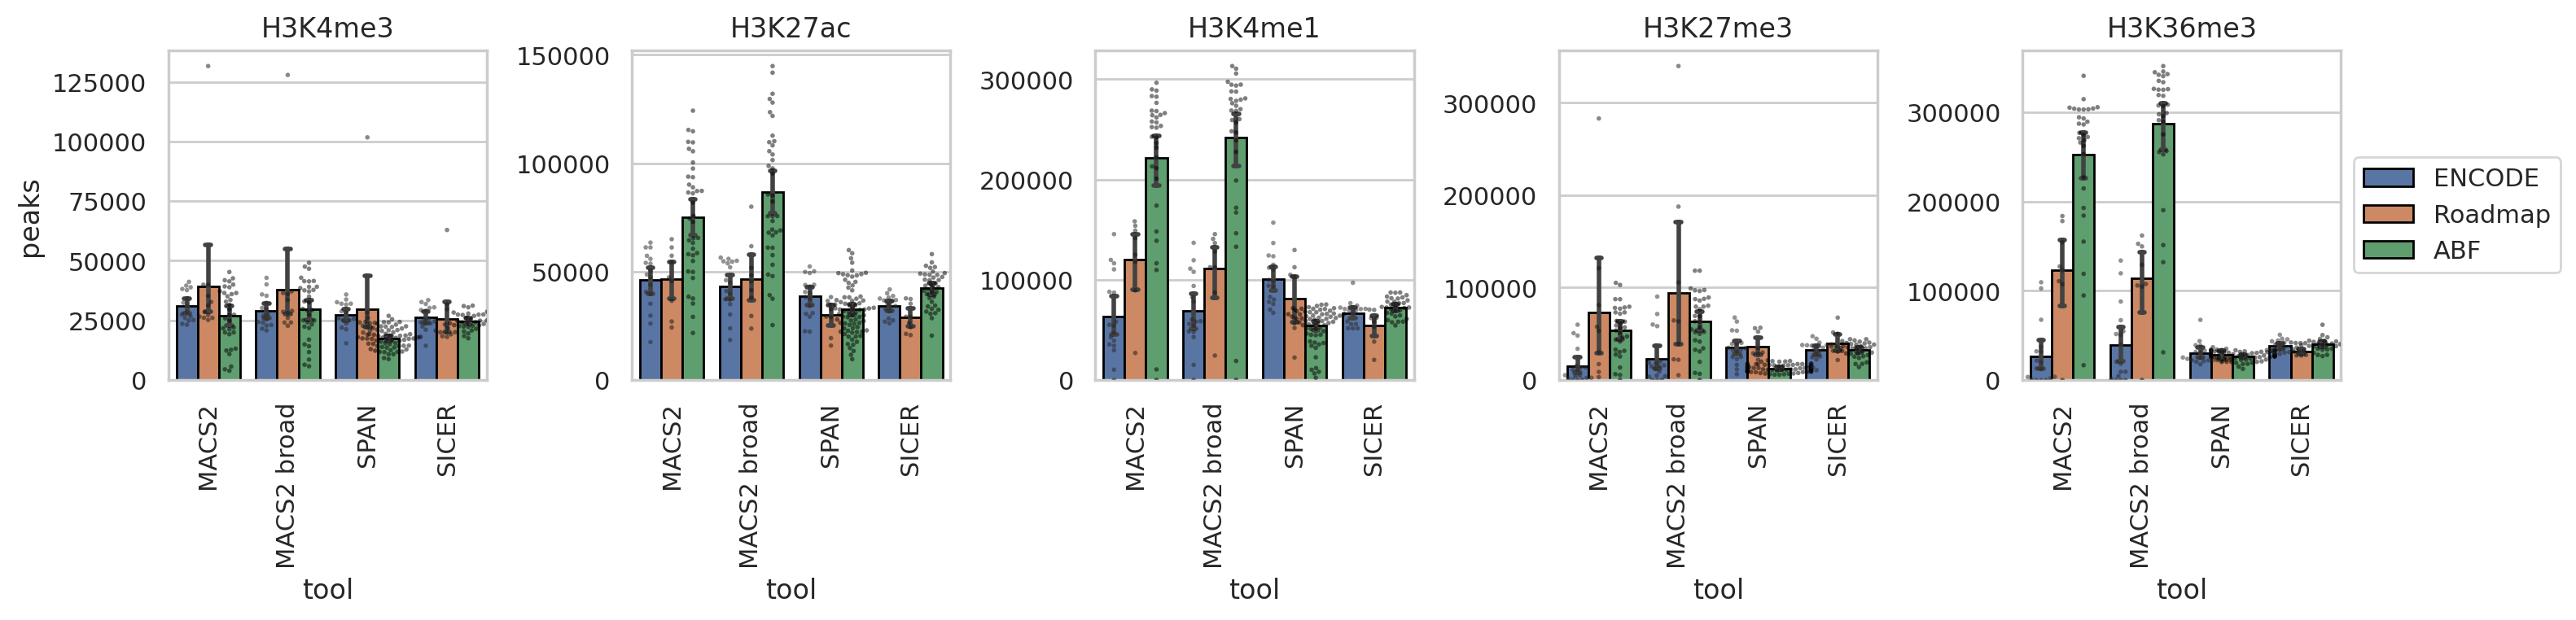

In [12]:
sns.set_style('whitegrid')
plt.figure(figsize=(16, 4))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, m in enumerate(MODIFICATIONS):
    ax = axs[i]
    sns.barplot(data=df_peaks_full[df_peaks_full['modification'] == m], x='tool', y='peaks', hue='dataset',
                capsize=.2, errwidth=2, edgecolor="black",
                # palette=TOOLS_PALETTE,
                order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                hue_order=['ENCODE', 'Roadmap', 'ABF'],
                ax=ax)
    sns.swarmplot(data=df_peaks_full[df_peaks_full['modification'] == m], x='tool', y='peaks', hue='dataset',
                  dodge=True, size=2, palette='dark:black', alpha=0.5, legend=False,
                  order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                  hue_order=['ENCODE', 'Roadmap', 'ABF'],
                  ax=ax)
    ax.xaxis.set_tick_params(rotation=90)
    ax.title.set_text(m)
    if i > 0:
        ax.set_ylabel(None)
    else:
        ax.set_ylabel('peaks')
    if i < 4:
        ax.legend().set_visible(False)
    else:
        # Put a legend to the right of the current axis
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    # ax.set_ylim(0, 1.9e7)
plt.tight_layout()
# plt.savefig(GSE26320_PATH_HG38 + f'/pics/library_mapped_detailed_all.pdf', bbox_inches='tight', dpi=300)
plt.show()

# Outliers

In [13]:
# print('Outliers')
# for m in MODIFICATIONS:
#     print(m)
#     display(df_peaks_full[(df_peaks_full['modification'] == m)].sort_values(by=['peaks'], ascending=False).head(10))
#     display(df_peaks_full[(df_peaks_full['modification'] == m)].sort_values(by=['peaks'], ascending=True).head(10))

In [14]:
# sns.set_style('whitegrid')
# import math
# for m, ds in product(MODIFICATIONS, ['ENCODE', 'Roadmap']):
#     print(m, ds)
#     t = df_peaks_full[(df_peaks_full['dataset'] == ds) & (df_peaks_full['modification'] == m)]
#     experiments = [(c, r) for _, (c, r) in t[['cell', 'replicate']].drop_duplicates().iterrows()]
#     ncols = int(math.floor(math.sqrt(len(experiments)) + 4))
#     nrows = int(math.ceil(len(experiments) / ncols))
#     plt.figure(figsize=(3 * ncols, 3 * nrows))
#     axs = [plt.subplot(nrows, ncols, i + 1) for i in range(len(experiments))]
#     for i, (c, r) in enumerate(experiments):
#         ax = axs[i]
#         ax.title.set_text(f'{ds} {m} {c} {r}')
#         g_results = sns.barplot(data=t[(t['cell'] == c) & (t['replicate']==r)],
#                             x='tool', y='peaks',
#                             ax=ax,
#                             capsize=.2, errwidth=2,
#                             order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER']
#                             )
#         ax.xaxis.set_tick_params(rotation=90)
#         ax.set_ylabel('Number')
#         ax.set_ylim(0, t['peaks'].max() * 1.1)
#     plt.tight_layout()
#     plt.show()

In [15]:
# Remove outliers
OUTLIERS = [
    ('H3K4me3', 'NK', ''),
    ('H3K27me3', 'TCell', ''),
    ('H3K27me3', 'BCell', ''),
]
df_peaks = df_peaks_full.loc[[(m, c, r) not in OUTLIERS
                              for _, (m, c, r) in
                              df_peaks_full[['modification', 'cell', 'replicate']].iterrows()]].copy()

/tmp/ipykernel_2342681/1343899304.py:6: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 2}` instead.

  sns.barplot(data=df_peaks[df_peaks['modification'] == m], x='tool', y='peaks', hue='dataset',
/tmp/ipykernel_2342681/1343899304.py:6: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 2}` instead.

  sns.barplot(data=df_peaks[df_peaks['modification'] == m], x='tool', y='peaks', hue='dataset',
/tmp/ipykernel_2342681/1343899304.py:6: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 2}` instead.

  sns.barplot(data=df_peaks[df_peaks['modification'] == m], x='tool', y='peaks', hue='dataset',
/tmp/ipykernel_2342681/1343899304.py:6: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 2}` instead.

  sns.barplot(data=df_peaks[

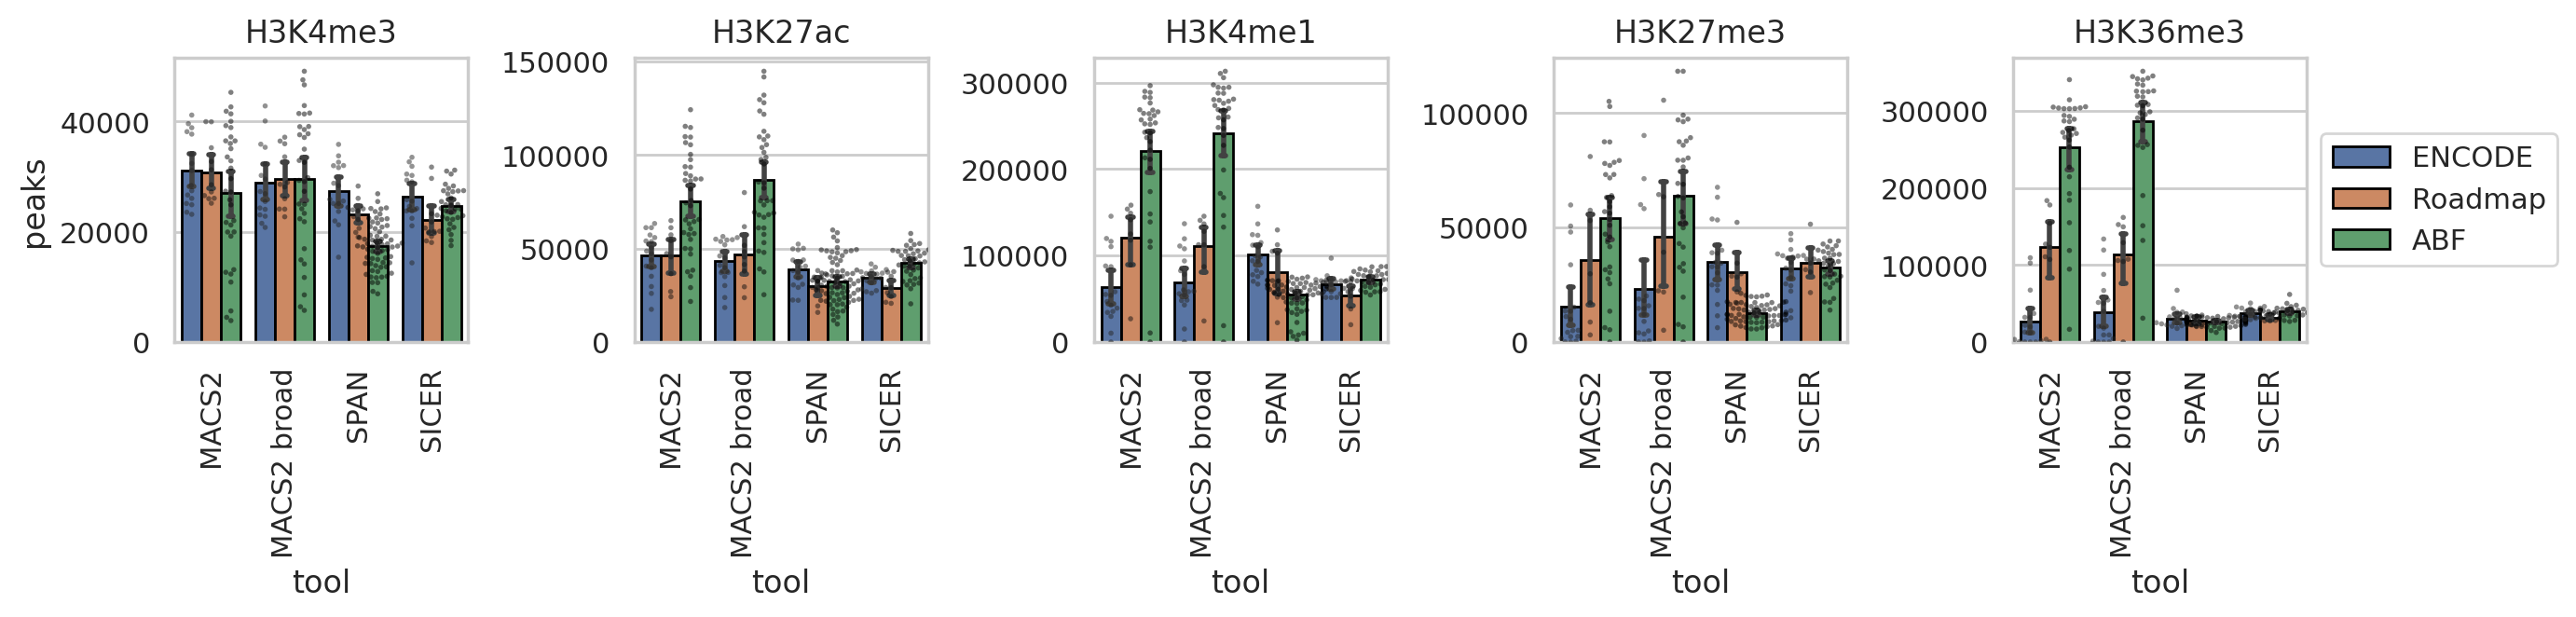

In [16]:
sns.set_style('whitegrid')
plt.figure(figsize=(14, 3.5))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, m in enumerate(MODIFICATIONS):
    ax = axs[i]
    sns.barplot(data=df_peaks[df_peaks['modification'] == m], x='tool', y='peaks', hue='dataset',
                capsize=.2, errwidth=2, edgecolor="black",
                # palette=TOOLS_PALETTE,
                order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                hue_order=['ENCODE', 'Roadmap', 'ABF'],
                ax=ax)
    sns.swarmplot(data=df_peaks[df_peaks['modification'] == m], x='tool', y='peaks', hue='dataset',
                  dodge=True, size=2, palette='dark:black', alpha=0.5,
                  order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                  hue_order=['ENCODE', 'Roadmap', 'ABF'], legend=False,
                  ax=ax)
    ax.xaxis.set_tick_params(rotation=90)
    ax.title.set_text(m)
    if i > 0:
        ax.set_ylabel(None)
    else:
        ax.set_ylabel('peaks')
    if i < len(axs) - 1:
        ax.legend().set_visible(False)
    else:
        # Put a legend to the right of the current axis
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    # ax.set_ylim(0, 1.9e7)
plt.tight_layout()
# plt.savefig(GSE26320_PATH_HG38 + f'/pics/library_mapped_detailed_all.pdf', bbox_inches='tight', dpi=300)
plt.show()

In [17]:
# df_peaks[(df_peaks['modification'] == 'H3K4me1') &
#          (df_peaks['dataset'] != 'ENCODE') &
#          (df_peaks['tool'] != 'SPANa')].sort_values(by=['peaks'], ascending=True)

/tmp/ipykernel_2342681/1480088690.py:5: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 2}` instead.

  sns.barplot(data=df_peaks[df_peaks['modification'] == m], x='tool', y='peaks', hue='dataset',
/tmp/ipykernel_2342681/1480088690.py:5: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 2}` instead.

  sns.barplot(data=df_peaks[df_peaks['modification'] == m], x='tool', y='peaks', hue='dataset',
/tmp/ipykernel_2342681/1480088690.py:5: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 2}` instead.

  sns.barplot(data=df_peaks[df_peaks['modification'] == m], x='tool', y='peaks', hue='dataset',
/tmp/ipykernel_2342681/1480088690.py:5: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 2}` instead.

  sns.barplot(data=df_peaks[

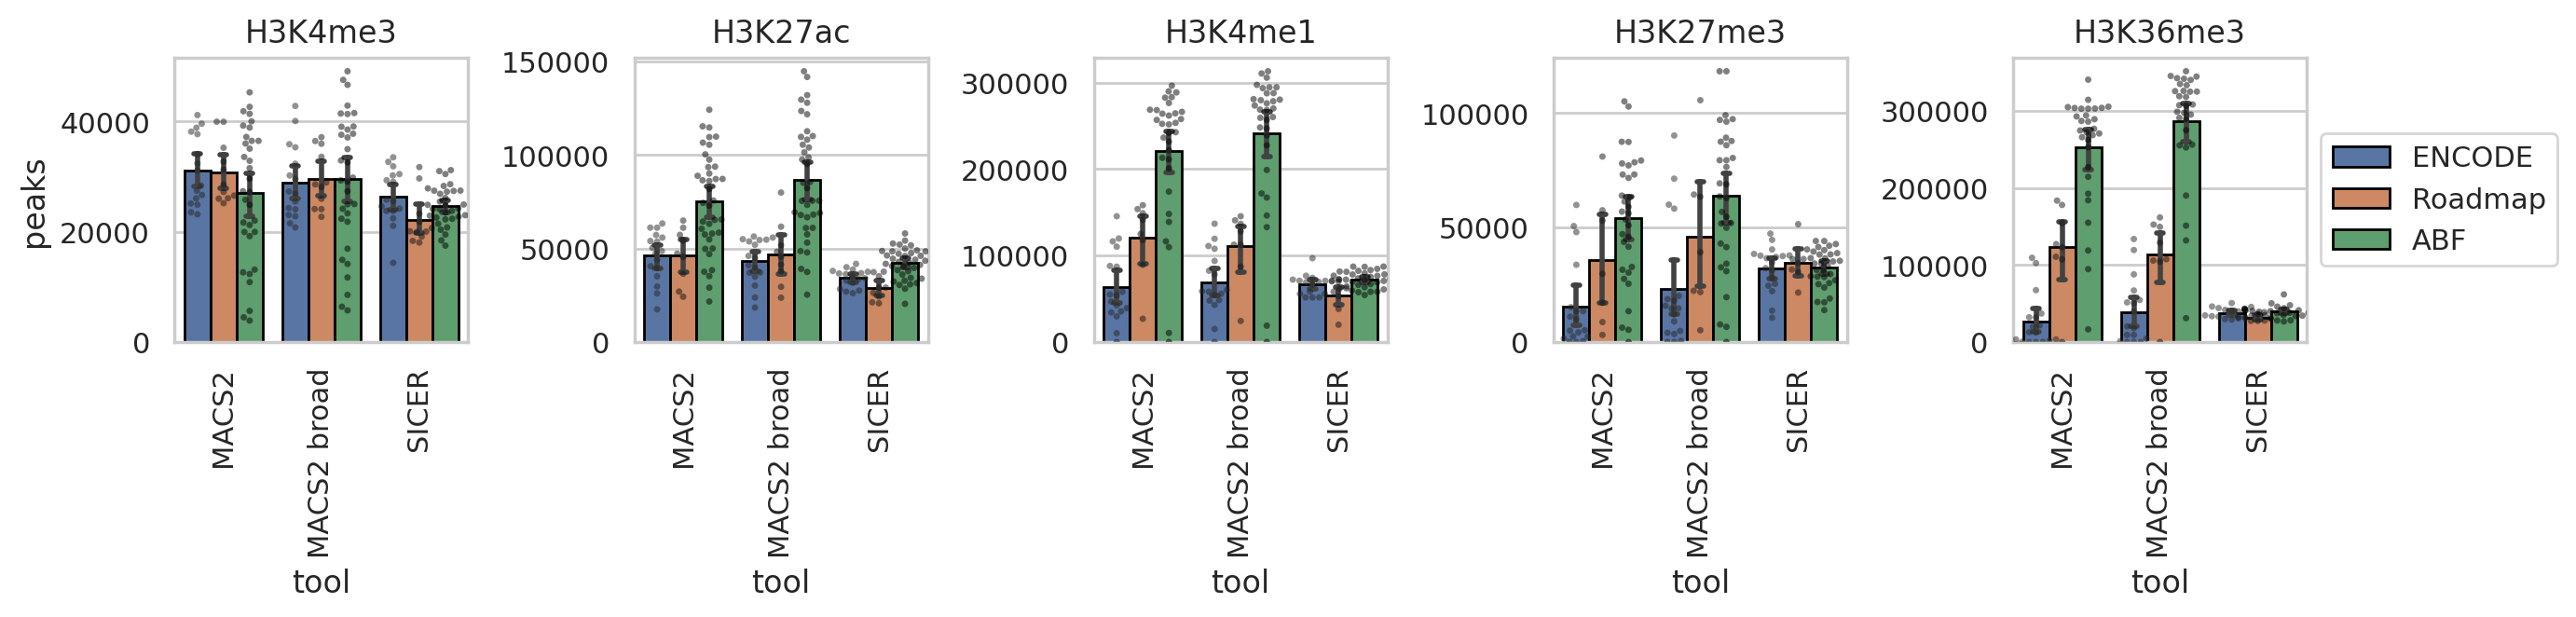

In [18]:
plt.figure(figsize=(14, 3.5))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, m in enumerate(MODIFICATIONS):
    ax = axs[i]
    sns.barplot(data=df_peaks[df_peaks['modification'] == m], x='tool', y='peaks', hue='dataset',
                capsize=.2, errwidth=2, edgecolor="black",
                # palette=TOOLS_PALETTE,
                order=['MACS2', 'MACS2 broad', 'SICER'],
                hue_order=['ENCODE', 'Roadmap', 'ABF'],
                ax=ax)
    sns.swarmplot(data=df_peaks[df_peaks['modification'] == m], x='tool', y='peaks', hue='dataset',
                  dodge=True, size=2.5, palette='dark:black', alpha=0.5, legend=False,
                  order=['MACS2', 'MACS2 broad', 'SICER'],
                  hue_order=['ENCODE', 'Roadmap', 'ABF'],
                  ax=ax)
    ax.xaxis.set_tick_params(rotation=90)
    ax.title.set_text(m)
    if i > 0:
        ax.set_ylabel(None)
    else:
        ax.set_ylabel('peaks')
    if i < len(axs) - 1:
        ax.legend().set_visible(False)
    else:
        # Put a legend to the right of the current axis
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    # ax.set_ylim(0, 1.9e7)
plt.tight_layout()
# plt.savefig(GSE26320_PATH_HG38 + f'/pics/library_mapped_detailed_all.pdf', bbox_inches='tight', dpi=300)
plt.show()

# 3 groups MACS2 broad H3K4me1

In [18]:
df_peaks['ds_c_r'] = df_peaks['dataset'] + ' ' + df_peaks['cell'] + ' ' + df_peaks['replicate']
print('H3K4me1 MACS2 broad ENCODE < 60k peaks')
g1 = df_peaks[(df_peaks['modification'] == 'H3K4me1') &
              (df_peaks['dataset'] == 'ENCODE') &
              (df_peaks['tool'] == 'MACS2 broad') &
              (df_peaks['peaks'] < 60_000)].copy()

print('H3K4me1 MACS2 broad ENCODE > 80k peaks')
g2 = df_peaks[(df_peaks['modification'] == 'H3K4me1') &
              (df_peaks['dataset'] == 'ENCODE') &
              (df_peaks['tool'] == 'MACS2 broad') &
              (df_peaks['peaks'] > 80_000)].copy()

g1_ds_c_r = set(g1['ds_c_r'])
g2_ds_c_r = set(g2['ds_c_r'])

H3K4me1 MACS2 broad ENCODE < 60k peaks
H3K4me1 MACS2 broad ENCODE > 80k peaks


Peaks


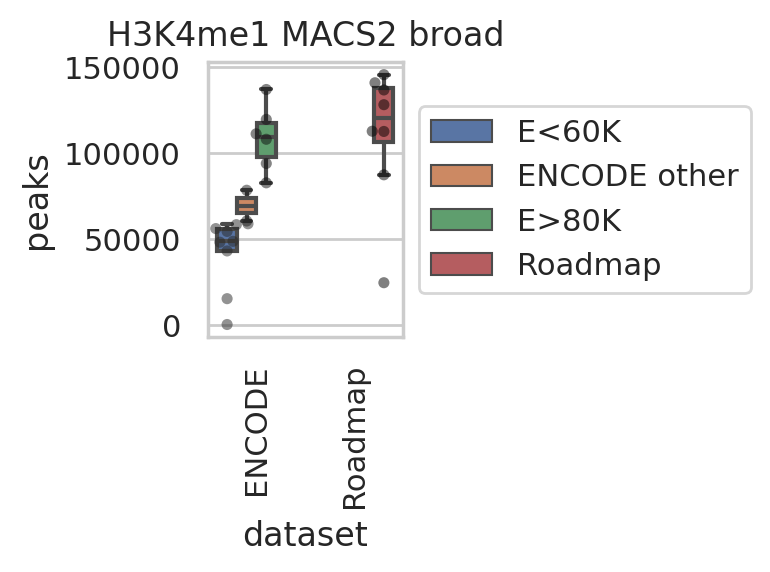

In [19]:
print('Peaks')
plt.figure(figsize=(4, 3))
ax = plt.axes()
t = df_peaks[(df_peaks['modification'] == 'H3K4me1') & (df_peaks['tool'] == 'MACS2 broad')]
sns.boxplot(data=t, x='dataset', y='peaks',
            hue=['E<60K' if dscr in g1_ds_c_r else 'E>80K' if dscr in g2_ds_c_r else
            'ENCODE other' if 'ENCODE' in dscr else 'Roadmap' for dscr in t['ds_c_r']],
            hue_order=['E<60K', 'ENCODE other', 'E>80K', 'Roadmap'],
            showfliers=False,
            ax=ax)
sns.swarmplot(data=t, x='dataset', y='peaks',
              hue=['E<60K' if dscr in g1_ds_c_r else 'E>80K' if dscr in g2_ds_c_r else
              'ENCODE other' if 'ENCODE' in dscr else 'Roadmap' for dscr in t['ds_c_r']],
              hue_order=['E<60K', 'ENCODE other', 'E>80K', 'Roadmap'],
              dodge=True, size=4, palette='dark:black', alpha=0.5, legend=False,
              ax=ax)

sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
ax.title.set_text('H3K4me1 MACS2 broad')
ax.xaxis.set_tick_params(rotation=90)

plt.tight_layout()
plt.show()

# Lengths

In [19]:
print('Load lengths')
ts = []
for dataset, mod, cell, rep, file, tool in tqdm(zip(
        df_peaks['dataset'], df_peaks['modification'], df_peaks['cell'], df_peaks['replicate'], df_peaks['file'],
        df_peaks['tool']
)):
    lengths = bedl(file)
    t = pd.DataFrame(dict(length=lengths))
    t = t.sample(min(len(t), 10_000)).copy()
    t['dataset'] = dataset
    t['modification'] = mod
    t['cell'] = cell
    t['replicate'] = rep
    t['tool'] = tool
    t['footprint'] = sum(lengths)
    ts.append(t)
df_lens = pd.concat(ts).reset_index(drop=True)
del ts, t
df_lens.sample(10)

Load lengths


0it [00:00, ?it/s]

length  dataset modification   cell replicate         tool  \
5682865     248.0      ABF      H3K4me3             OD20        MACS2   
4136637     999.0  Roadmap      H3K4me1  BCell                  SICER   
795570      756.0   ENCODE     H3K36me3   NHLF      rep2  MACS2 broad   
12274315    370.0      ABF      H3K4me3              YD8         SPAN   
11356756    500.0      ABF      H3K4me3             OD18         SPAN   
8648339   14999.0      ABF      H3K4me1              YD8        SICER   
1630070    9199.0   ENCODE      H3K4me1     H1      rep2        SICER   
3970556    2212.0  Roadmap     H3K36me3   CD34            MACS2 broad   
1599851     999.0   ENCODE      H3K4me1  HepG2      rep1        SICER   
11736017   2180.0      ABF     H3K27me3             YD18         SPAN   

          footprint  
5682865    15994067  
4136637   213196724  
795570     87630149  
12274315   33894790  
11356756    9018270  
8648339   340131838  
1630070   242260954  
3970556   243757196  
1599851   216630170  
11736017   24139130

In [20]:
# for ds in ['ENCODE', 'Roadmap']:
#     print(ds)
#     plt.figure(figsize=(18, 3))
#     axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
#     for i, m in enumerate(MODIFICATIONS):
#         ax = axs[i]
#         g_results = sns.histplot(data=df_lens[(df_lens['dataset'] == ds) & (df_lens['modification'] == m)],
#                                  x='length', hue='tool', ax=ax,
#                                  stat='density', common_bins=False, common_norm=False,
#                                  bins=50, kde=True, log_scale=True, alpha=0.2,
#                                  palette=TOOLS_PALETTE,
#                                  hue_order=TOOLS)
#         g_results.set(xscale='log')
#         g_results.set_ylim(0, 3)
#         g_results.set_xlim(1e2, 7e4)
#         ax.title.set_text(m)
#         if i < len(axs) - 1:
#             ax.legend().set_visible(False)
#         else:
#             sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
#     plt.tight_layout()
#     plt.show()


In [21]:
# for m in ['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3']:
#     print(m)
#     plt.figure(figsize=(12, 3))
#     axs = [plt.subplot(1, 3, i + 1) for i in range(3)]
#     for i, tool in enumerate(['MACS2', 'MACS2 broad', 'SICER']):
#         ax = axs[i]
#         g_results = sns.histplot(data=df_lens[(df_lens['modification'] == m) & (df_lens['tool'] == tool)],
#                                  x='length', hue='dataset', ax=ax,
#                                  stat='density', common_bins=False, common_norm=False,
#                                  bins=30, kde=True, log_scale=True, alpha=0.5,
#                                  # palette=TOOLS_PALETTE,
#                                  )
#         g_results.set(xscale='log')
#         g_results.set_ylim(0, 2.5)
#         g_results.set_xlim(200, 5e4)
#         ax.title.set_text(f'{tool}')
#         if i < len(axs) - 1:
#             ax.legend().set_visible(False)
#         else:
#             sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
#     plt.tight_layout()
#     plt.show()
#
# # plt.savefig(f'{GSE26320_PATH_HG38}/pics/H3K27ac_wiggle_mix_lengths.pdf', bbox_inches='tight', dpi=300)

In [22]:
# plt.figure(figsize=(14, 3))
# axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
# for i, m in enumerate(['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3']):
#     print(m)
#     ax = axs[i]
#     g_results = sns.histplot(data=df_lens[(df_lens['modification'] == m) & (df_lens['tool'] == 'SPAN')],
#                              x='length', hue='dataset', ax=ax,
#                              stat='density', common_bins=False, common_norm=False,
#                              bins=30, kde=True, log_scale=True, alpha=0.5,
#                              # palette=TOOLS_PALETTE,
#                              )
#     g_results.set(xscale='log')
#     g_results.set_ylim(0, 1.5)
#     g_results.set_xlim(200, 7e4)
#     ax.title.set_text(m)
#     if i < len(axs) - 1:
#         ax.legend().set_visible(False)
#     else:
#         sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
# plt.tight_layout()
# plt.show()
# 
# # plt.savefig(f'{GSE26320_PATH_HG38}/pics/H3K27ac_wiggle_mix_lengths.pdf', bbox_inches='tight', dpi=300)

H3K4me3
H3K27ac
H3K4me1
H3K27me3
H3K36me3


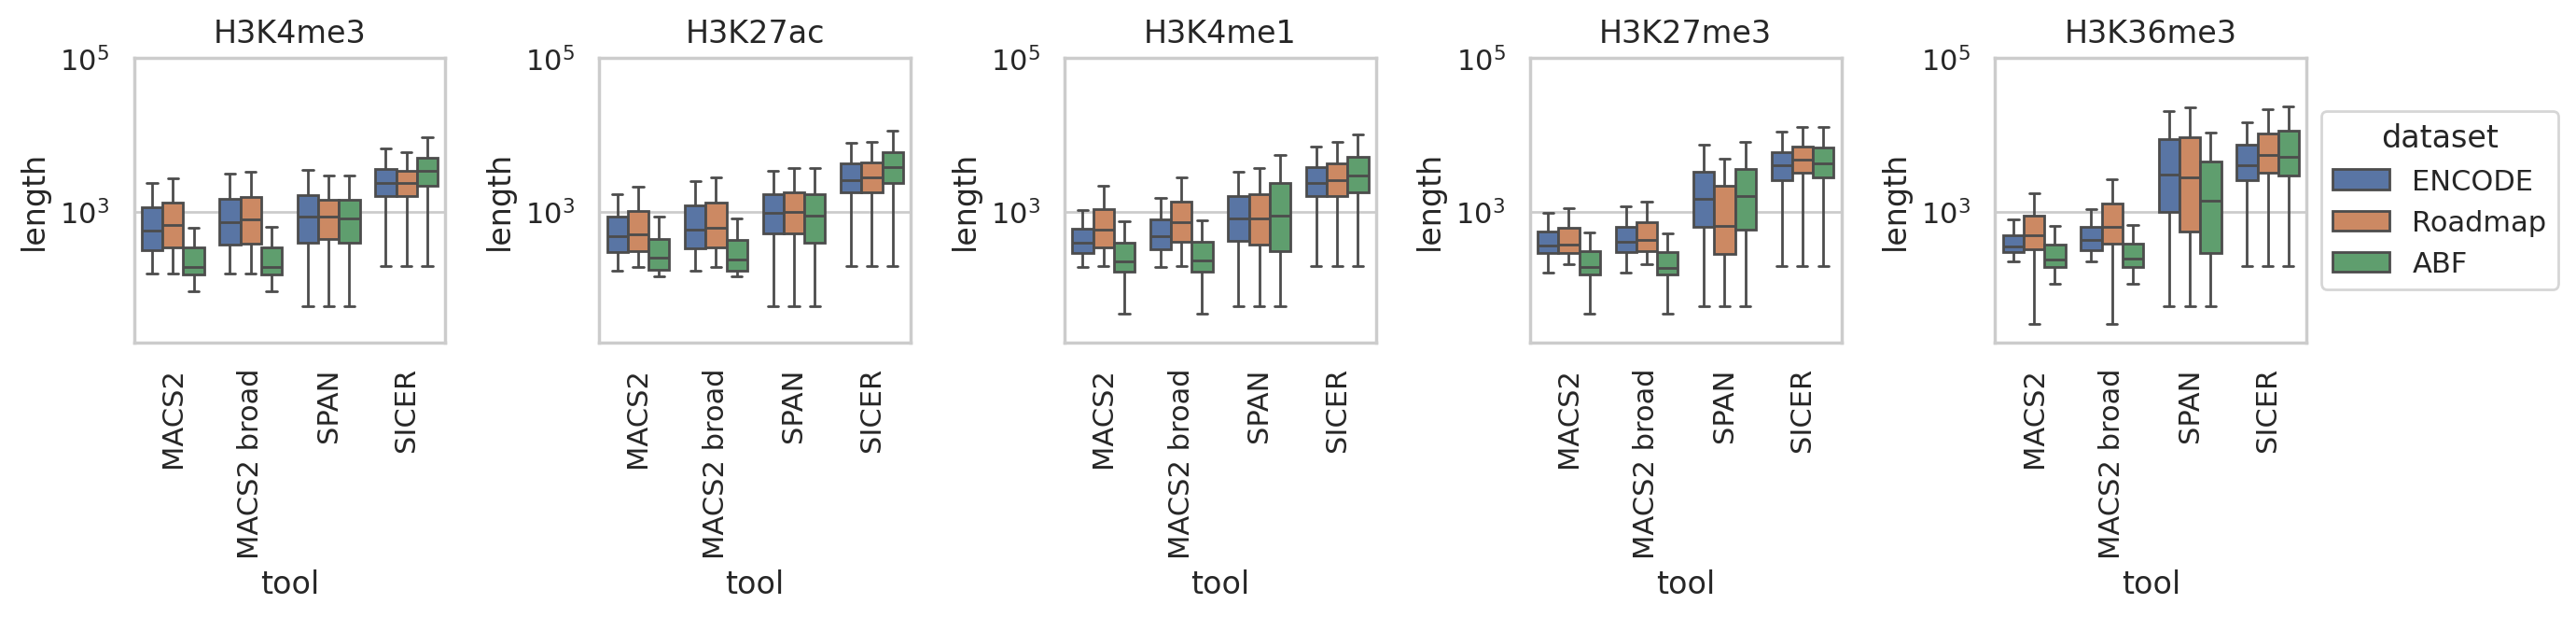

In [23]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(14, 3.5))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, m in enumerate(['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3']):
    print(m)
    ax = axs[i]
    sns.boxplot(data=df_lens[df_lens['modification'] == m], x='tool', y='length', hue='dataset',
                showfliers=False,
                order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                hue_order=['ENCODE', 'Roadmap', 'ABF'],
                ax=ax)
    ax.title.set_text(m)
    # ax.set(yscale='log')

    if i < len(axs) - 1:
        ax.legend().set_visible(False)
    else:
        sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
    if m not in ['H3K36me3']:
        ax.set_ylim(bottom=20, top=1e5)
    else:
        ax.set_ylim(bottom=20, top=1e5)
    ax.set(yscale='log')
    ax.xaxis.set_tick_params(rotation=90)

plt.tight_layout()
plt.show()

H3K4me3
H3K27ac
H3K4me1
H3K27me3
H3K36me3


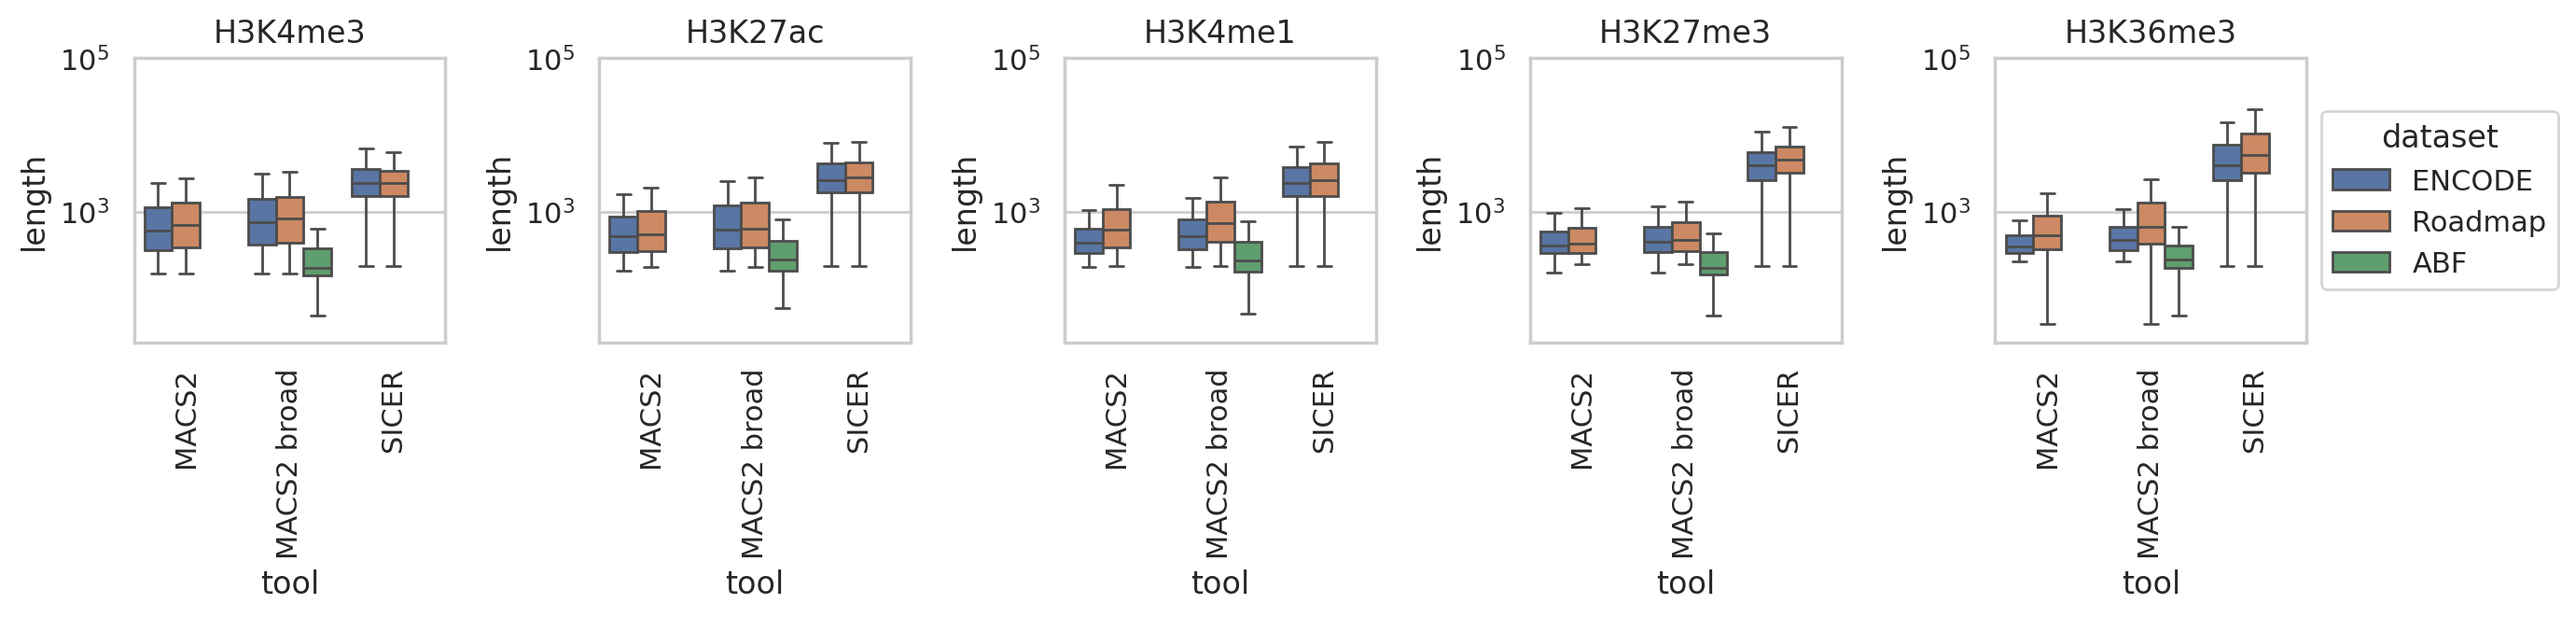

In [46]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(14, 3.5))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, m in enumerate(['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3']):
    print(m)
    ax = axs[i]
    sns.boxplot(data=df_lens[df_lens['modification'] == m], x='tool', y='length', hue='dataset',
                showfliers=False,
                order=['MACS2', 'MACS2 broad', 'SICER'],
                hue_order=['ENCODE', 'Roadmap', 'ABF'],
                ax=ax)
    ax.title.set_text(m)
    # ax.set(yscale='log')

    if i < len(axs) - 1:
        ax.legend().set_visible(False)
    else:
        sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
    if m not in ['H3K36me3']:
        ax.set_ylim(bottom=20, top=1e5)
    else:
        ax.set_ylim(bottom=20, top=1e5)
    ax.set(yscale='log')
    ax.xaxis.set_tick_params(rotation=90)

plt.tight_layout()
plt.show()

In [23]:
# df_lens['cell_rep'] = df_lens['cell'] + ' ' + df_lens['replicate']
#
# for m in MODIFICATIONS:
#     print(m)
#     plt.figure(figsize=(24, 12))
#     t = list(df_lens[df_lens['modification'] == m].groupby(['dataset', 'cell_rep']))
#     plots = len(t)
#     ncols = int(math.ceil(math.sqrt(plots)))
#     nrows = int(math.ceil(plots / ncols))
#     axs = [plt.subplot(nrows, ncols, i + 1) for i in range(plots)]
#
#     for i, ((ds, cellrep), dt) in enumerate(t):
#         ax = axs[i]
#         sns.histplot(data=dt,
#                      x='length', hue='tool',
#                      stat='density', common_bins=False, common_norm=False,
#                      bins=30, kde=True, log_scale=True, alpha=0.5,
#                      palette=TOOLS_PALETTE,
#                      ax=ax)
#
#         ax.set_title(f'{ds} {cellrep}')
#         ax.set(xscale='log')
#         ax.set_ylim(0, 2.5)
#         ax.set_xlim(200, 7e4)
#         if (i + 1) == plots:
#             sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
#         else:
#             ax.legend().set_visible(False)
#         if i % ncols != 0:
#             ax.set_ylabel(None)
#         if i < ncols:
#             # ax.set_xticks([], minor=False)
#             # ax.set_xticklabels([])
#             ax.set_xlabel(None)
#     plt.tight_layout()
#     plt.show()

# Average length

In [55]:
# Keep % of peaks, since outliers may significantly shift results
ts = []
for (ds, m, c, r, tool), dft in df_lens[
    ['dataset', 'modification', 'cell', 'replicate', 'tool', 'length', 'footprint']
].groupby(['dataset', 'modification', 'cell', 'replicate', 'tool']):
    dft.sort_values(by=['length'], inplace=True)
    ts.append(dft.iloc[int(len(dft) * 0.1): int(len(dft) * 0.9)])
    # ts.append(dft)
ts = pd.concat(ts).reset_index(drop=True)
df_lens_avg = ts.groupby(['dataset', 'modification', 'cell', 'replicate', 'tool']).agg('mean').reset_index()
df_lens_avg['ds_c_r'] = df_lens_avg['dataset'] + ' ' + df_lens_avg['cell'] + ' ' + df_lens_avg['replicate']
df_lens_avg.sample(3)

dataset modification      cell replicate         tool       length  \
767  Roadmap     H3K36me3       CD4      rep1        SICER  5605.100000   
674   ENCODE      H3K4me3      NHEK      rep1  MACS2 broad   809.149375   
738  Roadmap     H3K27me3  Monocyte            MACS2 broad   739.595625   

       footprint             ds_c_r  
767  178479333.0   Roadmap CD4 rep1  
674   41899282.0   ENCODE NHEK rep1  
738   73399321.0  Roadmap Monocyte

H3K4me3
H3K27ac
H3K4me1
H3K27me3
H3K36me3


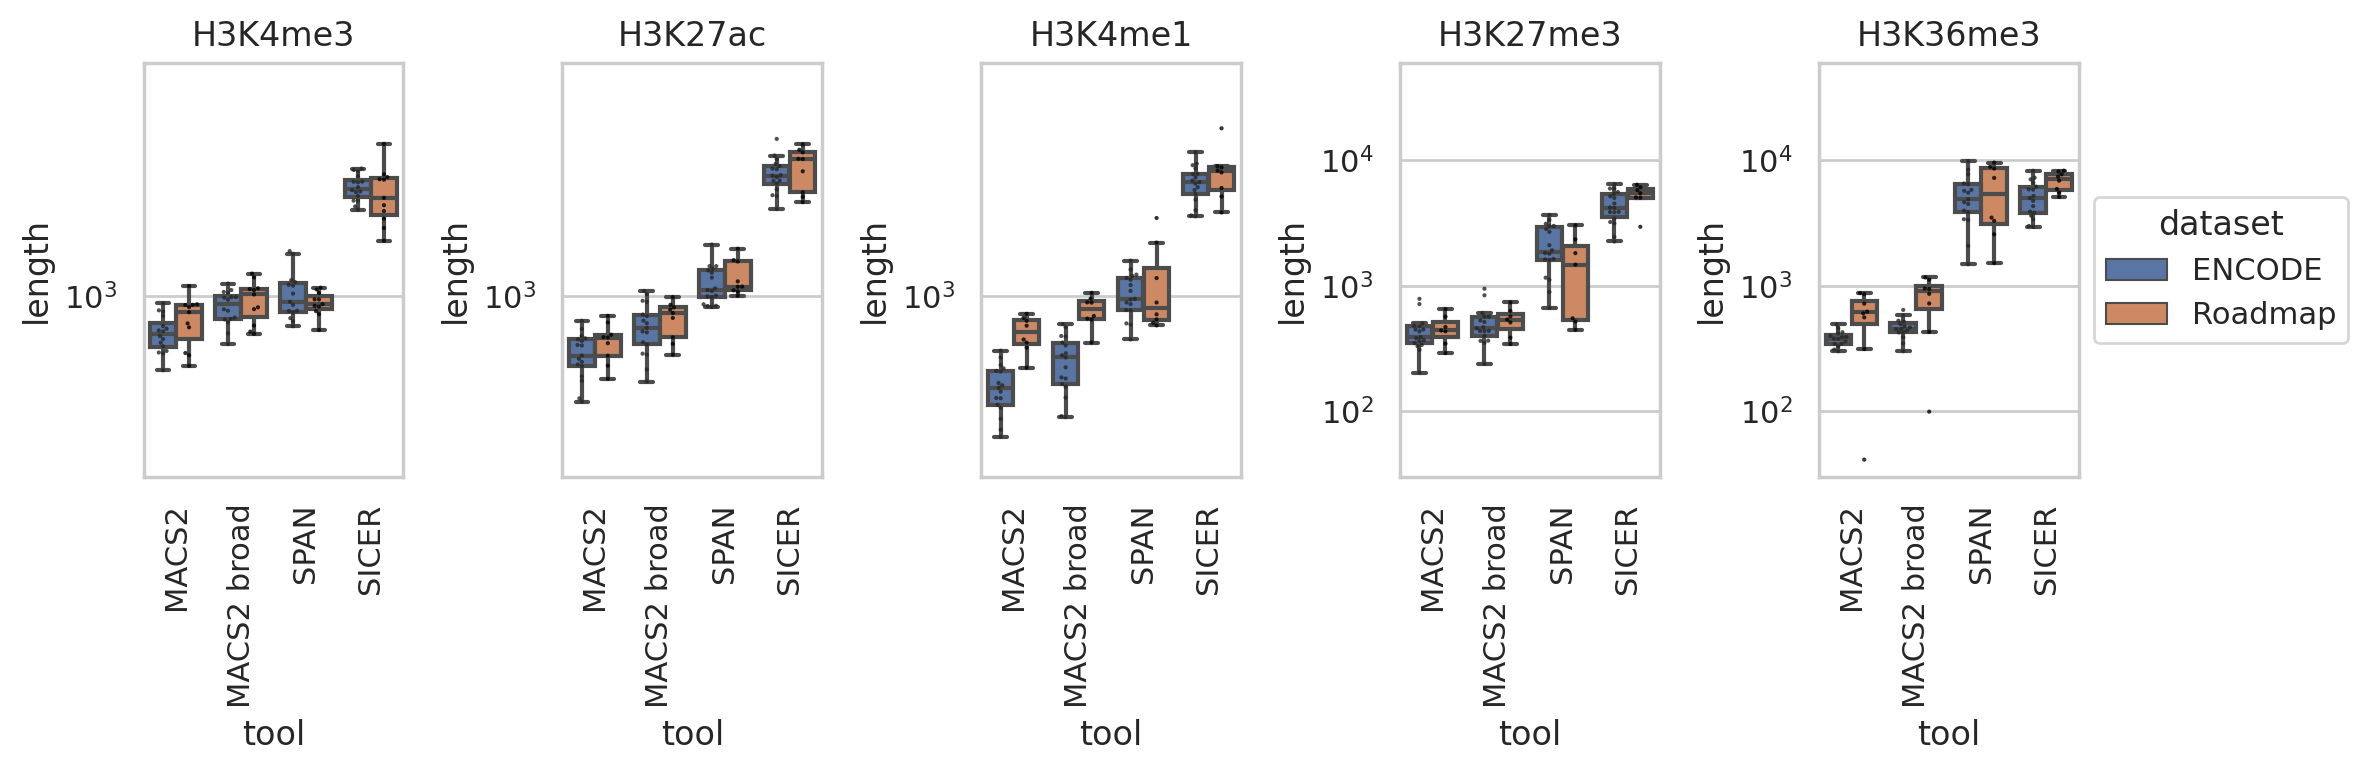

In [25]:
plt.figure(figsize=(12, 4))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, m in enumerate(['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3']):
    print(m)
    ax = axs[i]
    sns.boxplot(data=df_lens_avg[df_lens_avg['modification'] == m], x='tool', y='length', hue='dataset',
                showfliers=False,
                order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                hue_order=['ENCODE', 'Roadmap'],
                ax=ax)
    sns.swarmplot(data=df_lens_avg[df_lens_avg['modification'] == m], x='tool', y='length', hue='dataset',
                  dodge=True, size=1.5, palette='dark:black', alpha=0.8, legend=False,
                  order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                  hue_order=['ENCODE', 'Roadmap'],
                  ax=ax)
    ax.title.set_text(m)
    if i < len(axs) - 1:
        ax.legend().set_visible(False)
    else:
        sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
    if m not in ['H3K27me3', 'H3K36me3']:
        ax.set_ylim(bottom=200, top=8e3)
    else:
        ax.set_ylim(bottom=30, top=6e4)
    ax.set(yscale='log')
    ax.xaxis.set_tick_params(rotation=90)

plt.tight_layout()
plt.show()

In [26]:
df_lens_avg[(df_lens_avg['modification'] == 'H3K27me3') &
            (df_lens_avg['dataset'] == 'Roadmap') &
            (df_lens_avg['tool'] == 'SPAN')].sort_values(by=['length'], ascending=True)

dataset modification      cell replicate  tool      length    footprint  \
384  Roadmap     H3K27me3       CD4      rep2  SPAN   445.90000   18000390.0   
396  Roadmap     H3K27me3      PBMC            SPAN   518.26375   25289280.0   
380  Roadmap     H3K27me3       CD4            SPAN   550.39125   13044610.0   
392  Roadmap     H3K27me3        NK            SPAN  1472.61750  123138700.0   
372  Roadmap     H3K27me3      CD34            SPAN  1819.35875   85227170.0   
388  Roadmap     H3K27me3  Monocyte            SPAN  2344.81750  105909280.0   
376  Roadmap     H3K27me3      CD34      rep2  SPAN  3030.28625  115766610.0   

                ds_c_r  
384   Roadmap CD4 rep2  
396      Roadmap PBMC   
380       Roadmap CD4   
392        Roadmap NK   
372      Roadmap CD34   
388  Roadmap Monocyte   
376  Roadmap CD34 rep2

In [27]:
plt.figure(figsize=(12, 4))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, m in enumerate(['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3']):
    print(m)
    ax = axs[i]
    sns.boxplot(data=df_lens_avg[df_lens_avg['modification'] == m], x='tool', y='footprint', hue='dataset',
                showfliers=False,
                order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                hue_order=['ENCODE', 'Roadmap'],
                ax=ax)
    sns.swarmplot(data=df_lens_avg[df_lens_avg['modification'] == m], x='tool', y='footprint', hue='dataset',
                  dodge=True, size=1.5, palette='dark:black', alpha=0.8, legend=False,
                  order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                  hue_order=['ENCODE', 'Roadmap'],
                  ax=ax)
    ax.title.set_text(m)
    # ax.set(yscale='log')

    if i < len(axs) - 1:
        ax.legend().set_visible(False)
    else:
        sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
    # if m not in ['H3K27me3', 'H3K36me3']:
    #     ax.set_ylim(1, 4e3)
    # else:
    #     ax.set_ylim(1, 1.7e4)
    ax.xaxis.set_tick_params(rotation=90)

plt.tight_layout()
plt.show()

H3K4me3
H3K27ac
H3K4me1
H3K27me3
H3K36me3


In [28]:
sns.set_style("whitegrid")

plt.figure(figsize=(12, 4))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, m in enumerate(['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3']):
    print(m)
    ax = axs[i]
    sns.boxplot(data=df_lens_avg[df_lens_avg['modification'] == m], x='tool', y='length', hue='dataset',
                showfliers=False,
                order=['MACS2', 'MACS2 broad', 'SICER'],
                hue_order=['ENCODE', 'Roadmap'],
                ax=ax)
    sns.swarmplot(data=df_lens_avg[df_lens_avg['modification'] == m], x='tool', y='length', hue='dataset',
                  dodge=True, size=2,
                  palette='dark:black', alpha=0.8, legend=False,
                  order=['MACS2', 'MACS2 broad', 'SICER'],
                  hue_order=['ENCODE', 'Roadmap'],
                  ax=ax)
    ax.title.set_text(m)
    # ax.set(yscale='log')

    if i < len(axs) - 1:
        ax.legend().set_visible(False)
    else:
        sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
    if m not in ['H3K27me3', 'H3K36me3']:
        ax.set_ylim(bottom=200, top=1e5)
    else:
        ax.set_ylim(bottom=30, top=1e5)
    ax.set(yscale='log')
    ax.xaxis.set_tick_params(rotation=90)

plt.tight_layout()
plt.show()

H3K4me3
H3K27ac
H3K4me1
H3K27me3
H3K36me3


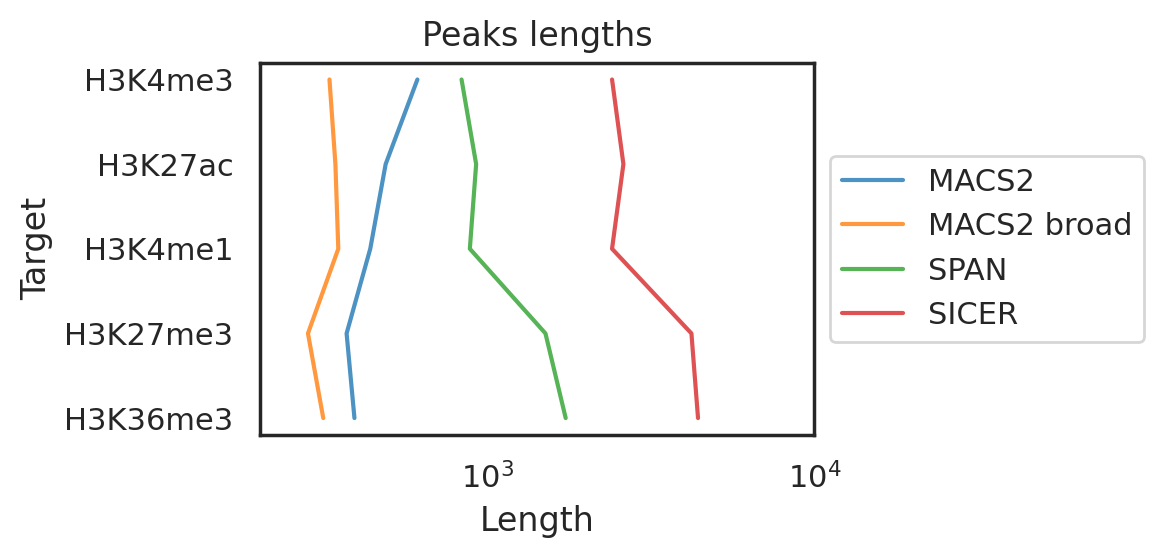

In [47]:
sns.set_theme(style="white")
df_lens['mindex'] = 0
for i, m in enumerate(reversed(['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3'])):
    df_lens.loc[df_lens['modification'] == m, 'mindex'] = i
plt.figure(figsize=(6, 3))
g_results = sns.lineplot(data=df_lens.sort_values(by=['mindex', 'tool', 'length']),
                         x='length', y='mindex', hue='tool', orient='y', estimator='median',
                         alpha=0.8,
                         hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                         palette=TOOLS_PALETTE,
                         errorbar=None,
                         # errorbar=('pi', 25),
                         # marker='o', markersize=1
                         )
g_results.axes.set_yticks(range(5), minor=False)
g_results.axes.set_yticklabels(reversed(['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3']))
g_results.axes.set_ylabel('Target')
g_results.axes.set_xlabel('Length')
g_results.set(xscale='log')
g_results.set_xlim(200, 1.0e4)
g_results.axes.title.set_text(f'Peaks lengths')
g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
# plt.savefig(f'{ENCODE_REPROCESSED_PATH}/pics/lengths_all.pdf', bbox_inches='tight', dpi=300)
plt.show()
sns.set_theme(style="whitegrid")

# ATAC-seq, CTCF info



In [49]:
def simple_load_peaks(path, suffix):
    df = pd.DataFrame(columns=['file', 'peaks'], dtype=object)
    for f in tqdm(os.listdir(path)):
        if not f.endswith(suffix):
            continue
        file = os.path.join(path, f)
        ps = lines(file)
        df.loc[len(df)] = (file, ps)
    return df


def simple_load_peaks_path(path):
    df_macs2 = simple_load_peaks(os.path.join(path, 'macs2'), '.narrowPeak')
    df_macs2['tool'] = 'MACS2'
    print('MACS2', len(df_macs2))

    df_macs2_broad = simple_load_peaks(os.path.join(path, 'macs2'), '.broadPeak')
    df_macs2_broad['tool'] = 'MACS2 broad'
    print('MACS2', len(df_macs2_broad))

    df_sicer = simple_load_peaks(os.path.join(path, 'sicer'), '.scoreisland')
    df_sicer['tool'] = 'SICER'
    print('SICER', len(df_sicer))

    df_span = simple_load_peaks(os.path.join(path, 'span'), '.peak')
    df_span['tool'] = 'SPAN'
    print('SPAN', len(df_span))

    return pd.concat([df_macs2, df_macs2_broad, df_sicer, df_span]).reset_index(drop=True)

In [50]:
ATAC_PATH = os.path.expanduser('~/data/2024_Immgen')
dfa = simple_load_peaks_path(ATAC_PATH)
# Pick ATAC-seq file without ATAC-seq clusters
# dfa = dfa[dfa['file'].str.contains('brain_Microglia')]
dfa

  0%|          | 0/64 [00:00<?, ?it/s]

MACS2 8


  0%|          | 0/64 [00:00<?, ?it/s]

MACS2 8


  0%|          | 0/6 [00:00<?, ?it/s]

SICER 6


  0%|          | 0/97 [00:00<?, ?it/s]

SPAN 8


file  peaks         tool
0   /home/jetbrains/data/2024_Immgen/macs2/SRR5799...  37320        MACS2
1   /home/jetbrains/data/2024_Immgen/macs2/SRR5799...  14589        MACS2
2   /home/jetbrains/data/2024_Immgen/macs2/SRR5799...  23563        MACS2
3   /home/jetbrains/data/2024_Immgen/macs2/SRR5799...  47240        MACS2
4   /home/jetbrains/data/2024_Immgen/macs2/SRR5799...  38064        MACS2
5   /home/jetbrains/data/2024_Immgen/macs2/SRR5799...  48264        MACS2
6   /home/jetbrains/data/2024_Immgen/macs2/SRR5799...  33399        MACS2
7   /home/jetbrains/data/2024_Immgen/macs2/SRR5799...  18272        MACS2
8   /home/jetbrains/data/2024_Immgen/macs2/SRR5799...  58993  MACS2 broad
9   /home/jetbrains/data/2024_Immgen/macs2/SRR5799...  20045  MACS2 broad
10  /home/jetbrains/data/2024_Immgen/macs2/SRR5799...  37502  MACS2 broad
11  /home/jetbrains/data/2024_Immgen/macs2/SRR5799...  24741  MACS2 broad
12  /home/jetbrains/data/2024_Immgen/macs2/SRR5799...  48591  MACS2 broad
13  /home/jetbrains/data/2024_Immgen/macs2/SRR5799...  18598  MACS2 broad
14  /home/jetbrains/data/2024_Immgen/macs2/SRR5799...  40366  MACS2 broad
15  /home/jetbrains/data/2024_Immgen/macs2/SRR5799...  46882  MACS2 broad
16  /home/jetbrains/data/2024_Immgen/sicer/SRR5799...  37850        SICER
17  /home/jetbrains/data/2024_Immgen/sicer/SRR5799...  31889        SICER
18  /home/jetbrains/data/2024_Immgen/sicer/SRR5799...  21492        SICER
19  /home/jetbrains/data/2024_Immgen/sicer/SRR5799...  43285        SICER
20  /home/jetbrains/data/2024_Immgen/sicer/SRR5799...  29551        SICER
21  /home/jetbrains/data/2024_Immgen/sicer/SRR5799...  34168        SICER
22  /home/jetbrains/data/2024_Immgen/span/SRR57995...  34373         SPAN
23  /home/jetbrains/data/2024_Immgen/span/SRR57994...  58883         SPAN
24  /home/jetbrains/data/2024_Immgen/span/SRR57994...  45611         SPAN
25  /home/jetbrains/data/2024_Immgen/span/SRR57994...  46594         SPAN
26  /home/jetbrains/data/2024_Immgen/span/SRR57994...  53853         SPAN
27  /home/jetbrains/data/2024_Immgen/span/SRR57994...  34097         SPAN
28  /home/jetbrains/data/2024_Immgen/span/SRR57995...  49317         SPAN
29  /home/jetbrains/data/2024_Immgen/span/SRR57994...  61950         SPAN

In [51]:
ts = []
for tool, file in tqdm(zip(dfa['tool'], dfa['file'])):
    lengths = bedl(file)
    t = pd.DataFrame(dict(length=lengths))
    t = t.sample(min(len(t), 10_000)).copy()
    t['tool'] = tool
    ts.append(t)
dfa_lens = pd.concat(ts).reset_index(drop=True)
del ts
display(dfa_lens.sample(10))

0it [00:00, ?it/s]

length         tool
48416      294        MACS2
228768     150         SPAN
197502     999        SICER
34214      116        MACS2
138415      99  MACS2 broad
115846     306  MACS2 broad
128061     271  MACS2 broad
176807    3799        SICER
61726      430        MACS2
263016     170         SPAN

In [52]:
CTCF_PATH = os.path.expanduser('~/data/2024_TFs')
df_ctcf = simple_load_peaks_path(CTCF_PATH)
display(df_ctcf)

  0%|          | 0/8 [00:00<?, ?it/s]

MACS2 1


  0%|          | 0/8 [00:00<?, ?it/s]

MACS2 1


  0%|          | 0/1 [00:00<?, ?it/s]

SICER 1


  0%|          | 0/12 [00:00<?, ?it/s]

SPAN 1


file  peaks         tool
0  /home/jetbrains/data/2024_TFs/macs2/H1_CTCF_hg...  95602        MACS2
1  /home/jetbrains/data/2024_TFs/macs2/H1_CTCF_hg...  98214  MACS2 broad
2  /home/jetbrains/data/2024_TFs/sicer/H1_CTCF_hg...  69006        SICER
3  /home/jetbrains/data/2024_TFs/span/H1_CTCF_hg3...  96274         SPAN

In [53]:
ts = []
for tool, file in tqdm(zip(df_ctcf['tool'], df_ctcf['file'])):
    lengths = bedl(file)
    t = pd.DataFrame(dict(length=lengths))
    t = t.sample(min(len(t), 10_000)).copy()
    t['tool'] = tool
    ts.append(t)
dfa_ctcf_lens = pd.concat(ts).reset_index(drop=True)
del ts
display(dfa_ctcf_lens.sample(3))

0it [00:00, ?it/s]

length  tool
36046     380  SPAN
39213     100  SPAN
31404     220  SPAN

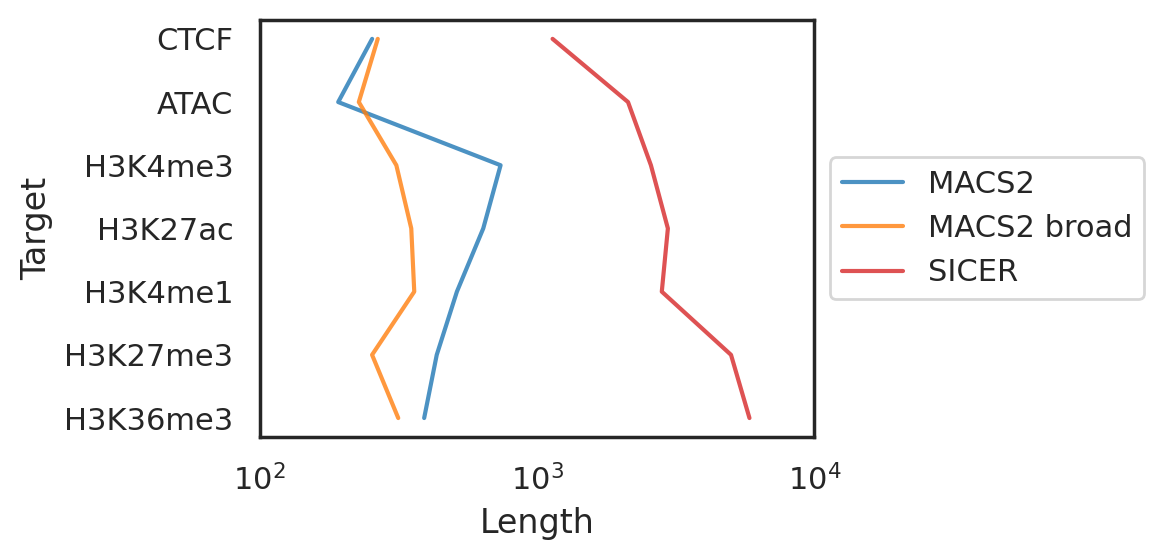

In [56]:
dfa_lens['modification'] = 'ATAC'
dfa_ctcf_lens['modification'] = 'CTCF'
t = pd.concat([df_lens_avg,
               dfa_ctcf_lens.groupby(['modification', 'tool']).agg('mean').reset_index(),
               dfa_lens.groupby(['modification', 'tool']).agg('mean').reset_index()]).reset_index(drop=True)
# t = pd.concat([df_lens, dfa_ctcf_lens, dfa_lens]).reset_index(drop=True).sample(100_000)

# t = t[t['tool'] != 'SPAN']
display()

sns.set_theme(style="white")
t['mindex'] = 0
for i, m in enumerate(reversed(['CTCF', 'ATAC', 'H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3'])):
    t.loc[t['modification'] == m, 'mindex'] = i
plt.figure(figsize=(6, 3))
g_results = sns.lineplot(data=t.sort_values(by=['mindex', 'tool', 'length']),
                         x='length', y='mindex', hue='tool', orient='y', estimator='median',
                         alpha=0.8,
                         hue_order=['MACS2', 'MACS2 broad', 'SICER'],
                         palette=TOOLS_PALETTE,
                         errorbar=None,
                         # marker='o', markersize=1
                         )
g_results.axes.set_yticks(range(7), minor=False)
g_results.axes.set_yticklabels(reversed(['CTCF', 'ATAC', 'H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3']))
g_results.axes.set_ylabel('Target')
g_results.axes.set_xlabel('Length')
g_results.set(xscale='log')
g_results.set_xlim(100, 1.0e4)
g_results.axes.title.set_text(f'')
g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
# plt.savefig(f'{ENCODE_REPROCESSED_PATH}/pics/lengths_all.pdf', bbox_inches='tight', dpi=300)
plt.show()

# BAMs

In [33]:
def load_bams(path, modifications, cells, replicates, control='Input'):
    df_bams = pd.DataFrame(columns=['bam_file', 'modification', 'cell', 'replicate', 'reads'], dtype=object)
    for f in tqdm(os.listdir(path)):
        if not f.endswith('.bam'):
            continue
        cell = next((c for c in cells if c in f), None)
        rep = next((r for r in replicates if r in f), None)
        mod = next((m for m in modifications if m in f), None)
        if mod is None and control is not None and control in f:
            mod = 'Control'
        if mod and cell is not None and rep is not None:
            file = os.path.join(path, f)
            reads = ! samtools view -F 0x04 -c {file}
            reads = int(reads[0])
            df_bams.loc[len(df_bams)] = (file, mod, cell, rep, reads)
    return df_bams

In [29]:
df_encode_bams = load_bams(GSE26320_PATH + '/bams', MODIFICATIONS, GSE26320_CELLS, GSE26320_REPS, 'Input')
df_encode_bams['dataset'] = 'ENCODE'
df_immune_bams = load_bams(IMMUNE_PATH + '/bams', MODIFICATIONS, IMMUNE_CELLS, IMMUNE_REPS, 'Control')
df_immune_bams['dataset'] = 'Roadmap'
df_abf_bams = load_bams(ABF_PATH + '/bams', ABF_MODIFICATIONS, [''], ABF_REPLICATES, 'input')
update_abf_modifications(df_abf_bams)
df_abf_bams['dataset'] = 'ABF'
reads = ! samtools view -F 0x04 -c {ABF_PATH}/bams/input.bam
reads = int(reads[0])
df_abf_bams.loc[len(df_abf_bams)] = (f'{ABF_PATH}/bams/input.bam', 'Control', '', '', reads, 'ABF')

df_bams = pd.concat([df_encode_bams, df_immune_bams, df_abf_bams]).reset_index(drop=True)

  0%|          | 0/206 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/384 [00:00<?, ?it/s]

In [37]:
reads

41276731

/tmp/ipykernel_1056580/4049642252.py:3: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 2}` instead.

  sns.barplot(data=df_bams, hue='modification', x='dataset', y='reads',


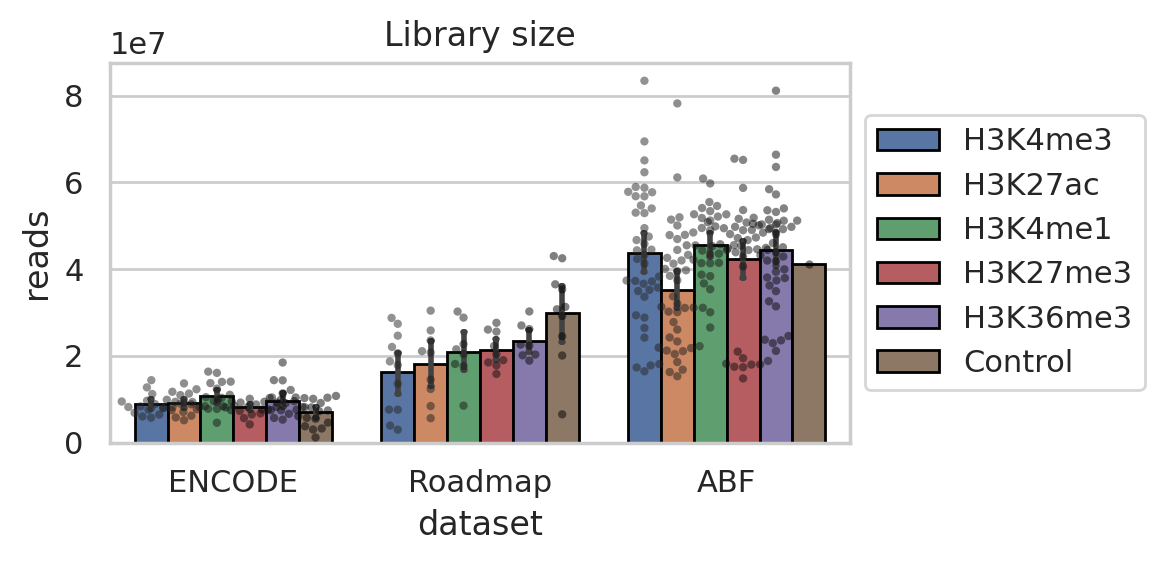

In [40]:
plt.figure(figsize=(6, 3))
ax = plt.axes()
sns.barplot(data=df_bams, hue='modification', x='dataset', y='reads',
            capsize=.05, errwidth=2, edgecolor="black",
            hue_order=MODIFICATIONS + ['Control'],
            ax=ax)
sns.swarmplot(data=df_bams, hue='modification', x='dataset', y='reads',
              dodge=True, size=3, palette='dark:black', alpha=0.5, legend=False,
              hue_order=MODIFICATIONS + ['Control'],
              ax=ax)
ax.set_title('Library size')
# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

In [ ]:
df_peaks_lens = pd.merge(df_peaks[['dataset', 'modification', 'cell', 'replicate', 'tool', 'peaks']],
                         df_bams[['dataset', 'modification', 'cell', 'replicate', 'reads']],
                         on=['dataset', 'modification', 'cell', 'replicate'], how='inner')
df_peaks_lens = pd.merge(df_peaks_lens,
                         df_lens_avg[['dataset', 'modification', 'cell', 'replicate', 'tool', 'length', 'footprint']],
                         on=['dataset', 'modification', 'cell', 'replicate', 'tool'], how='inner')
df_peaks_lens.sample(3)

In [ ]:
for x, y in [('peaks', 'length'), ('peaks', 'reads')]:
    print(f'\n\n{x} vs {y}')
    plt.figure(figsize=(15, 3))
    axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
    for i, m in enumerate(['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3']):
        ax = axs[i]
        sns.kdeplot(
            df_peaks_lens[df_peaks_lens['modification'] == m], x=x, y=y, hue='tool',
            alpha=0.8,
            style='dataset',
            palette=TOOLS_PALETTE,
            hue_order=TOOLS,
            thresh=0.05,
            fill=True,
            ax=ax)
        ax.title.set_text(m)
        if i < len(axs) - 1:
            ax.legend().set_visible(False)
        else:
            sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
        if x != 'reads':
            ax.xaxis.set_tick_params(rotation=90)
    plt.tight_layout()
    plt.show()

In [ ]:
for x, y in [('peaks', 'length'), ('peaks', 'reads')]:
    print(f'\n\n{x} vs {y}')
    plt.figure(figsize=(5, 4))
    ax = plt.axes()
    tt = df_peaks_lens[(df_peaks_lens['modification'] == 'H3K4me1') & (df_peaks_lens['tool'] == 'MACS2 broad')].copy()
    tt['ds_c_r'] = tt['dataset'] + ' ' + tt['cell'] + ' ' + tt['replicate']
    sns.scatterplot(
        tt, x=x, y=y,
        style='dataset',
        hue=['E<60K' if dscr in g1_ds_c_r else 'E>80K' if dscr in g2_ds_c_r else
        'ENCODE other' if 'ENCODE' in dscr else 'Roadmap' for dscr in tt['ds_c_r']],
        alpha=[1 if dscr in g1_ds_c_r or dscr in g2_ds_c_r or 'Roadmap' in dscr else 0.2 for dscr in tt['ds_c_r']],
        ax=ax)
    for xv, yv, cell, rep in zip(tt[x], tt[y], tt['cell'], tt['replicate']):
        rep = '1' if rep == 'rep1' else '2' if rep == 'rep2' else ''
        ax.text(xv, yv, f'{cell} {rep}', fontsize=5)
    ax.title.set_text('H3K4me1')
    sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
    if x != 'reads':
        ax.xaxis.set_tick_params(rotation=90)
    plt.tight_layout()
    plt.show()

# BigWigs stats

In [ ]:
CHROM_SIZES = {
    c: s for _, (c, s) in pd.read_csv(os.path.join(GSE26320_PATH, 'hg38.chrom.sizes'),
                                      sep='\t', names=['chr', 'size']).iterrows() if '_' not in c
}


def load_bws(path, modification, cells, replicates, control='Input'):
    df_bws = pd.DataFrame(columns=['file', 'modification', 'cell', 'replicate'], dtype=object)
    for f in tqdm(os.listdir(path)):
        if '.bw' not in f:
            continue
        mod = next((m for m in modification if m in f), None)
        if mod is None and control is not None and control in f:
            mod = 'Control'
        cell = next((c for c in cells if c in f), None)
        rep = next((r for r in replicates if r in f), None)
        if mod and cell and rep is not None:
            df_bws.loc[len(df_bws)] = ((os.path.join(path, f)), mod, cell, rep)
    return df_bws

In [ ]:
encode_bws = load_bws(GSE26320_PATH + '/bw', MODIFICATIONS, GSE26320_CELLS, GSE26320_REPS, 'Input')
encode_bws['dataset'] = 'ENCODE'
display(encode_bws.sample(3))

immune_bws = load_bws(IMMUNE_PATH + '/bw', MODIFICATIONS, IMMUNE_CELLS, IMMUNE_REPS, 'Control')
immune_bws['dataset'] = 'Roadmap'
display(immune_bws.sample(3))
all_bws = pd.concat([encode_bws, immune_bws]).reset_index(drop=False)

In [ ]:
import pyBigWig

total_coverages = {}
ts = []
for _, (ds, m, c, r) in tqdm(list(all_bws[['dataset', 'modification', 'cell', 'replicate']].iterrows())):
    print(ds, m, c, r)
    t = all_bws[(all_bws['modification'] == m) &
                (all_bws['cell'] == c) &
                (all_bws['replicate'] == r) &
                (all_bws['dataset'] == ds)]
    if len(t) == 0:
        continue
    bw_path = t['file'].values[0]
    # print(bw_path)

    try:
        with pyBigWig.open(bw_path) as bw:
            total_coverage = sum(
                bw.stats(chr, exact=True, type='sum')[0] for chr in CHROM_SIZES.keys() if '_' not in chr)
            print('Total coverage', total_coverage)
            # Multiplier to align BAM coverage with BigWig estimation
            total_coverage *= 1.1e-2
            total_coverages[(ds, m, c, r)] = total_coverage
    except Exception:
        pass
        # print('ERROR')

total_coverages_df = pd.DataFrame([(ds, m, c, r, n) for (ds, m, c, r), n in total_coverages.items()],
                                  columns=['dataset', 'modification', 'cell', 'replicate', 'reads'])
total_coverages_df.sample(5)

In [ ]:
# Prepare BAM files
WD = os.path.expanduser('~/data/2023_wiggle')

BLACKLIST_PATH = WD + '/hg38-blacklist.v2.bed'
blacklist_df = pd.read_csv(BLACKLIST_PATH, sep='\t', header=None)
blacklist_df.rename({0: 'chr', 1: 'start', 2: 'end'}, axis=1, inplace=True)
blacklist_df

In [ ]:
# def collect_bw_stats(bw_path, control_bw_path, chrom_sizes, blacklist, region_len, top_regions, work_regions, resolution):
#     print('Prepare chromosome indexes')
#     chr_indx = {}
#     indx = 0
#     for chr, chr_size in chrom_sizes.items():
#         if '_' in chr:
#             continue
#         bins = int(math.floor(chr_size / region_len))
#         chr_indx[chr] = (indx, indx + bins)
#         indx += bins
#     chromosomes = list(chr_indx.keys())
# 
#     print('Compute coverage in regions')
#     region_coverages = np.zeros(indx)
#     with pyBigWig.open(bw_path) as bw:
#         for chr, (istart, iend) in chr_indx.items():
#             region_coverages[istart: iend] = \
#                 np.array([x or 0 for x in bw.stats(chr, 1, chrom_sizes[chr], nBins=iend - istart, exact=True, type='sum')])
#     
#     if blacklist is not None:
#         print('Processing blacklisted regions')
#         blacklist_marked = 0
#         for chr, start, end in zip(blacklist['chr'], blacklist['start'], blacklist['end']):
#             if chr not in chr_indx:
#                 continue
#             offset = chr_indx[chr][0]
#             for x in range(int(math.floor(start / region_len)), int(math.ceil(end / region_len)) + 1):
#                 region_coverages[min(x - offset, len(region_coverages) - 1)] = 0
#                 blacklist_marked += 1
#         print(f'Marked {blacklist_marked} / {len(region_coverages)} bins as blacklist')
# 
#     if top_regions > len(region_coverages):
#         raise Exception(f'Too many top regions {top_regions} > {len(region_coverages)}')
#     
#     print('Split by chromosomes')
#     chr_xs = [[] for _ in range(len(chr_indx))]  # Create new array for each chromosome index
#     ichr = 0
#     for x in np.sort(np.argpartition(region_coverages, -top_regions)[-top_regions:]):
#         while chr_indx[chromosomes[ichr]][1] < x:
#             ichr += 1
#         chr_xs[ichr].append(x)
# 
#     print('Collect final regions')
#     peaks = []
#     for ichr, xs in enumerate(chr_xs):
#         chr = chromosomes[ichr]
#         offset = chr_indx[chr][0]
#         for i, x in enumerate(xs):
#             peaks.append((chr, (x - offset) * region_len, (x + 1 - offset) * region_len))
#     df = pd.DataFrame(peaks, columns=['chromosome', 'start', 'end'])
#     if len(df) > work_regions:
#         print(f'Pick {work_regions} / {top_regions} uniform regions for computation speedup')
#         step = int(math.ceil(len(df) / float(work_regions)))
#         df = df.iloc[range(0, len(df), step)].copy()
#     
#     print('Collecting bigwig stats')
#     sums, means, stds, control_sums, control_means, control_stds = [], [], [], [], [], []
#     with pyBigWig.open(bw_path) as bw:
#         for _, (chr, start, end) in df.iterrows():
#             stats = np.array(bw.stats(
#                 chr, start, end, nBins=int(math.ceil((end - start) / resolution)), exact=True, type='sum'))
#             sums.append(np.sum(stats))
#             means.append(np.mean(stats))
#             stds.append(np.std(stats))
#     df['sum'] = sums
#     df['mean'] = means
#     df['std'] = stds
#     if control_bw_path is not None:
#         with pyBigWig.open(control_bw_path) as cbw:
#                 for _, (chr, start, end) in df[['chromosome', 'start', 'end']].iterrows():
#                     control_stats = np.array(cbw.stats(
#                         chr, start, end, nBins=int(math.ceil((end - start) / resolution)), exact=True, type='sum'))
#                     control_sums.append(np.sum(control_stats))
#                     control_means.append(np.mean(control_stats))
#                     control_stds.append(np.std(control_stats))
#         df['control_sum'] = control_sums
#         df['control_mean'] = control_means
#         df['control_std'] = control_stds
#     return df

In [ ]:
from queue import PriorityQueue


def collect_bw_stats(bw_path, control_bw_path, chrom_sizes, blacklist, region_len, top_regions, work_regions,
                     resolution):
    regions = sum(
        int(math.floor(chr_size / region_len)) if '_' not in chr else 0 for chr, chr_size in chrom_sizes.items())
    if top_regions > regions:
        raise Exception(f'Too many top regions {top_regions} > {len(regions)}')

    print('Compute coverage in regions')
    region_coverages = PriorityQueue(maxsize=top_regions)
    blacklist_marked = 0
    with pyBigWig.open(bw_path) as bw:
        for chr, chr_size in chrom_sizes.items():
            if '_' in chr:
                continue
            bins = int(math.floor(chr_size / region_len))
            blacklisted_bins = np.zeros(bins)
            if blacklist is not None:
                for _, (start, end) in blacklist[blacklist['chr'] == chr][['start', 'end']].iterrows():
                    for i in range(int(math.floor(start / region_len)), int(math.ceil(end / region_len)) + 1):
                        blacklisted_bins[min(i, bins - 1)] = 1
                        blacklist_marked += 1
            for i, cov in enumerate(bw.stats(chr, 0, chr_size, nBins=bins, exact=True, type='sum')):
                if cov is None:
                    continue  # VERY strange
                if blacklisted_bins[i] == 0:
                    if region_coverages.full():
                        region_coverages.get()  # Removes the element with lowest coverage 
                    region_coverages.put((cov, chr, i))

    if blacklist is not None:
        print(f'Marked {blacklist_marked} / {regions} blacklisted regions')

    peaks = []
    while not region_coverages.empty():
        cov, chr, i = region_coverages.get()
        peaks.append((chr, i * region_len, (i + 1) * region_len, cov))

    df = pd.DataFrame(peaks, columns=['chromosome', 'start', 'end', 'cov'])
    df.sort_values(by=['cov'], ascending=False, inplace=True)

    if len(df) > work_regions:
        print(f'Pick {work_regions} / {top_regions} uniform regions for computation speedup')
        step = int(math.ceil(len(df) / float(work_regions)))
        df = df.iloc[range(0, len(df), step)].copy()

    print('Collecting bigwig stats')
    sums, means, stds, control_sums, control_means, control_stds = [], [], [], [], [], []
    with pyBigWig.open(bw_path) as bw:
        for _, (chr, start, end) in df[['chromosome', 'start', 'end']].iterrows():
            stats = np.array(bw.stats(
                chr, start, end, nBins=int(math.ceil((end - start) / resolution)), exact=True, type='sum'))
            sums.append(np.sum(stats))
            means.append(np.mean(stats))
            stds.append(np.std(stats))
    df['sum'] = sums
    df['mean'] = means
    df['std'] = stds
    if control_bw_path is not None:
        with pyBigWig.open(control_bw_path) as cbw:
            for _, (chr, start, end) in df[['chromosome', 'start', 'end']].iterrows():
                control_stats = np.array(cbw.stats(
                    chr, start, end, nBins=int(math.ceil((end - start) / resolution)), exact=True, type='sum'))
                control_sums.append(np.sum(control_stats))
                control_means.append(np.mean(control_stats))
                control_stds.append(np.std(control_stats))
        df['control_sum'] = control_sums
        df['control_mean'] = control_means
        df['control_std'] = control_stds
    return df

In [ ]:
import math

REGION_LEN = 10_000
TOP_REGIONS = 10_000
WORK_REGIONS = 200
RESOLUTION = 100

# Compute on top chromosomes for speed
chrom_sizes_part = {f'chr{i + 1}': CHROM_SIZES[f'chr{i + 1}'] for i in range(3)}

ts = []
for _, (bw_path, ds, m, c, r) in all_bws[['file', 'dataset', 'modification', 'cell', 'replicate']].iterrows():
    # if not (ds == 'Roadmap' and c in ['TCell', 'BCell', 'Monocyte']):
    #     continue
    if m == 'Control':
        continue
    cr = r
    ct = all_bws[(all_bws['modification'] == 'Control') &
                 (all_bws['cell'] == c) &
                 (all_bws['replicate'] == cr) &
                 (all_bws['dataset'] == ds)]
    # Control can be different for Roadmap
    if len(ct) == 0:
        cr = ''
        ct = all_bws[(all_bws['modification'] == 'Control') &
                     (all_bws['cell'] == c) &
                     (all_bws['replicate'] == cr) &
                     (all_bws['dataset'] == ds)]
    if len(ct) == 0:
        continue
    print(ds, m, c, r, bw_path)
    cbw_path = ct['file'].values[0]
    print(bw_path, cbw_path)
    df = collect_bw_stats(bw_path, cbw_path, chrom_sizes_part, blacklist_df, REGION_LEN, TOP_REGIONS, WORK_REGIONS,
                          RESOLUTION)
    df['dataset'] = ds
    df['modification'] = m
    df['cell'] = c
    df['replicate'] = r
    df['control_replicate'] = cr
    df['rpkm'] = df['sum'] / ((REGION_LEN / 1e3) * ((total_coverages[(ds, m, c, r)]) / 1e6))
    df['control_reads'] = total_coverages[(ds, 'Control', c, cr)]
    df['control_rpkm'] = df['control_sum'] / ((REGION_LEN / 1e3) * ((total_coverages[(ds, 'Control', c, cr)]) / 1e6))
    df['signal_to_control'] = [d(s, c) for s, c in zip(df['rpkm'], df['control_rpkm'])]
    ts.append(df)
df_bw_stats = pd.concat(ts).reset_index(drop=True)
df_bw_stats.sample(5)

In [ ]:
df_bw_stats['std_mean'] = [d(std, mean) for std, mean in zip(df_bw_stats['std'], df_bw_stats['mean'])]
df_bw_stats['control_std_mean'] = \
    [d(std, mean) for std, mean in zip(df_bw_stats['control_std'], df_bw_stats['control_mean'])]

# Signal-to-noise, signal-to-control

In [ ]:
print('Assign groups by coverage percentiles individually in each track')
ts = []
for (ds, m, c, r), group in df_bw_stats.groupby(['dataset', 'modification', 'cell', 'replicate']):
    group = group.sort_values(by=['mean'], ascending=False)
    group['percentile'] = [10 * int(10.0 * i / len(group)) for i in range(len(group))]
    ts.append(group)
df_bw_stats_perc = pd.concat(ts).reset_index(drop=True)
del ts
df_bw_stats_perc.sample(5)

In [ ]:
print('Compute Signal-to-noise ratio')
t = df_bw_stats_perc[
    ['dataset', 'modification', 'cell', 'replicate', 'percentile', 'mean']
].groupby(['dataset', 'modification', 'cell', 'replicate', 'percentile']).agg('mean').reset_index()
ts = []
for (ds, m, c, r), dt in t.groupby(['dataset', 'modification', 'cell', 'replicate']):
    snr = dt[dt['percentile'] <= 20]['mean'].mean() / dt[dt['percentile'] >= 80]['mean'].mean()
    ts.append((ds, m, c, r, snr))
df_snr = pd.DataFrame(ts, columns=['dataset', 'modification', 'cell', 'replicate', 'signal_to_noise'])
df_snr.sample(3)

In [ ]:
print('Pick only top covered regions, where most of the peaks are located')
df_bw_stats_signal_aggr = df_bw_stats_perc[df_bw_stats_perc['percentile'] <= 20][
    ['dataset', 'modification', 'cell', 'replicate', 'sum', 'mean', 'std', 'rpkm', 'std_mean', 'signal_to_control',
     'control_reads', 'control_sum', 'control_mean', 'control_std', 'control_rpkm', 'control_std_mean', ]
].groupby(['dataset', 'modification', 'cell', 'replicate']).agg('mean').reset_index()
df_bw_stats_signal_aggr.sample(3)

In [ ]:
df_bw_stats_signal_snr_aggr = pd.merge(df_snr, df_bw_stats_signal_aggr,
                                       on=['dataset', 'modification', 'cell', 'replicate'], how='inner')

In [ ]:
plt.figure(figsize=(3, 4))
ax = plt.axes()
t = df_bw_stats_signal_snr_aggr
sns.boxplot(data=t, x='modification', y='std_mean', hue='dataset',
            order=MODIFICATIONS,
            showfliers=False,
            ax=ax)
ax.title.set_text('Std/mean')
ax.xaxis.set_tick_params(rotation=90)
plt.tight_layout()
plt.show()

In [ ]:
df_bw_stats_signal_snr_aggr[(df_bw_stats_signal_snr_aggr['modification'] == 'H3K4me3') &
                            (df_bw_stats_signal_snr_aggr['cell'] == 'CD4')].sort_values(by=['std_mean'],
                                                                                        ascending=False).head(50)

# Compare vs peaks

In [ ]:
df_aggr = pd.merge(df_bw_stats_signal_snr_aggr,
                   df_peaks_lens,
                   on=['dataset', 'modification', 'cell', 'replicate'], how='inner')
df_aggr['reads_min'] = [min(s, c) for s, c in zip(df_aggr['reads'], df_aggr['control_reads'])]
df_aggr

In [ ]:
df_aggr[['dataset', 'modification', 'cell', 'replicate']].drop_duplicates().groupby(['dataset', 'modification']).size()

In [ ]:
for m, cells in [
    ('H3K4me1', ['H1']),
    ('H3K27me3', ['CD4', 'Monocyte']),
    ('H3K36me3', ['CD4']),
    ('H3K27me3', ['HepG2']),
]:
    print(m, cells)
    display(df_aggr[(df_aggr['modification'] == m) &
                    (df_aggr['cell'].isin(cells))][['cell', 'replicate', 'reads', 'rpkm', 'std_mean',
                                                    'control_reads', 'control_rpkm', 'control_std_mean',
                                                    'reads_min',
                                                    'signal_to_noise', 'signal_to_control', ]].drop_duplicates())
    display(df_peaks_lens[(df_peaks_lens['modification'] == m) &
                          (df_peaks_lens['cell'].isin(cells))][['cell', 'replicate', 'tool', 'peaks', 'length']])

In [ ]:
# (df_peaks_lens['cell'].isin(cells))][['cell', 'replicate', 'tool', 'peaks', 'length']])
features = ['reads', 'mean', 'rpkm', 'std_mean',
            'control_reads', 'control_mean', 'control_rpkm', 'control_std_mean',
            'reads_min',
            'signal_to_noise', 'signal_to_control', ]
ts = []
ts.append(ts.append(
    df_aggr[df_aggr['tool'] == 'SPAN'][['dataset', 'modification', 'cell', 'replicate'] + features].copy().reset_index(
        drop=True)))
for tool in TOOLS:
    t = df_aggr[df_aggr['tool'] == tool][['peaks', 'length']].copy().reset_index(drop=True)
t.rename({'peaks': f'{tool} peaks', 'length': f'{tool} length'}, axis=1, inplace=True)
ts.append(t)
tt = pd.concat(ts, axis=1).reset_index(drop=True)
display(tt.head(10))

In [ ]:
features = ['reads', 'mean', 'rpkm', 'std_mean',
            'control_reads', 'control_mean', 'control_rpkm', 'control_std_mean',
            'reads_min',
            'signal_to_noise', 'signal_to_control', ]
ts = []
ts.append(ts.append(
    df_aggr[df_aggr['tool'] == 'SPAN'][['dataset', 'modification', 'cell', 'replicate'] + features].copy().reset_index(
        drop=True)))
for tool in TOOLS:
    t = df_aggr[df_aggr['tool'] == tool][['peaks', 'length']].copy().reset_index(drop=True)
    t.rename({'peaks': f'{tool} peaks', 'length': f'{tool} length'}, axis=1, inplace=True)
    ts.append(t)
tt = pd.concat(ts, axis=1).reset_index(drop=True)
display(tt.head(10))
features = list(tt.columns)[4:]
del ts
ncols = int(math.ceil(math.sqrt(len(features) + 3)))
nrows = int(math.ceil(len(features) / ncols))
plt.figure(figsize=(2.5 * ncols, 2 * nrows))
axs = [plt.subplot(nrows, ncols, i + 1) for i in range(len(features))]
for i, y in enumerate(features):
    ax = axs[i]
    sns.boxplot(data=tt, x='modification', y=y,
                hue='dataset',
                order=MODIFICATIONS,
                showfliers=False,
                ax=ax)
    # sns.swarmplot(data=tt, x='modification', y=y, hue='dataset',
    #               order=MODIFICATIONS,
    #               dodge=True, size=1.5, alpha=0.5, palette='dark:black', legend=False,
    #               ax=ax)
    ax.title.set_text(y)
    ax.set_ylabel(None)
    if i < (nrows - 1) * ncols:
        ax.set_xlabel(None)
        ax.set_xticks([], minor=False)
        ax.set_xticklabels([])
    ax.xaxis.set_tick_params(rotation=90)
    if i % ncols == ncols - 1:
        sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
    else:
        ax.legend().set_visible(False)
plt.tight_layout()
plt.show()

In [ ]:
sns.pairplot(data=tt[['dataset'] + features], hue='dataset', diag_kind='hist')
plt.show()

In [ ]:
corrs = tt[features].corr(method='spearman')
sns.clustermap(corrs,
               col_cluster=True, row_cluster=True,
               figsize=(6, 6),
               cmap=plt.cm.seismic,
               vmin=-1, vmax=1)
plt.show()

In [ ]:
t = np.zeros(shape=(len(features) - 8, 4 * 5 * 3))

for i, (tool, m) in enumerate(product(TOOLS, MODIFICATIONS)):
    ttm = tt[tt['modification'] == m]
    t[:, i * 3] = ttm.corr(method='spearman').loc[features[:-8]][f'{tool} peaks'].values
    t[:, i * 3 + 1] = ttm[ttm['dataset'] == 'ENCODE'][features].corr(method='spearman').loc[features[:-8]][
        f'{tool} peaks'].values
    t[:, i * 3 + 2] = ttm[ttm['dataset'] == 'Roadmap'][features].corr(method='spearman').loc[features[:-8]][
        f'{tool} peaks'].values
t = pd.DataFrame(t,
                 columns=[f'{s} {m} {tool}' for tool, m, s in
                          product(TOOLS, MODIFICATIONS, ['Full', 'ENCODE', 'Roadmap'])],
                 index=features[:-8])
sns.clustermap(t,
               col_cluster=False, row_cluster=True,
               figsize=(20, 6),
               cmap=plt.cm.seismic,
               vmin=-1, vmax=1)
plt.show()

# 3 groups MACS2 broad analysis

In [ ]:
tt = df_aggr[(df_aggr['modification'] == 'H3K4me1') & (df_aggr['tool'] == 'MACS2 broad')].copy()
tt['ds_c_r'] = tt['dataset'] + ' ' + tt['cell'] + ' ' + tt['replicate']

In [ ]:
features = ['reads', 'mean', 'rpkm', 'std_mean',
            'control_reads', 'control_mean', 'control_rpkm', 'control_std_mean',
            'reads_min',
            'signal_to_noise', 'signal_to_control', ]

ncols = int(math.ceil(math.sqrt(len(features) + 3)))
nrows = int(math.ceil((len(features) + 1) / ncols))
plt.figure(figsize=(2 * ncols, 2 * nrows))
axs = [plt.subplot(nrows, ncols, i + 1) for i in range(len(features) + 1)]
for i, y in enumerate(['peaks'] + features):
    ax = axs[i]
    sns.boxplot(data=tt, y=y, x=['E<60K' if dscr in g1_ds_c_r else 'E>80K' if dscr in g2_ds_c_r else
    'ENCODE other' if 'ENCODE' in dscr else 'Roadmap' for dscr in tt['ds_c_r']],
                order=['E<60K', 'ENCODE other', 'E>80K', 'Roadmap'],
                showfliers=False,
                ax=ax)
    sns.swarmplot(data=tt, y=y, x=['E<60K' if dscr in g1_ds_c_r else 'E>80K' if dscr in g2_ds_c_r else
    'ENCODE other' if 'ENCODE' in dscr else 'Roadmap' for dscr in tt['ds_c_r']],
                  order=['E<60K', 'ENCODE other', 'E>80K', 'Roadmap'],
                  size=1, alpha=0.5, legend=False,
                  ax=ax)
    ax.title.set_text(y)
    ax.set_ylabel(None)
    if i < (nrows - 1) * ncols:
        ax.set_xlabel(None)
        ax.set_xticks([], minor=False)
        ax.set_xticklabels([])
    ax.xaxis.set_tick_params(rotation=90)

plt.tight_layout()
plt.show()

In [ ]:
ncols = int(math.ceil(math.sqrt(len(features) + 3)))
nrows = int(math.ceil(len(features) / ncols))
plt.figure(figsize=(3 * ncols, 2.5 * nrows))
axs = [plt.subplot(nrows, ncols, i + 1) for i in range(len(features))]
for i, y in enumerate(features):
    ax = axs[i]
    sns.scatterplot(
        tt, x='peaks', y=y,
        style='dataset',
        hue=['E<60K' if dscr in g1_ds_c_r else 'E>80K' if dscr in g2_ds_c_r else
        'ENCODE other' if 'ENCODE' in dscr else 'Roadmap' for dscr in tt['ds_c_r']],
        alpha=[1 if dscr in g1_ds_c_r or dscr in g2_ds_c_r or 'Roadmap' in dscr else 0.2 for dscr in tt['ds_c_r']],
        ax=ax)
    ax.title.set_text(f'peaks vs {y}')
    ax.xaxis.set_tick_params(rotation=90)
    if i == len(axs) - 1:
        sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
    else:
        ax.legend().set_visible(False)
plt.tight_layout()
plt.show()

In [ ]:
from scipy.stats import spearmanr

for x, y in [('reads', 'control_reads'), ('peaks', 'reads_min'), ('peaks', 'signal_to_control')]:
    print(f'\n\n{x} vs {y}')
    plt.figure(figsize=(5, 4))
    ax = plt.axes()
    sns.scatterplot(
        tt, x=x, y=y,
        style='dataset',
        hue=['E<60K' if dscr in g1_ds_c_r else 'E>80K' if dscr in g2_ds_c_r else
        'ENCODE other' if 'ENCODE' in dscr else 'Roadmap' for dscr in tt['ds_c_r']],
        alpha=[1 if dscr in g1_ds_c_r or dscr in g2_ds_c_r or 'Roadmap' in dscr else 0.2 for dscr in tt['ds_c_r']],
        ax=ax)
    for xv, yv, cell, rep in zip(tt[x], tt[y], tt['cell'], tt['replicate']):
        rep = '1' if rep == 'rep1' else '2' if rep == 'rep2' else ''
        ax.text(xv, yv, f'{cell} {rep}', fontsize=5)
    corr, p = spearmanr(tt[x], tt[y])
    ax.title.set_text(f'c={corr:.2f} p={p:.1e}')
    sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
    if x != 'reads':
        ax.xaxis.set_tick_params(rotation=90)
    sns.lineplot(x=[tt[x].min(), tt[x].max()], y=[tt[y].min(), tt[y].max()], color='black', ax=ax, alpha=0.5,
                 linestyle='dotted')
    plt.tight_layout()
    plt.show()

In [ ]:
t_h1 = df_aggr[
    (df_aggr['modification'] == 'H3K4me1') & (df_aggr['cell'] == 'HMEC') & (df_aggr['tool'] == 'MACS2 broad')].copy()
t_h1.sort_values(by=['peaks'], inplace=True)
t_h1[['replicate'] + features]

In [ ]:
m, tool = 'H3K4me1', 'MACS2 broad'
ts = []
for cell in GSE26320_CELLS + IMMUNE_CELLS:
    tt = df_aggr[(df_aggr['modification'] == m) & (df_aggr['cell'] == cell) & (df_aggr['tool'] == tool)].copy()
    if len(tt) != 2:
        continue
    tt.sort_values(by=['peaks'], inplace=True)
    tt = pd.DataFrame(
        [[(tt[f].values[1] - tt[f].values[0]) / (tt[f].values[1] + tt[f].values[0]) for f in ['peaks'] + features]],
        columns=['peaks'] + features)
    tt.index = [cell]
    ts.append(tt)
df_diff_reps = pd.concat(ts)
plt.figure(figsize=(4, 4))
ax = plt.axes()
sns.heatmap(df_diff_reps, cmap='bwr', vmin=-1, vmax=1, ax=ax, cbar=False)
ax.xaxis.set_tick_params(rotation=90)
ax.yaxis.set_tick_params(rotation=0)
ax.set_title(f'{m} {tool} reps diff')
plt.tight_layout()
plt.show()

# Predict number of peaks

In [ ]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

for tool in TOOLS:
    plt.figure(figsize=(15, 3.2))
    axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
    for i, m in enumerate(MODIFICATIONS):
        ax = axs[i]
        tt = df_aggr[(df_aggr['modification'] == m) & (df_aggr['tool'] == tool)].copy()
        tt.fillna(0, inplace=True)
        features_predict = [f for f in features if f not in ['peaks', 'length', 'footprint']]
        # features_predict = [f for f in features if 'control' in features or f == 'reads_min']
        x_all = tt[features_predict]
        y_all = tt['peaks']
        X, X_val, y, y_val = train_test_split(x_all, y_all)
        Rf = RandomForestRegressor(n_estimators=10, n_jobs=-1)
        Rf.fit(X, y)
        print(f'{tool} {m} R2: train {Rf.score(X, y):.2} validate: {Rf.score(X_val, y_val):.2}')
        ax.title.set_text(f'{tool} {m} R2 {Rf.score(x_all, y_all):.2}')
        # plot the model
        y_pred = Rf.predict(x_all)
        sns.scatterplot(x=y_all, y=y_pred, ax=ax)
        ax.set_xlabel('real')
        if i > 0:
            ax.set_ylabel(None)
        else:
            ax.set_ylabel('predicted')
        # generate and graph y = x line
        maxxy = max(np.max(y_pred), np.max(y_all))
        minxy = min(np.min(y_pred), np.min(y_all))
        sns.lineplot(x=[minxy, maxxy], y=[minxy, maxxy], color='black', ax=ax, alpha=0.5, linestyle='dotted')
        ax.xaxis.set_tick_params(rotation=90)

    plt.tight_layout()
    plt.show()

# ATAC-seq, TFs BigWigs

In [ ]:
REGION_LEN = 10_000
TOP_REGIONS = 10_000
WORK_REGIONS = 200
RESOLUTION = 100

CHROM_SIZES_MM10 = {
    c: s for _, (c, s) in pd.read_csv(os.path.join(ATAC_PATH, 'mm10.chrom.sizes'),
                                      sep='\t', names=['chr', 'size']).iterrows() if '_' not in c
}


In [ ]:
atac_bws = load_bws(ATAC_PATH + '/bw', ['ATAC'], ['Monocyte'], ['']).head(5)
atac_bws['dataset'] = 'ATAC-seq'
atac_bws['replicate'] = atac_bws.index  # Override replicate
atac_bws

In [ ]:
# Compute on top chromosomes for speed
chrom_sizes_part_mm10 = {f'chr{i + 1}': CHROM_SIZES_MM10[f'chr{i + 1}'] for i in range(3)}

ts = []
for _, (bw_path, ds, m, c, r) in atac_bws[['file', 'dataset', 'modification', 'cell', 'replicate']].iterrows():
    print(ds, m, c, r, bw_path)
    # continue
    df = collect_bw_stats(
        bw_path, None, chrom_sizes_part_mm10, None,
        REGION_LEN, TOP_REGIONS, WORK_REGIONS, RESOLUTION
    )
    df['dataset'] = ds
    df['modification'] = m
    df['cell'] = c
    df['replicate'] = r
    ts.append(df)
df_atac_bw_stats = pd.concat(ts).reset_index(drop=True)
df_atac_bw_stats.sample(5)

In [ ]:
CTCF_PATH = os.path.expanduser('~/data/2024_TFs')
ctcf_bws = load_bws(CTCF_PATH + '/bw', ['CTCF'], ['H1'], ['']).head(5)
ctcf_bws['dataset'] = 'CTCF'
ctcf_bws['replicate'] = ctcf_bws.index  # Override replicate
ctcf_bws

In [ ]:
# Compute on top chromosomes for speed
chrom_sizes_part = {f'chr{i + 1}': CHROM_SIZES[f'chr{i + 1}'] for i in range(3)}

ts = []
for _, (bw_path, ds, m, c, r) in ctcf_bws[['file', 'dataset', 'modification', 'cell', 'replicate']].iterrows():
    print(ds, m, c, r, bw_path)
    # continue
    df = collect_bw_stats(
        bw_path, None, chrom_sizes_part, None,
        REGION_LEN, TOP_REGIONS, WORK_REGIONS, RESOLUTION
    )
    df['dataset'] = ds
    df['modification'] = m
    df['cell'] = c
    df['replicate'] = r
    ts.append(df)
df_ctcf_bw_stats = pd.concat(ts).reset_index(drop=True)
df_ctcf_bw_stats.sample(5)

In [ ]:
df_atac_tf_bw_stats = pd.concat([df_atac_bw_stats, df_ctcf_bw_stats]).reset_index(drop=True)

In [ ]:
df_atac_tf_bw_stats['std_mean'] = [
    d(std, mean) for std, mean in zip(df_atac_tf_bw_stats['std'], df_atac_tf_bw_stats['mean'])
]

In [ ]:
print('Assign groups by coverage percentiles individually in each track')
ts = []
for (ds, m, c, r), group in df_atac_tf_bw_stats.groupby(['dataset', 'modification', 'cell', 'replicate']):
    group = group.sort_values(by=['mean'], ascending=False)
    group['percentile'] = [10 * int(10.0 * i / len(group)) for i in range(len(group))]
    ts.append(group)
df_atac_tf_bw_stats_perc = pd.concat(ts).reset_index(drop=True)
del ts
df_atac_tf_bw_stats_perc.sample(5)

In [ ]:
print('Compute Signal-to-noise ratio')
t = df_atac_tf_bw_stats_perc[
    ['dataset', 'modification', 'cell', 'replicate', 'percentile', 'mean']
].groupby(['dataset', 'modification', 'cell', 'replicate', 'percentile']).agg('mean').reset_index()
ts = []
for (ds, m, c, r), dt in t.groupby(['dataset', 'modification', 'cell', 'replicate']):
    snr = dt[dt['percentile'] <= 20]['mean'].mean() / dt[dt['percentile'] >= 80]['mean'].mean()
    ts.append((ds, m, c, r, snr))
df_atac_tf_snr = pd.DataFrame(ts, columns=['dataset', 'modification', 'cell', 'replicate', 'signal_to_noise'])
df_atac_tf_snr.sample(3)


In [ ]:
print('Pick only top covered regions, where most of the peaks are located')
df_atac_tf_bw_stats_signal_aggr = df_atac_tf_bw_stats_perc[df_atac_tf_bw_stats_perc['percentile'] <= 20][
    ['dataset', 'modification', 'cell', 'replicate', 'sum', 'mean', 'std', 'std_mean', ]
].groupby(['dataset', 'modification', 'cell', 'replicate']).agg('mean').reset_index()
df_atac_tf_bw_stats_signal_aggr.sample(3)

In [ ]:
df_atac_tf_bw_stats_signal_snr_aggr = pd.merge(df_atac_tf_snr, df_atac_tf_bw_stats_signal_aggr,
                                               on=['dataset', 'modification', 'cell', 'replicate'], how='inner')
df_atac_tf_bw_stats_signal_snr_aggr.sample(5)

In [ ]:
plt.figure(figsize=(2, 3))
ax = plt.axes()
t = pd.concat([df_atac_tf_bw_stats_signal_snr_aggr, df_bw_stats_signal_snr_aggr]).reset_index(drop=True)
# t = df_atac_tf_bw_stats_signal_snr_aggr
sns.boxplot(data=t, x='modification', y='std_mean',
            order=['CTCF', 'ATAC'] + MODIFICATIONS,
            showfliers=False,
            ax=ax)
ax.title.set_text('Std/mean')
ax.xaxis.set_tick_params(rotation=90)
plt.tight_layout()
plt.show()

# Difference

In [40]:
def compute_diffs(df, modifications, cells, replicates):
    tools = df['tool'].unique()
    rows = []
    tf = tempfile.mktemp()
    for m, c, r in tqdm(list(product(modifications, cells, replicates))):
        print(m, c, r)
        t = df[(df['modification'] == m) & (df['cell'] == c) & (df['replicate'] == r) & (df['tool'] == 'SPAN')]
        if len(t) == 0:
            continue
        span_file = sorted_file(t['file'].values[0])
        # Processing single tools information
        for tool in tools:
            if tool == 'SPAN':
                continue
            t = df[(df['modification'] == m) & (df['cell'] == c) & (df['replicate'] == r) & (df['tool'] == tool)]
            if len(t) == 0:
                continue
            peaks_file = sorted_file(t['file'].values[0])
            for name, args in [
                (f'SPAN - {tool}', f' -a {span_file} -b {peaks_file} '),
                (f'{tool} - SPAN', f' -b {span_file} -a {peaks_file} ')]:
                !bedtools intersect {args} -wa -v > {tf}
                peaks = lines(tf)
                rows.append((m, c, r, name, peaks))

    return pd.DataFrame(rows, columns=['modification', 'cell', 'replicate', 'name', 'peaks'])

## ENCODE

In [41]:
df_encode_diff = compute_diffs(df_encode_peaks, MODIFICATIONS, GSE26320_CELLS, GSE26320_REPS)
df_encode_diff.sample(5)

  0%|          | 0/90 [00:00<?, ?it/s]

H3K4me3 GM12878 rep1
H3K4me3 GM12878 rep2
H3K4me3 HMEC rep1
H3K4me3 HMEC rep2
H3K4me3 HSMM rep1
H3K4me3 HSMM rep2
H3K4me3 K562 rep1
H3K4me3 K562 rep2
H3K4me3 NHEK rep1
H3K4me3 NHEK rep2
H3K4me3 NHLF rep1
H3K4me3 NHLF rep2
H3K4me3 H1 rep1
H3K4me3 H1 rep2
H3K4me3 Huvec rep1
H3K4me3 Huvec rep2
H3K4me3 HepG2 rep1
H3K4me3 HepG2 rep2
H3K27ac GM12878 rep1
H3K27ac GM12878 rep2
H3K27ac HMEC rep1
H3K27ac HMEC rep2
H3K27ac HSMM rep1
H3K27ac HSMM rep2
H3K27ac K562 rep1
H3K27ac K562 rep2
H3K27ac NHEK rep1
H3K27ac NHEK rep2
H3K27ac NHLF rep1
H3K27ac NHLF rep2
H3K27ac H1 rep1
H3K27ac H1 rep2
H3K27ac Huvec rep1
H3K27ac Huvec rep2
H3K27ac HepG2 rep1
H3K27ac HepG2 rep2
H3K4me1 GM12878 rep1
H3K4me1 GM12878 rep2
H3K4me1 HMEC rep1
H3K4me1 HMEC rep2
H3K4me1 HSMM rep1
H3K4me1 HSMM rep2
H3K4me1 K562 rep1
H3K4me1 K562 rep2
H3K4me1 NHEK rep1
H3K4me1 NHEK rep2
H3K4me1 NHLF rep1
H3K4me1 NHLF rep2
H3K4me1 H1 rep1
H3K4me1 H1 rep2
H3K4me1 Huvec rep1
H3K4me1 Huvec rep2
H3K4me1 HepG2 rep1
H3K4me1 HepG2 rep2
H3K27me3 G

modification   cell replicate                name  peaks
430     H3K36me3   HSMM      rep1        SPAN - SICER  15715
454     H3K36me3   NHEK      rep2        SPAN - SICER   4509
292      H3K4me1  HepG2      rep1        SPAN - SICER  13316
464     H3K36me3   NHLF      rep2  SPAN - MACS2 broad   7505
235      H3K4me1   K562      rep2        MACS2 - SPAN     31

H3K4me3


/tmp/ipykernel_691112/2312407871.py:20: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.swarmplot(data=t[t['modification'] == m], x='name', y='peaks',


H3K27ac


/tmp/ipykernel_691112/2312407871.py:20: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.swarmplot(data=t[t['modification'] == m], x='name', y='peaks',
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 5.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


H3K4me1


/tmp/ipykernel_691112/2312407871.py:20: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.swarmplot(data=t[t['modification'] == m], x='name', y='peaks',
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 5.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 70.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 52.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-pa

H3K27me3


/tmp/ipykernel_691112/2312407871.py:20: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.swarmplot(data=t[t['modification'] == m], x='name', y='peaks',
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 5.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 70.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 52.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-pa

H3K36me3


/tmp/ipykernel_691112/2312407871.py:20: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.swarmplot(data=t[t['modification'] == m], x='name', y='peaks',
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 5.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 70.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 52.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-pa

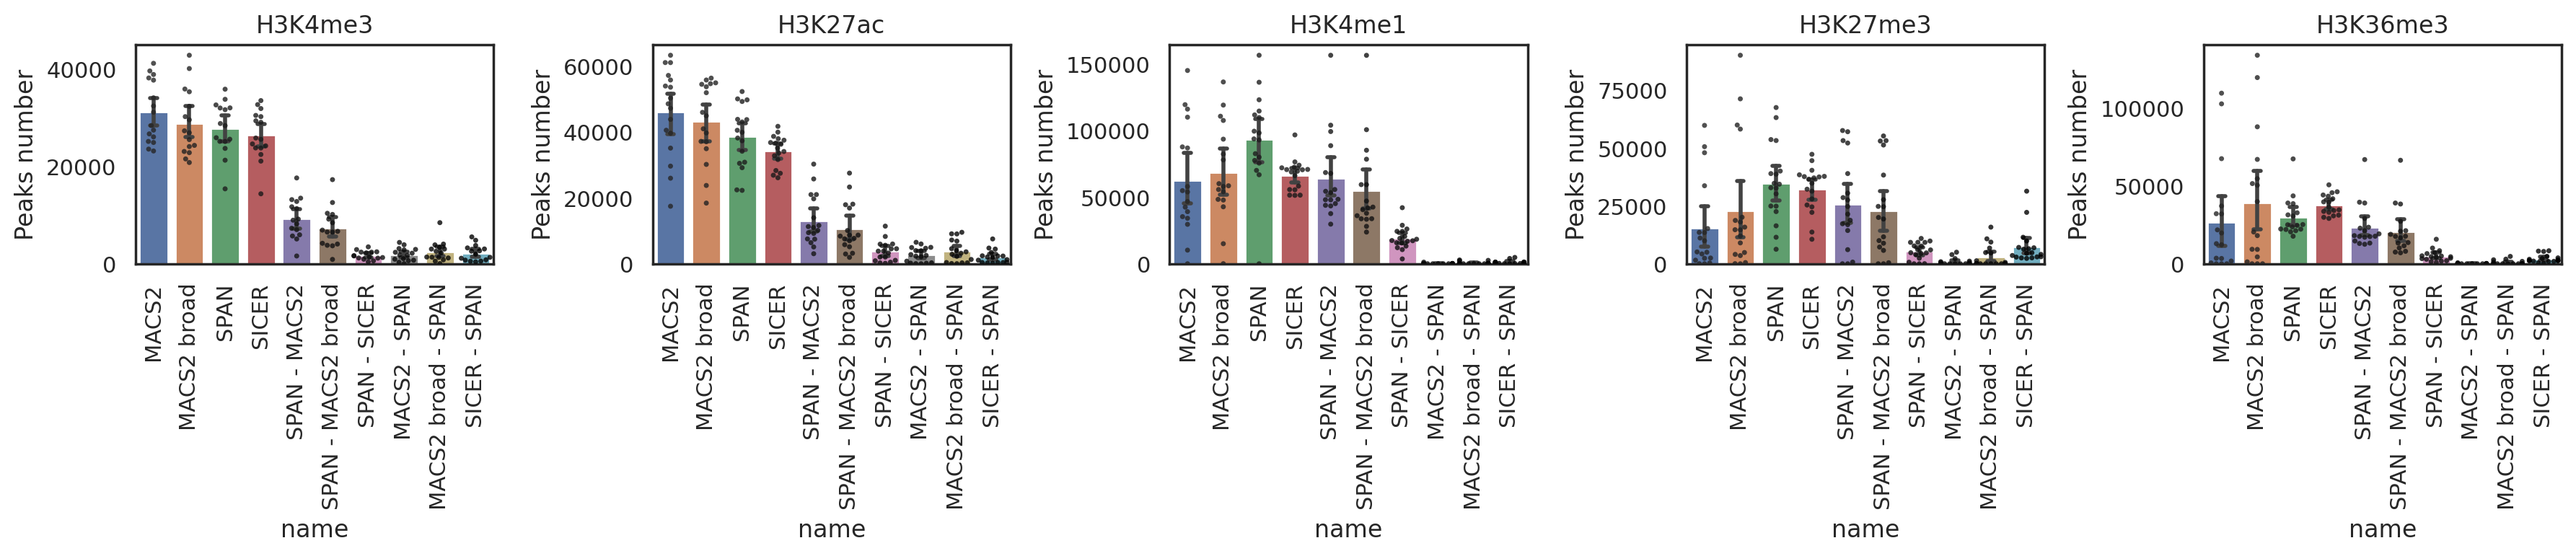

In [42]:
t = df_encode_peaks[['modification', 'cell', 'replicate', 'tool', 'peaks']].copy()
t.rename({'tool': 'name'}, axis=1, inplace=True)
t = pd.concat([t, df_encode_diff]).reset_index(drop=True)
t = t.loc[[(m, c, r) not in OUTLIERS for _, (m, c, r) in t[['modification', 'cell', 'replicate']].iterrows()]].copy()

plt.figure(figsize=(18, 4))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]

for i, m in enumerate(MODIFICATIONS):
    ax = axs[i]
    print(m)
    ax.title.set_text(m)
    sns.barplot(data=t[t['modification'] == m], x='name', y='peaks',
                capsize=.2, errwidth=2,
                order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER',
                       'SPAN - MACS2', 'SPAN - MACS2 broad', 'SPAN - SICER',
                       'MACS2 - SPAN', 'MACS2 broad - SPAN', 'SICER - SPAN',
                       ],
                ax=ax)
    sns.swarmplot(data=t[t['modification'] == m], x='name', y='peaks',
                  size=2.5, alpha=0.8, palette='dark:black',
                  order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER',
                         'SPAN - MACS2', 'SPAN - MACS2 broad', 'SPAN - SICER',
                         'MACS2 - SPAN', 'MACS2 broad - SPAN', 'SICER - SPAN',
                         ],
                  legend=False,
                  ax=ax)
    ax.xaxis.set_tick_params(rotation=90)
    ax.set_ylabel('Peaks number')
plt.tight_layout()
plt.show()

## Roadmap

In [43]:
df_immune_diff = compute_diffs(df_immune_peaks, MODIFICATIONS, IMMUNE_CELLS, IMMUNE_REPS)
df_immune_diff.sample(5)

  0%|          | 0/180 [00:00<?, ?it/s]

H3K4me3 CD4ABT rep1
H3K4me3 CD4ABT rep2
H3K4me3 CD4ABT rep3
H3K4me3 CD4ABT 
H3K4me3 TCellBB rep1
H3K4me3 TCellBB rep2
H3K4me3 TCellBB rep3
H3K4me3 TCellBB 
H3K4me3 BCell rep1
H3K4me3 BCell rep2
H3K4me3 BCell rep3
H3K4me3 BCell 
H3K4me3 TCell rep1
H3K4me3 TCell rep2
H3K4me3 TCell rep3
H3K4me3 TCell 
H3K4me3 Monocyte rep1
H3K4me3 Monocyte rep2
H3K4me3 Monocyte rep3
H3K4me3 Monocyte 
H3K4me3 PBMC rep1
H3K4me3 PBMC rep2
H3K4me3 PBMC rep3
H3K4me3 PBMC 
H3K4me3 NK rep1
H3K4me3 NK rep2
H3K4me3 NK rep3
H3K4me3 NK 
H3K4me3 CD34 rep1
H3K4me3 CD34 rep2
H3K4me3 CD34 rep3
H3K4me3 CD34 
H3K4me3 CD4 rep1
H3K4me3 CD4 rep2
H3K4me3 CD4 rep3
H3K4me3 CD4 
H3K27ac CD4ABT rep1
H3K27ac CD4ABT rep2
H3K27ac CD4ABT rep3
H3K27ac CD4ABT 
H3K27ac TCellBB rep1
H3K27ac TCellBB rep2
H3K27ac TCellBB rep3
H3K27ac TCellBB 
H3K27ac BCell rep1
H3K27ac BCell rep2
H3K27ac BCell rep3
H3K27ac BCell 
H3K27ac TCell rep1
H3K27ac TCell rep2
H3K27ac TCell rep3
H3K27ac TCell 
H3K27ac Monocyte rep1
H3K27ac Monocyte rep2
H3K27ac Mono

modification   cell replicate                name  peaks
263     H3K36me3   CD34                  SICER - SPAN  11657
237     H3K36me3  TCell            MACS2 broad - SPAN  17869
236     H3K36me3  TCell            SPAN - MACS2 broad   1668
151      H3K4me1   CD34      rep2        MACS2 - SPAN   7823
68       H3K4me3    CD4            SPAN - MACS2 broad   7232

In [44]:
t = df_immune_peaks[['modification', 'cell', 'replicate', 'tool', 'peaks']].copy()
t.rename({'tool': 'name'}, axis=1, inplace=True)
t = pd.concat([t, df_immune_diff]).reset_index(drop=True)
t = t.loc[[(m, c, r) not in OUTLIERS for _, (m, c, r) in t[['modification', 'cell', 'replicate']].iterrows()]].copy()

plt.figure(figsize=(18, 4))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]

for i, m in enumerate(MODIFICATIONS):
    print(m)
    ax = axs[i]
    ax.title.set_text(m)
    sns.barplot(data=t[t['modification'] == m], x='name', y='peaks',
                capsize=.2, errwidth=2,
                order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER',
                       'SPAN - MACS2', 'SPAN - MACS2 broad', 'SPAN - SICER',
                       'MACS2 - SPAN', 'MACS2 broad - SPAN', 'SICER - SPAN',
                       ],
                ax=ax)
    sns.swarmplot(data=t[t['modification'] == m], x='name', y='peaks',
                  size=2.5, alpha=0.8, palette='dark:black',
                  order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER',
                         'SPAN - MACS2', 'SPAN - MACS2 broad', 'SPAN - SICER',
                         'MACS2 - SPAN', 'MACS2 broad - SPAN', 'SICER - SPAN',
                         ],
                  legend=False,
                  ax=ax)
    ax.xaxis.set_tick_params(rotation=90)
    ax.set_ylabel('Peaks number')
plt.tight_layout()
plt.show()

H3K4me3


/tmp/ipykernel_691112/2176571632.py:20: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.swarmplot(data=t[t['modification'] == m], x='name', y='peaks',
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 9.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


H3K27ac


/tmp/ipykernel_691112/2176571632.py:20: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.swarmplot(data=t[t['modification'] == m], x='name', y='peaks',


H3K4me1


/tmp/ipykernel_691112/2176571632.py:20: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.swarmplot(data=t[t['modification'] == m], x='name', y='peaks',
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 12.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


H3K27me3


/tmp/ipykernel_691112/2176571632.py:20: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.swarmplot(data=t[t['modification'] == m], x='name', y='peaks',
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 12.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


H3K36me3


/tmp/ipykernel_691112/2176571632.py:20: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.swarmplot(data=t[t['modification'] == m], x='name', y='peaks',
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 12.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 18.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 9.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-pa

In [45]:
t[t['modification'] == 'H3K27me3'].sort_values(by='peaks', ascending=False).head(5)

modification      cell replicate         name   peaks
56     H3K27me3      CD34      rep2  MACS2 broad  105668
5      H3K27me3      CD34      rep2        MACS2   81061
77     H3K27me3      CD34            MACS2 broad   64451
73     H3K27me3  Monocyte            MACS2 broad   63468
13     H3K27me3  Monocyte                  MACS2   57580

# Jaccard & Overlap

In [24]:
import pyranges as pr

def compute_reps_overlap(df_peaks, modifications, cells):
    reps_overlap = pd.DataFrame(columns=['modification', 'cell', 'tool', 'rep1', 'rep2',
                                         'peaks1', 'peaks1_len', 'peaks2', 'peaks2_len',
                                         'peaks1_overlap', 'peaks2_overlap', 'peaks_overlap_len'], dtype=object)

    tools = list(sorted(set(df_peaks['tool'])))
    for m, c in tqdm(list(product(modifications, cells))):
        print(m, c)
        tm = df_peaks[(df_peaks['modification'] == m) & (df_peaks['cell'] == c)]
        reps = list(sorted(set(tm['replicate'])))
        for tool in tools:
            # print(m, tool, len(reps))
            files = [None] * len(reps)
            peaks = [-1] * len(reps)
            peaks_lens = [-1] * len(reps)
            # print('Load')
            for i in range(len(reps)):
                t1 = tm[(tm['tool'] == tool) & (tm['replicate'] == reps[i])]
                if len(t1) == 0:
                    continue
                file = t1['file'].values[0]
                peaks[i] = lines(file)
                if peaks[i] == 0:
                    peaks_lens[i] = 0
                    continue
                files[i] = pr.read_bed(sorted_file(file))
                peaks_lens[i] = files[i].lengths().sum()
            # print('Intersect')
            for i, j in product(range(len(reps)), range(len(reps))):
                if i >= j:
                    continue
                rep1, rep2 = reps[i], reps[j]
                file1, file2 = files[i], files[j]
                peaks1, peaks2 = peaks[i], peaks[j]
                peaks1_len, peaks2_len = peaks_lens[i], peaks_lens[j]
                if peaks1 <= 0 or peaks2 <= 0:
                    reps_overlap.loc[len(reps_overlap)] = \
                        (m, c, tool, rep1, rep2, peaks1, peaks1_len, peaks2, peaks2_len,
                         0, 0, 0)
                    continue
                overlap1 = len(file1.overlap(file2))
                overlap2 = len(file2.overlap(file1))
                overlap_len = file1.intersect(file2).lengths().sum()
                # assert file2.intersect(file1).lengths().sum() == overlap_len
                reps_overlap.loc[len(reps_overlap)] = \
                    (m, c, tool, rep1, rep2, peaks1, peaks1_len, peaks2, peaks2_len,
                     overlap1, overlap2, overlap_len)
    reps_overlap['jaccard'] = [
        d(lo, l1 + l2 - lo)
        for l1, l2, lo in zip(reps_overlap['peaks1_len'], reps_overlap['peaks2_len'], reps_overlap['peaks_overlap_len'])
    ]
    return reps_overlap

## Jaccard ENCODE 

In [25]:
t = df_encode_peaks.loc[[(m, c, r) not in OUTLIERS
                         for _, (m, c, r) in df_encode_peaks[['modification', 'cell', 'replicate']].iterrows()]]
# t = df_encode_peaks
df_encode_reps = compute_reps_overlap(t, MODIFICATIONS, GSE26320_CELLS)
df_encode_reps.sample(5)

  0%|          | 0/45 [00:00<?, ?it/s]

H3K4me3 GM12878
H3K4me3 HMEC
H3K4me3 HSMM
H3K4me3 K562
H3K4me3 NHEK
H3K4me3 NHLF
H3K4me3 H1
H3K4me3 Huvec
H3K4me3 HepG2
H3K27ac GM12878
H3K27ac HMEC
H3K27ac HSMM
H3K27ac K562
H3K27ac NHEK
H3K27ac NHLF
H3K27ac H1
H3K27ac Huvec
H3K27ac HepG2
H3K4me1 GM12878
H3K4me1 HMEC
H3K4me1 HSMM
H3K4me1 K562
H3K4me1 NHEK
H3K4me1 NHLF
H3K4me1 H1
H3K4me1 Huvec
H3K4me1 HepG2
H3K27me3 GM12878
H3K27me3 HMEC
H3K27me3 HSMM
H3K27me3 K562
H3K27me3 NHEK
H3K27me3 NHLF
H3K27me3 H1
H3K27me3 Huvec
H3K27me3 HepG2
H3K36me3 GM12878
H3K36me3 HMEC
H3K36me3 HSMM
H3K36me3 K562
H3K36me3 NHEK
H3K36me3 NHLF
H3K36me3 H1
H3K36me3 Huvec
H3K36me3 HepG2


modification   cell         tool  rep1  rep2  peaks1  peaks1_len  peaks2  \
39       H3K27ac   HSMM         SPAN  rep1  rep2   49851    57437800   50145   
15       H3K4me3   K562         SPAN  rep1  rep2   32602    42191280   28788   
156     H3K36me3  HepG2        MACS2  rep1  rep2   21754     8917886    3561   
54       H3K27ac  Huvec        SICER  rep1  rep2   38747   100624853   34150   
105     H3K27me3   K562  MACS2 broad  rep1  rep2   18090     8758697   18762   

     peaks2_len  peaks1_overlap  peaks2_overlap  peaks_overlap_len   jaccard  
39     59108740           40616           40300           44384770  0.615073  
15     39384490           24076           23936           32102880  0.648898  
156     1707621            1853            1762             610696  0.060979  
54    115050650           30297           29393           78989878  0.577895  
105     5017796            2264            2401             543969  0.041108

In [26]:
print('ENCODE')
plt.figure(figsize=(8, 3))
ax = plt.axes()
sns.boxplot(data=df_encode_reps, x='modification', hue='tool', y='jaccard',
            palette=TOOLS_PALETTE,
            hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
            showfliers=False,
            ax=ax)
sns.swarmplot(data=df_encode_reps, x='modification', hue='tool', y='jaccard',
              dodge=True, size=3, palette='dark:black', alpha=0.8,
              hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
              legend=False,
              ax=ax)
ax.set_title('Jaccard between replicates')
ax.set_ylabel('Jaccard')
ax.set_xlabel('Modification')
sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

ENCODE


H3K4me3
H3K27ac
H3K4me1
H3K27me3
H3K36me3


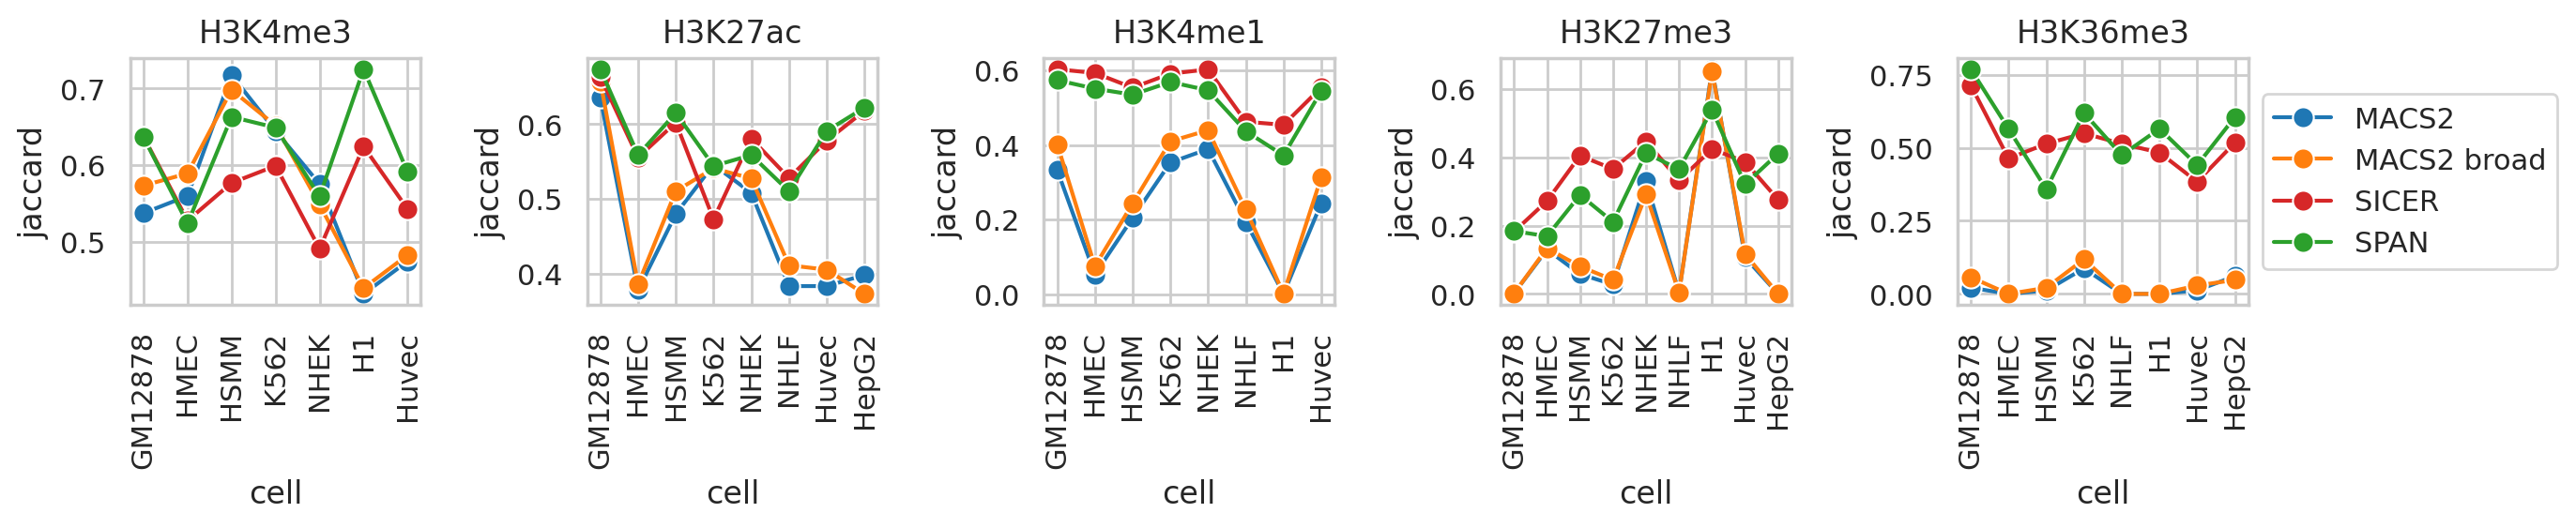

In [27]:
plt.figure(figsize=(14, 3))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, m in enumerate(MODIFICATIONS):
    print(m)
    ax = axs[i]
    g_results = sns.lineplot(data=df_encode_reps[df_encode_reps['modification'] == m],
                             x='cell', y='jaccard', hue='tool',
                             hue_order=['MACS2', 'MACS2 broad', 'SICER', 'SPAN'],
                             palette=TOOLS_PALETTE,
                             errorbar='se', marker='o', markersize=8,
                             ax=ax)
    g_results.axes.title.set_text(f'{m}')
    ax.set_title(m)
    if i != 4:
        ax.legend().set_visible(False)
    else:
        # Put a legend to the right of the current axis
        g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    ax.xaxis.set_tick_params(rotation=90)

plt.tight_layout()
plt.show()

ENCODE


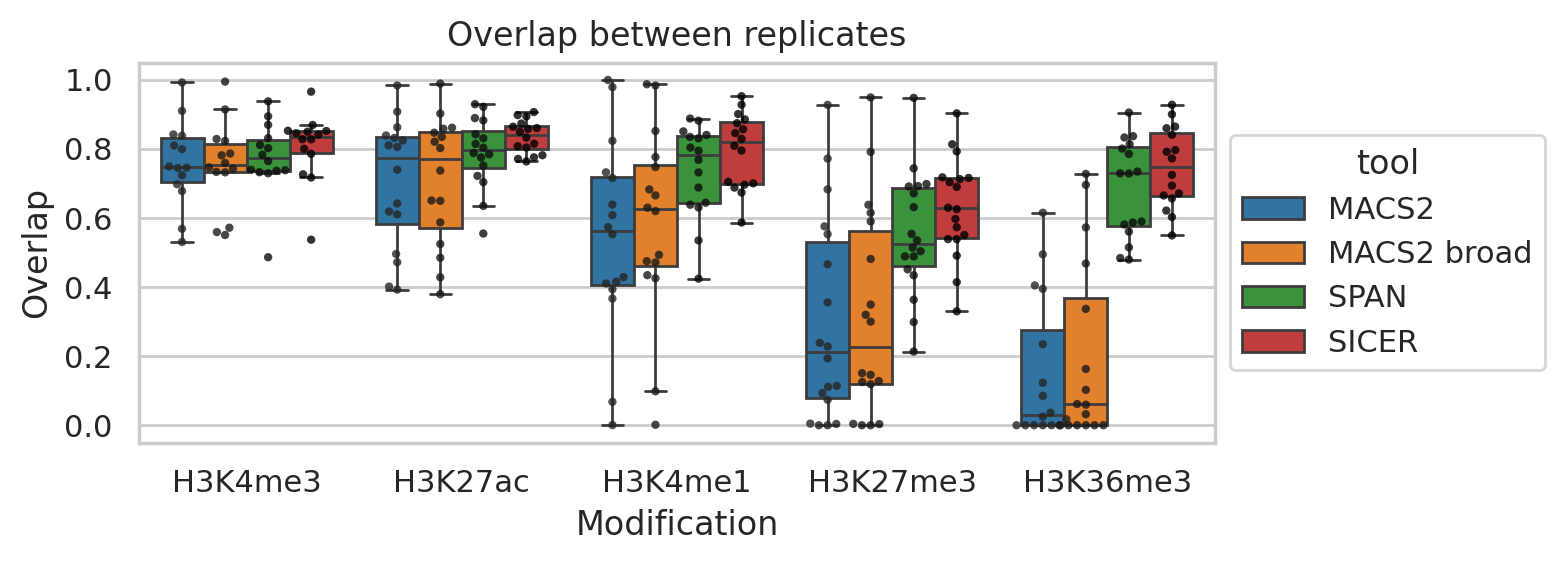

In [28]:
t = pd.concat([df_encode_reps[['modification', 'cell', 'tool']],
               df_encode_reps[['modification', 'cell', 'tool']]]).reset_index(drop=True)
overlaps = [d(o, p) for o, p in zip(df_encode_reps['peaks1_overlap'], df_encode_reps['peaks1'])] + \
           [d(o, p) for o, p in zip(df_encode_reps['peaks2_overlap'], df_encode_reps['peaks2'])]
t['overlap'] = overlaps
print('ENCODE')
plt.figure(figsize=(8, 3))
ax = plt.axes()
sns.boxplot(data=t, x='modification', hue='tool', y='overlap',
            palette=TOOLS_PALETTE,
            hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
            showfliers=False
            )
sns.swarmplot(data=t, x='modification', hue='tool', y='overlap',
              dodge=True, size=3, palette='dark:black', alpha=0.8,
              hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
              legend=False,
              ax=ax)

ax.set_title('Overlap between replicates')
ax.set_ylabel('Overlap')
ax.set_xlabel('Modification')
sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

In [29]:
print('ENCODE')
df_encode_reps['peaks_diff'] = np.fabs((df_encode_reps['peaks1'] - df_encode_reps['peaks2']) /
                                       (df_encode_reps['peaks1'] + df_encode_reps['peaks2']) * 200)
plt.figure(figsize=(14, 3))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, m in enumerate(MODIFICATIONS):
    print(m)
    ax = axs[i]
    g_results = sns.scatterplot(data=df_encode_reps[df_encode_reps['modification'] == m],
                                x='peaks_diff', y='jaccard', hue='tool',
                                hue_order=['MACS2', 'MACS2 broad', 'SICER', 'SPAN'],
                                palette=TOOLS_PALETTE,
                                ax=ax)
    g_results.axes.title.set_text(f'{m}')
    ax.set_title(m)
    if i != 4:
        ax.legend().set_visible(False)
    else:
        # Put a legend to the right of the current axis
        g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

ENCODE
H3K4me3
H3K27ac
H3K4me1
H3K27me3
H3K36me3


ENCODE


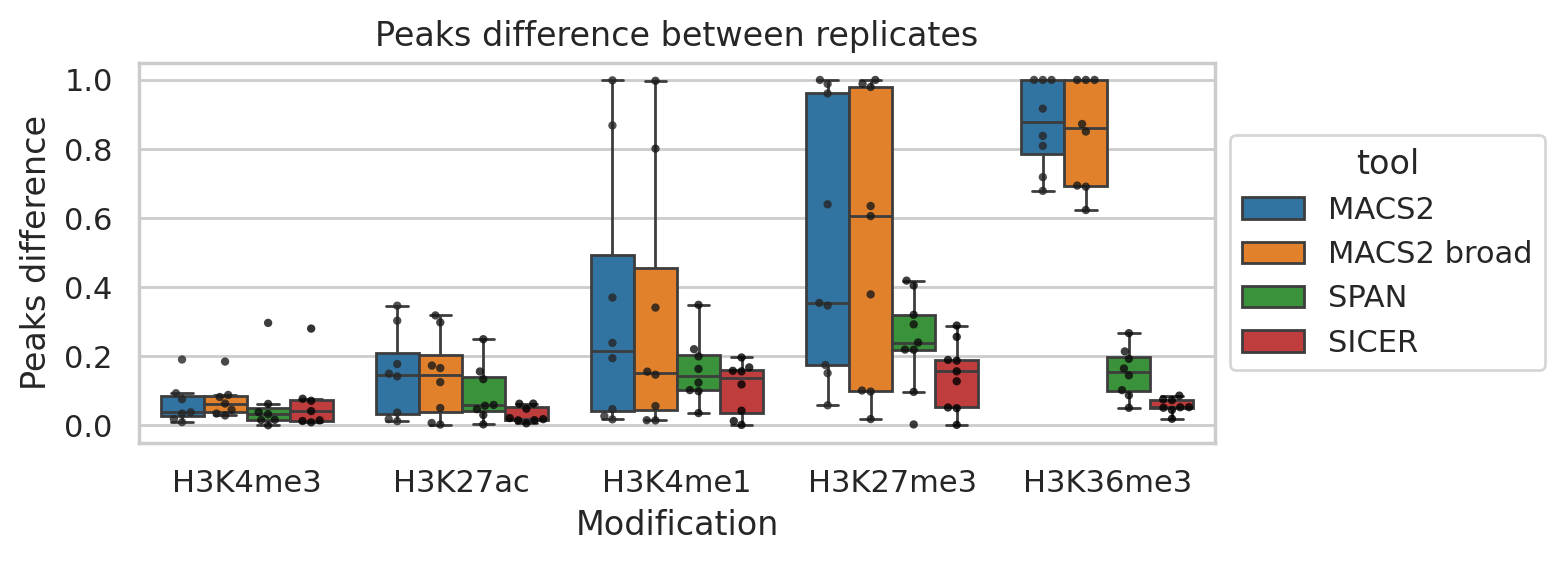

In [30]:
print('ENCODE')
df_encode_reps['reps_peaks_diff'] = np.fabs((df_encode_reps['peaks1'] - df_encode_reps['peaks2']) /
                                            (df_encode_reps['peaks1'] + df_encode_reps['peaks2']))

plt.figure(figsize=(8, 3))
ax = plt.axes()
sns.boxplot(data=df_encode_reps, x='modification', hue='tool', y='reps_peaks_diff',
            palette=TOOLS_PALETTE,
            hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
            showfliers=False,
            ax=ax)
sns.swarmplot(data=df_encode_reps, x='modification', hue='tool', y='reps_peaks_diff',
              dodge=True, size=3, palette='dark:black', alpha=0.8,
              hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'], legend=False,
              ax=ax)
ax.set_title('Peaks difference between replicates')
ax.set_ylabel('Peaks difference')
ax.set_xlabel('Modification')
sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

In [31]:
rows = []
for _, (modification, tool, jaccard, p1, p2, l1, l2) in df_encode_reps[
    ['modification', 'tool', 'jaccard', 'peaks1', 'peaks2', 'peaks1_len', 'peaks2_len']].iterrows():
    rows.append((modification, tool, jaccard, d(l1, p1)))
    rows.append((modification, tool, jaccard, d(l2, p2)))
df_jaccard_avg_len_encode = pd.DataFrame(rows, columns=['modification', 'tool', 'jaccard', 'average_len'])
del rows

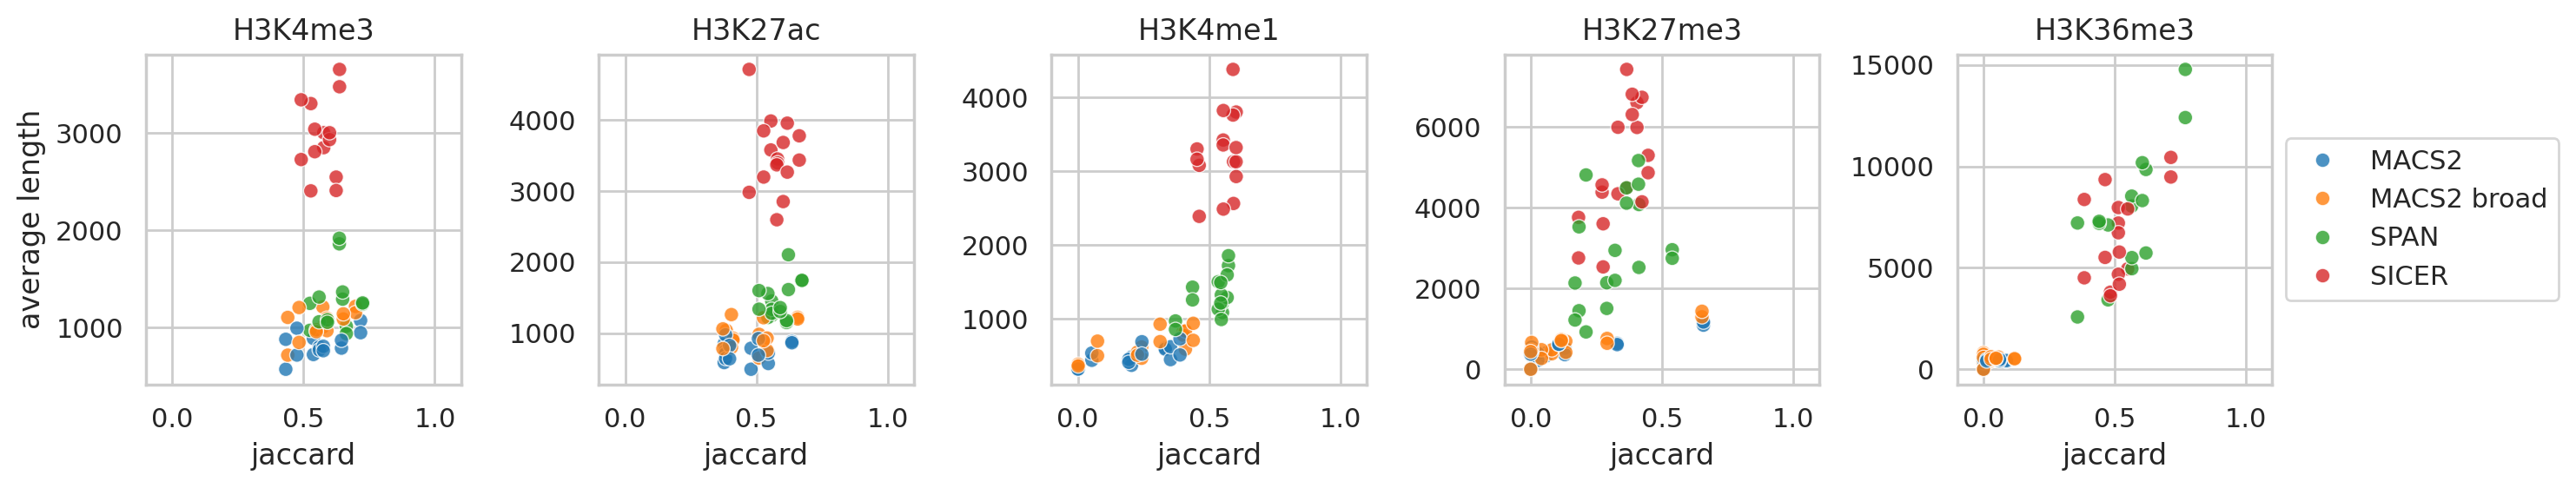

In [32]:
plt.figure(figsize=(15, 3))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, m in enumerate(MODIFICATIONS):
    ax = axs[i]
    sns.scatterplot(
        df_jaccard_avg_len_encode[df_jaccard_avg_len_encode['modification'] == m],
        palette=TOOLS_PALETTE,
        hue_order=TOOLS,
        x='jaccard', y='average_len', hue='tool', alpha=0.8,
        ax=ax,
        # fill=True
    )
    ax.set_title(m)
    ax.set_xlim(-0.1, 1.1)
    ax.set_title(m)
    if i > 0:
        ax.set_ylabel(None)
    else:
        ax.set_ylabel('average length')
    if i < len(axs) - 1:
        ax.legend().set_visible(False)
    else:
        # Put a legend to the right of the current axis
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

H3K27ac


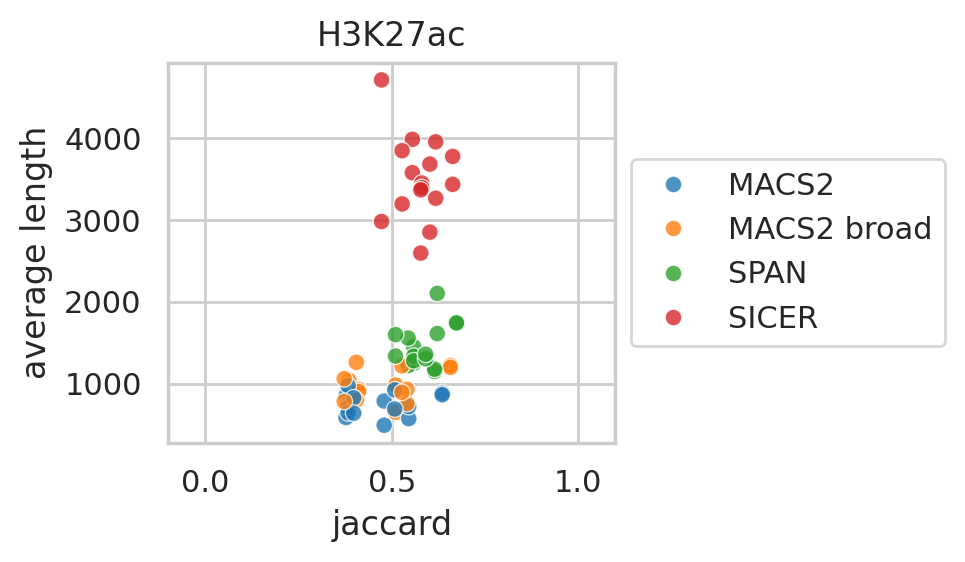

H3K4me1


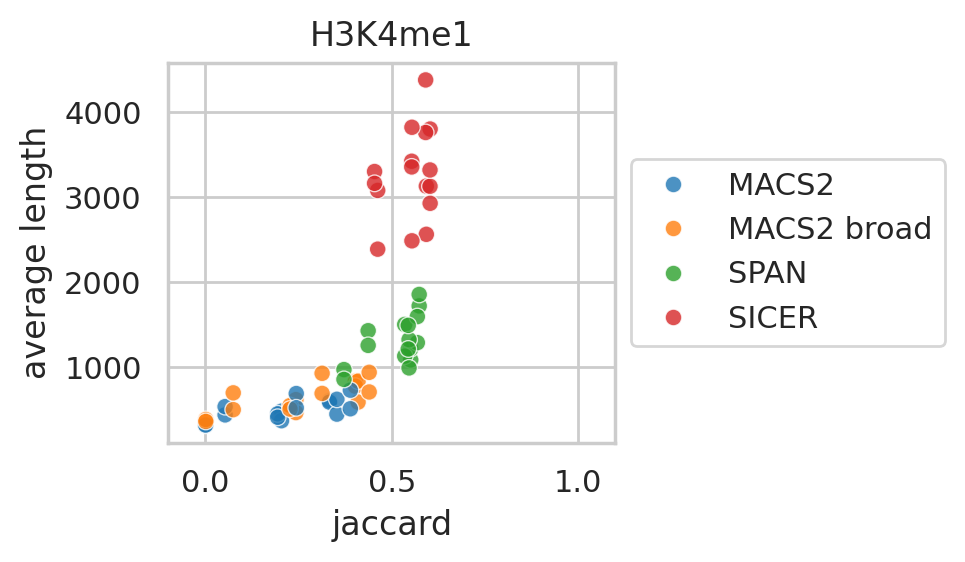

In [33]:
for m in ['H3K27ac', 'H3K4me1']:
    print(m)
    plt.figure(figsize=(5, 3))
    ax = plt.axes()
    sns.scatterplot(
        df_jaccard_avg_len_encode[df_jaccard_avg_len_encode['modification'] == m],
        palette=TOOLS_PALETTE,
        hue_order=TOOLS,
        x='jaccard', y='average_len', hue='tool', alpha=0.8,
        ax=ax,
        # fill=True
    )
    ax.set_title(m)
    ax.set_xlim(-0.1, 1.1)
    ax.set_title(m)
    ax.set_ylabel('average length')
    # Put a legend to the right of the current axis
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    plt.show()

## Jaccard Roadmap

In [34]:
t = df_immune_peaks.loc[[(m, c, r) not in OUTLIERS
                         for _, (m, c, r) in df_immune_peaks[['modification', 'cell', 'replicate']].iterrows()]]
# t = df_immune_peaks
df_immune_reps = compute_reps_overlap(t, MODIFICATIONS, IMMUNE_CELLS)
df_immune_reps.sample(5)

  0%|          | 0/45 [00:00<?, ?it/s]

H3K4me3 CD4ABT
H3K4me3 TCellBB
H3K4me3 BCell
H3K4me3 TCell
H3K4me3 Monocyte
H3K4me3 PBMC
H3K4me3 NK
H3K4me3 CD34
H3K4me3 CD4
H3K27ac CD4ABT
H3K27ac TCellBB
H3K27ac BCell
H3K27ac TCell
H3K27ac Monocyte
H3K27ac PBMC
H3K27ac NK
H3K27ac CD34
H3K27ac CD4
H3K4me1 CD4ABT
H3K4me1 TCellBB
H3K4me1 BCell
H3K4me1 TCell
H3K4me1 Monocyte
H3K4me1 PBMC
H3K4me1 NK
H3K4me1 CD34
H3K4me1 CD4
H3K27me3 CD4ABT
H3K27me3 TCellBB
H3K27me3 BCell
H3K27me3 TCell
H3K27me3 Monocyte
H3K27me3 PBMC
H3K27me3 NK
H3K27me3 CD34
H3K27me3 CD4
H3K36me3 CD4ABT
H3K36me3 TCellBB
H3K36me3 BCell
H3K36me3 TCell
H3K36me3 Monocyte
H3K36me3 PBMC
H3K36me3 NK
H3K36me3 CD34
H3K36me3 CD4


modification     cell         tool  rep1  rep2  peaks1  peaks1_len  peaks2  \
8       H3K4me3     CD34        MACS2        rep2   39952    29326644   27221   
3       H3K4me3   CD4ABT         SPAN  rep1  rep2   19878    24209070   24400   
6       H3K4me3  TCellBB        SICER  rep1  rep2   31721    59642679   29667   
21      H3K4me1     CD34  MACS2 broad        rep2  140715   177299718  136538   
2       H3K4me3   CD4ABT        SICER  rep1  rep2   19145    62402255   23270   

    peaks2_len  peaks1_overlap  peaks2_overlap  peaks_overlap_len   jaccard  
8     24341167           27566           24847           21768624  0.682419  
3     27547970           18562           18467           20813980  0.672654  
6     67583133           24491           23646           45265661  0.552289  
21   142229505          103636          119720          123863727  0.633038  
2     74854330           18546           18433           51456751  0.599730

Immune


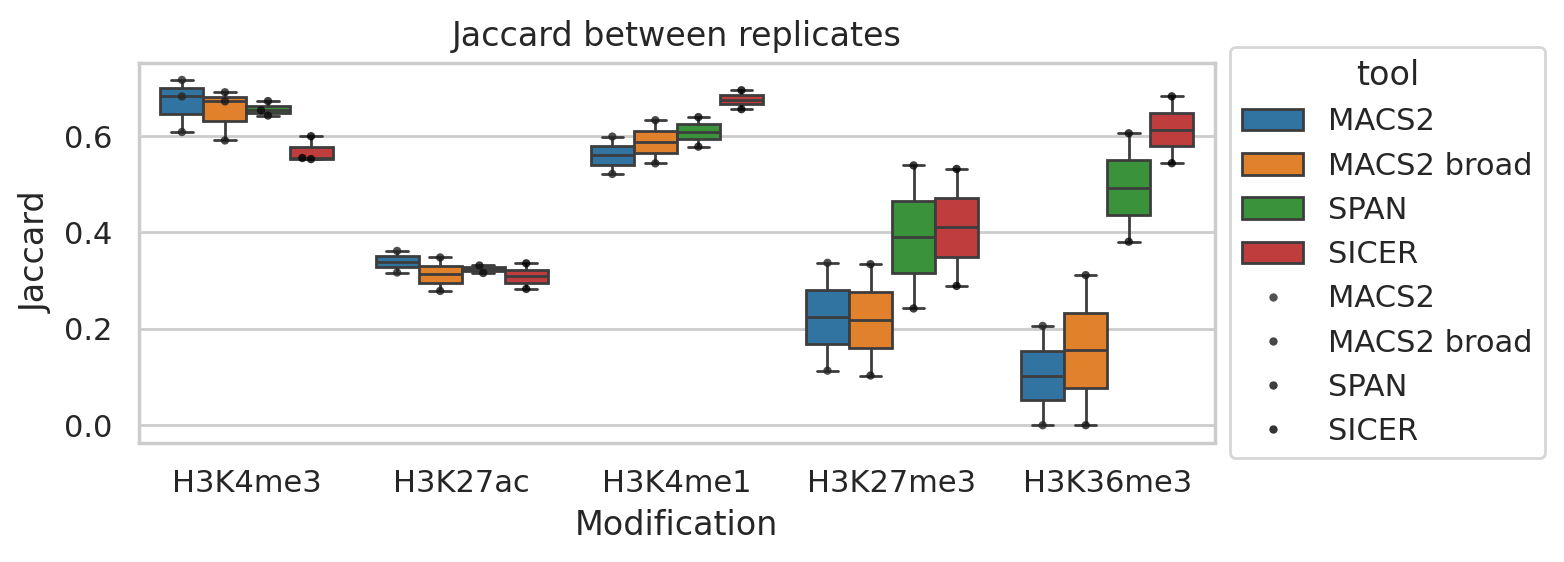

In [35]:
print('Immune')
plt.figure(figsize=(8, 3))
ax = plt.axes()
sns.boxplot(data=df_immune_reps, x='modification', hue='tool', y='jaccard',
            palette=TOOLS_PALETTE,
            hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
            ax=ax)
sns.swarmplot(data=df_immune_reps, x='modification', hue='tool', y='jaccard',
              dodge=True, size=3, palette='dark:black', alpha=0.8,
              hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
              ax=ax)
ax.set_title('Jaccard between replicates')
ax.set_ylabel('Jaccard')
ax.set_xlabel('Modification')
sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

H3K4me3
H3K27ac
H3K4me1
H3K27me3
H3K36me3


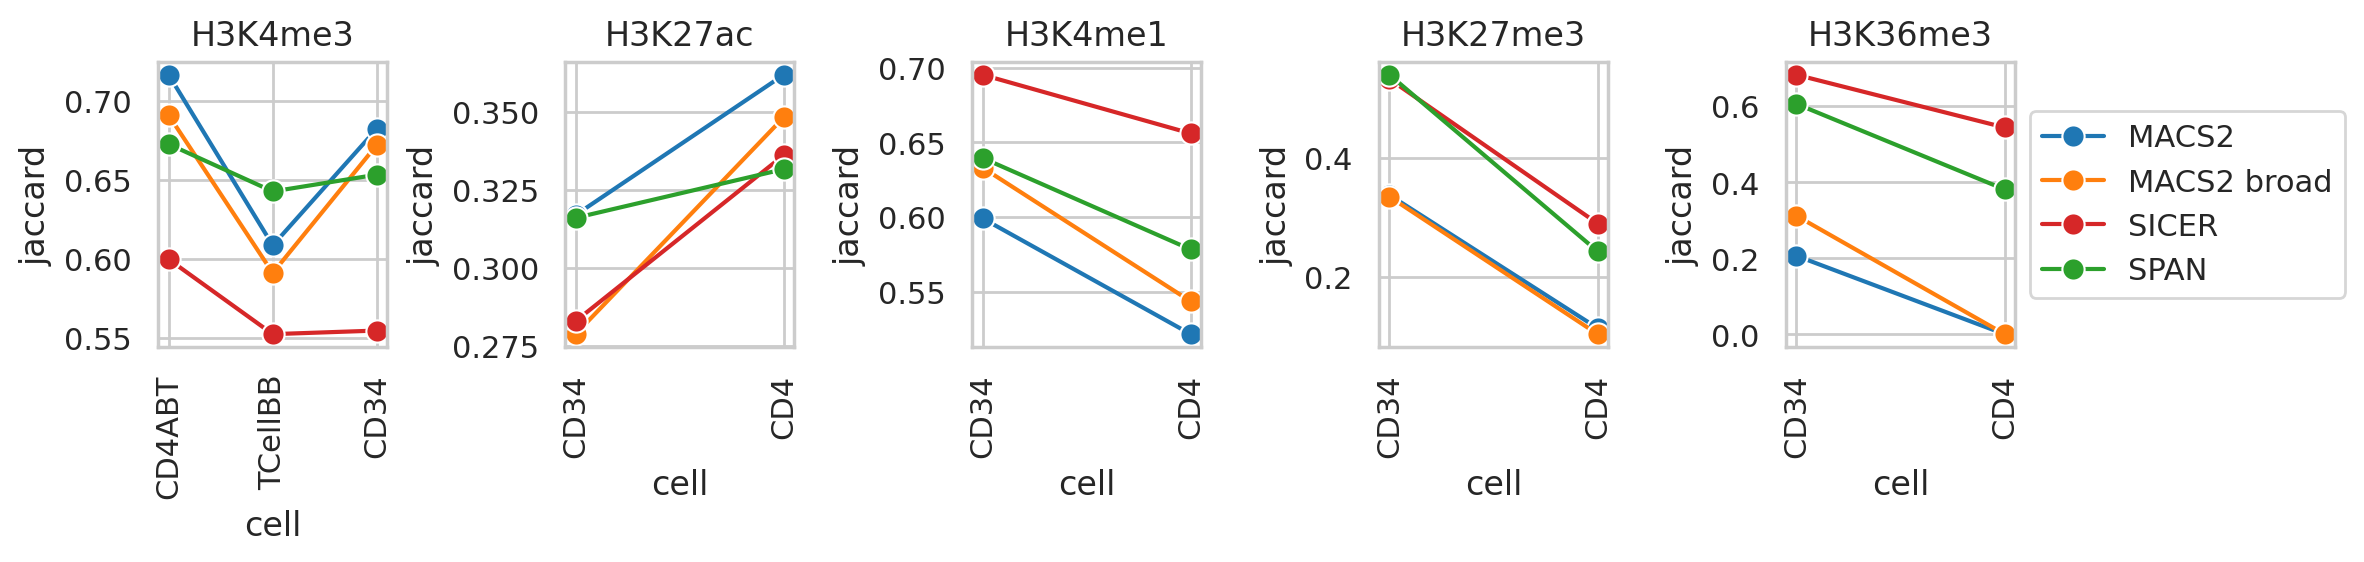

In [36]:
plt.figure(figsize=(12, 3))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, m in enumerate(MODIFICATIONS):
    print(m)
    ax = axs[i]
    g_results = sns.lineplot(data=df_immune_reps[df_immune_reps['modification'] == m],
                             x='cell', y='jaccard', hue='tool',
                             hue_order=['MACS2', 'MACS2 broad', 'SICER', 'SPAN'],
                             palette=TOOLS_PALETTE,
                             errorbar='se', marker='o', markersize=8,
                             ax=ax)
    g_results.axes.title.set_text(f'{m}')
    ax.set_title(m)
    if i != 4:
        ax.legend().set_visible(False)
    else:
        # Put a legend to the right of the current axis
        g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    ax.xaxis.set_tick_params(rotation=90)

plt.tight_layout()
plt.show()

Immune


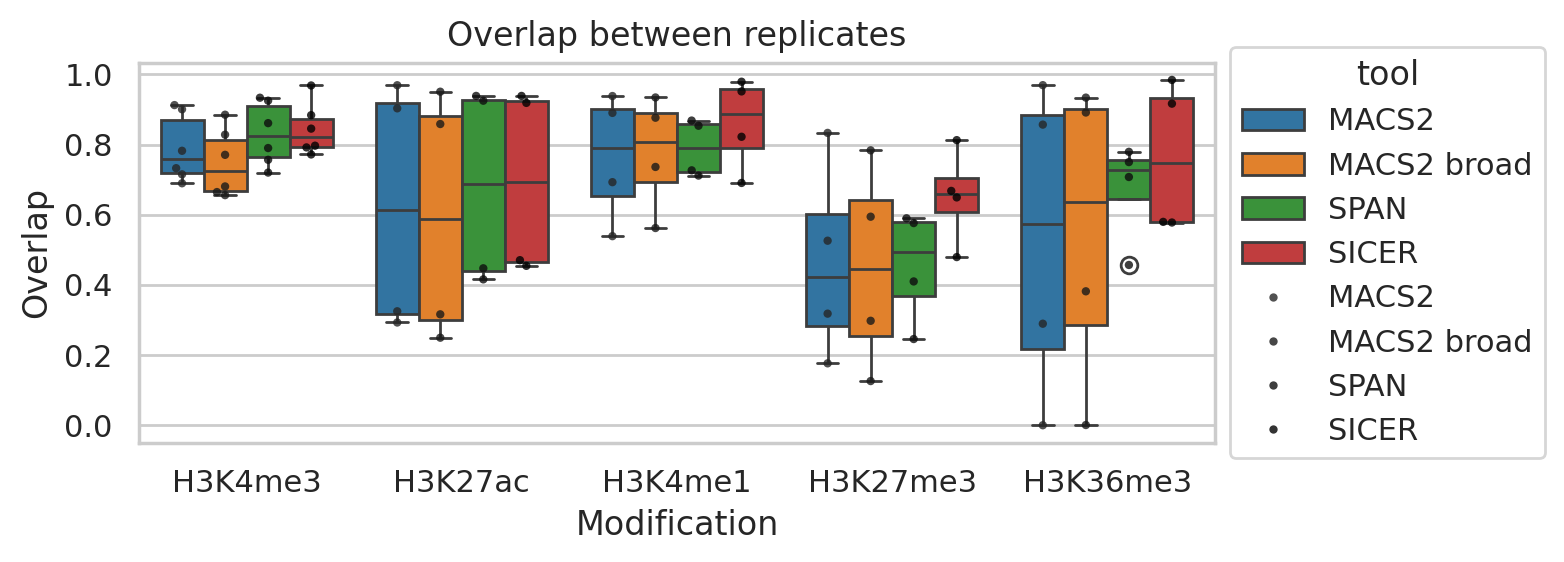

In [37]:
print('Immune')
t = pd.concat([df_immune_reps[['modification', 'cell', 'tool']],
               df_immune_reps[['modification', 'cell', 'tool']]]).reset_index(drop=True)
overlaps = [d(o, p) for o, p in zip(df_immune_reps['peaks1_overlap'], df_immune_reps['peaks1'])] + \
           [d(o, p) for o, p in zip(df_immune_reps['peaks2_overlap'], df_immune_reps['peaks2'])]
t['overlap'] = overlaps
plt.figure(figsize=(8, 3))
ax = plt.axes()
sns.boxplot(data=t, x='modification', hue='tool', y='overlap',
            palette=TOOLS_PALETTE,
            hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
            ax=ax)
sns.swarmplot(data=t, x='modification', hue='tool', y='overlap',
              dodge=True, size=3, palette='dark:black', alpha=0.8,
              hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
              ax=ax)

ax.set_title('Overlap between replicates')
ax.set_ylabel('Overlap')
ax.set_xlabel('Modification')
sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

H3K4me3
H3K27ac
H3K4me1
H3K27me3
H3K36me3


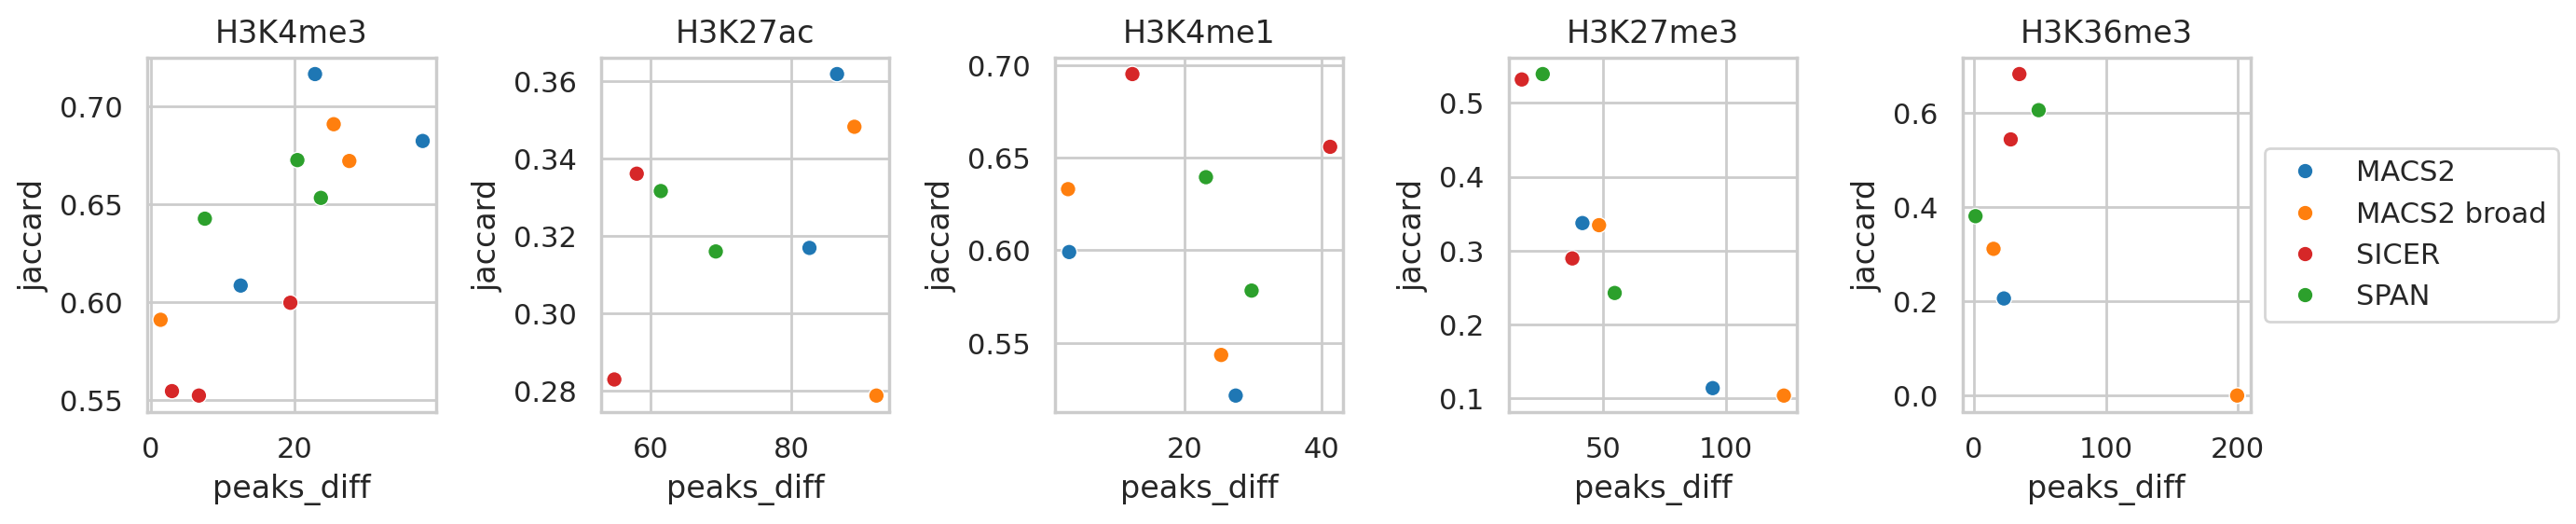

In [38]:
df_immune_reps['peaks_diff'] = np.fabs((df_immune_reps['peaks1'] - df_immune_reps['peaks2']) /
                                       (df_immune_reps['peaks1'] + df_immune_reps['peaks2']) * 200)

plt.figure(figsize=(14, 3))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, m in enumerate(MODIFICATIONS):
    print(m)
    ax = axs[i]
    g_results = sns.scatterplot(data=df_immune_reps[df_immune_reps['modification'] == m],
                                x='peaks_diff', y='jaccard', hue='tool',
                                hue_order=['MACS2', 'MACS2 broad', 'SICER', 'SPAN'],
                                palette=TOOLS_PALETTE,
                                ax=ax)
    g_results.axes.title.set_text(f'{m}')
    ax.set_title(m)
    if i != 4:
        ax.legend().set_visible(False)
    else:
        # Put a legend to the right of the current axis
        g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

In [39]:
sns.set_style('whitegrid')
print('Immune')
df_immune_reps['peaks_diff'] = np.fabs((df_immune_reps['peaks1'] - df_immune_reps['peaks2']) /
                                       (df_immune_reps['peaks1'] + df_immune_reps['peaks2']))

plt.figure(figsize=(6, 3))
ax = plt.axes()
sns.boxplot(data=df_immune_reps, x='modification', hue='tool', y='peaks_diff',
            palette=TOOLS_PALETTE,
            hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
            showfliers=False,
            ax=ax)
sns.swarmplot(data=df_immune_reps, x='modification', hue='tool', y='peaks_diff',
              dodge=True, size=3, palette='dark:black', alpha=0.8,
              hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
              legend=False,
              ax=ax)
ax.set_title('Peaks difference between replicates')
ax.set_ylabel('Peaks difference')
ax.set_xlabel('Modification')
ax.xaxis.set_tick_params(rotation=45)
sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

Immune


In [40]:
rows = []
for _, (modification, tool, jaccard, p1, p2, l1, l2) in df_immune_reps[
    ['modification', 'tool', 'jaccard', 'peaks1', 'peaks2', 'peaks1_len', 'peaks2_len']].iterrows():
    rows.append((modification, tool, jaccard, d(l1, p1)))
    rows.append((modification, tool, jaccard, d(l2, p2)))
df_jaccard_avg_len_immune = pd.DataFrame(rows, columns=['modification', 'tool', 'jaccard', 'average_len'])
del rows

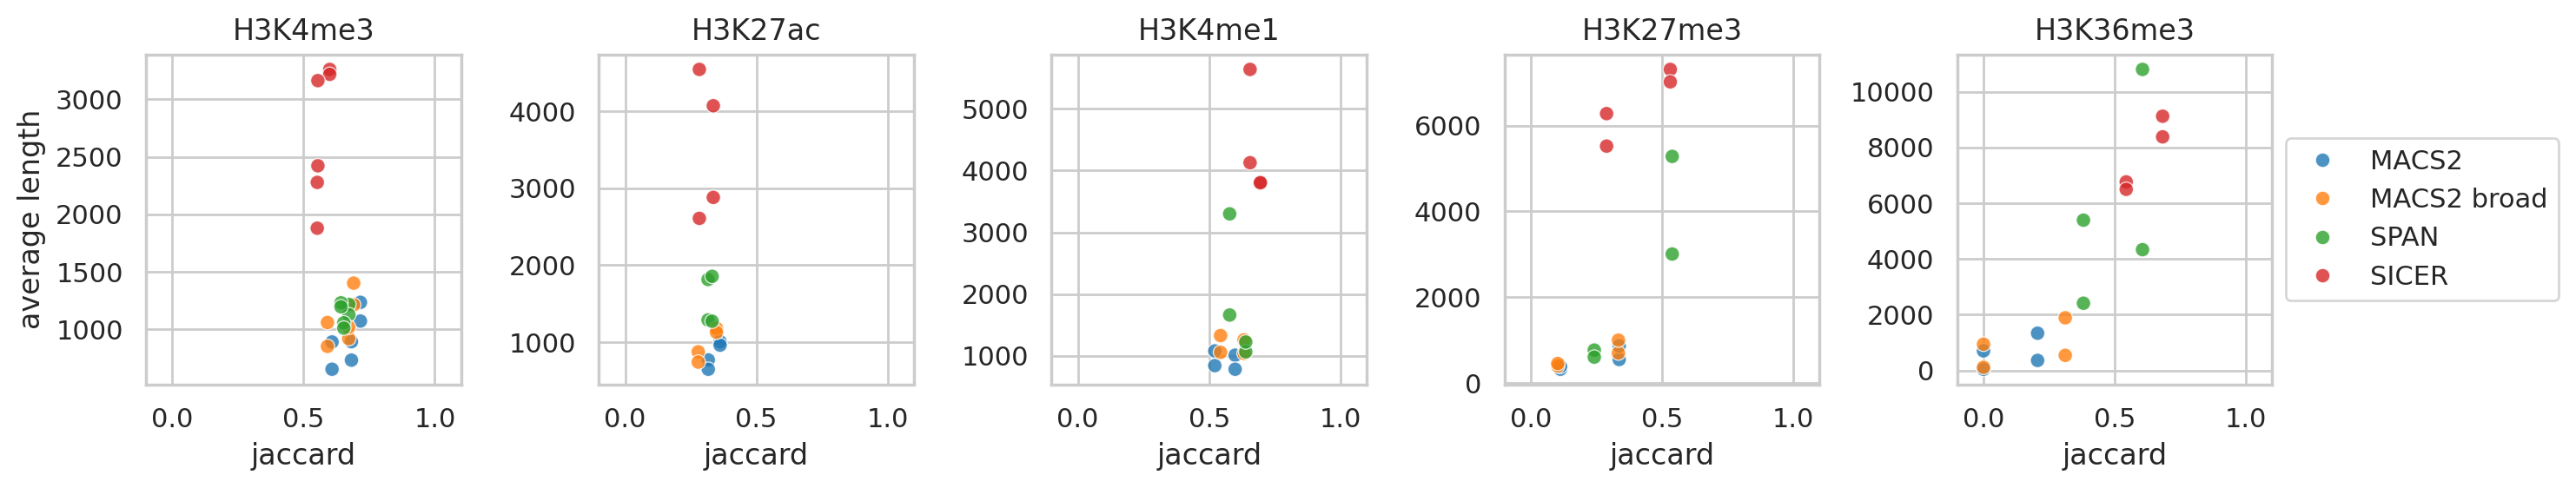

In [41]:
plt.figure(figsize=(15, 3))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, m in enumerate(MODIFICATIONS):
    ax = axs[i]
    sns.scatterplot(
        df_jaccard_avg_len_immune[df_jaccard_avg_len_immune['modification'] == m],
        palette=TOOLS_PALETTE,
        hue_order=TOOLS,
        x='jaccard', y='average_len', hue='tool', alpha=0.8,
        ax=ax,
    )
    ax.set_title(m)
    ax.set_xlim(-0.1, 1.1)
    ax.set_title(m)
    if i > 0:
        ax.set_ylabel(None)
    else:
        ax.set_ylabel('average length')
    if i < len(axs) - 1:
        ax.legend().set_visible(False)
    else:
        #     Put a legend to the right of the current axis
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

ENCODE + Roadmap


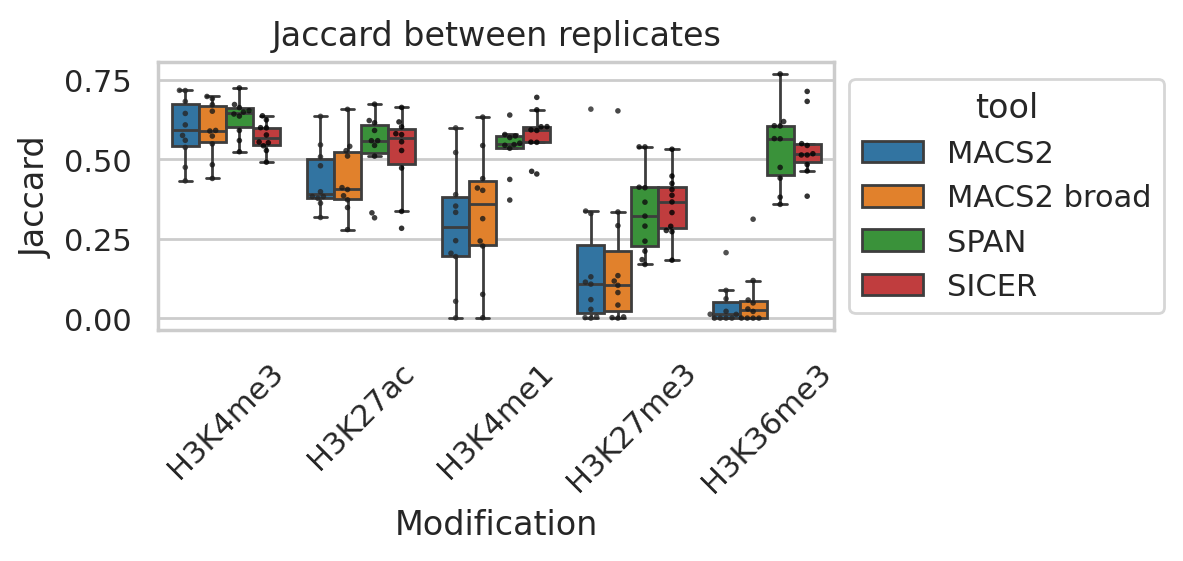

In [42]:
print('ENCODE + Roadmap')
sns.set_style("whitegrid")
t = pd.concat([df_encode_reps, df_immune_reps]).reset_index(drop=True)
plt.figure(figsize=(6, 3))
ax = plt.axes()
sns.boxplot(data=t, x='modification', hue='tool', y='jaccard',
            palette=TOOLS_PALETTE,
            hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
            showfliers=False,
            ax=ax)
sns.swarmplot(data=t, x='modification', hue='tool', y='jaccard',
              dodge=True, size=2, palette='dark:black', alpha=0.8,
              hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
              legend=False,
              ax=ax)
ax.set_title('Jaccard between replicates')
ax.set_ylabel('Jaccard')
ax.set_xlabel('Modification')
ax.xaxis.set_tick_params(rotation=45)
sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

ENCODE + Roadmap


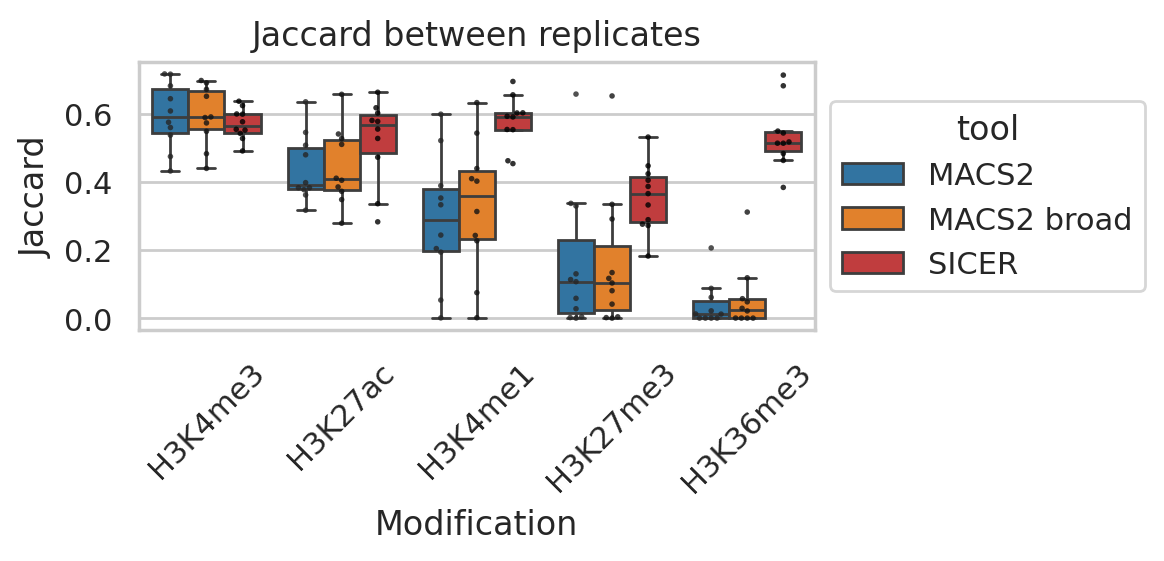

In [43]:
print('ENCODE + Roadmap')
sns.set_style("whitegrid")
t = pd.concat([df_encode_reps, df_immune_reps]).reset_index(drop=True)
plt.figure(figsize=(6, 3))
ax = plt.axes()
sns.boxplot(data=t, x='modification', hue='tool', y='jaccard',
            palette=TOOLS_PALETTE,
            hue_order=['MACS2', 'MACS2 broad', 'SICER'],
            showfliers=False,
            ax=ax)
sns.swarmplot(data=t, x='modification', hue='tool', y='jaccard',
              dodge=True, size=2, palette='dark:black', alpha=0.8,
              hue_order=['MACS2', 'MACS2 broad', 'SICER'],
              legend=False,
              ax=ax)
ax.set_title('Jaccard between replicates')
ax.set_ylabel('Jaccard')
ax.set_xlabel('Modification')
ax.xaxis.set_tick_params(rotation=45)
sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

In [44]:
print('ENCODE + Roadmap')
sns.set_style("white")
# t = df_jaccard_avg_len_encode
df_jaccard_avg_len_encode['dataset'] = 'ENCODE'
df_jaccard_avg_len_immune['dataset'] = 'Roadmap'
t = pd.concat([df_jaccard_avg_len_encode, df_jaccard_avg_len_immune]).reset_index(drop=True)
plt.figure(figsize=(16, 3))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, m in enumerate(MODIFICATIONS):
    ax = axs[i]
    sns.kdeplot(
        t[t['modification'] == m],
        palette=TOOLS_PALETTE,
        hue_order=TOOLS,
        x='jaccard', y='average_len', hue='tool', alpha=0.3,
        common_norm=False, common_grid=False,
        thresh=.05,
        fill=True,
        ax=ax,
    )
    sns.scatterplot(
        t[t['modification'] == m],
        palette=TOOLS_PALETTE,
        hue_order=TOOLS,
        style='dataset',
        x='jaccard', y='average_len', hue='tool', alpha=0.8,
        ax=ax,
    )
    # ax.set_title(m)
    ax.set_xlim(-0.1, 1.1)
    ax.set_title(m)
    if i > 0:
        ax.set_ylabel(None)
    else:
        ax.set_ylabel('average length')
    if i < len(axs) - 1:
        ax.legend().set_visible(False)
    else:
        # Put a legend to the right of the current axis
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

ENCODE + Roadmap


ENCODE + Roadmap


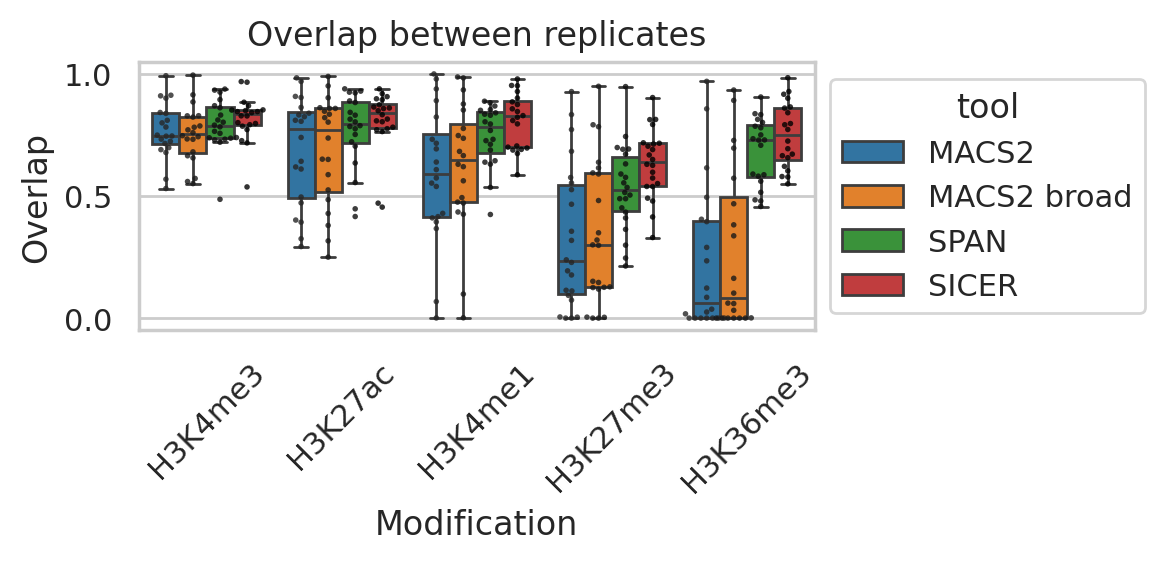

In [45]:
print('ENCODE + Roadmap')
sns.set_style("whitegrid")
t1 = pd.concat([df_immune_reps[['modification', 'cell', 'tool']],
               df_immune_reps[['modification', 'cell', 'tool']]]).reset_index(drop=True)
overlaps1 = [d(o, p) for o, p in zip(df_immune_reps['peaks1_overlap'], df_immune_reps['peaks1'])] + \
           [d(o, p) for o, p in zip(df_immune_reps['peaks2_overlap'], df_immune_reps['peaks2'])]
t1['overlap'] = overlaps1
t1['dataset'] = 'Roadmap'
t2 = pd.concat([df_encode_reps[['modification', 'cell', 'tool']],
               df_encode_reps[['modification', 'cell', 'tool']]]).reset_index(drop=True)
overlaps2 = [d(o, p) for o, p in zip(df_encode_reps['peaks1_overlap'], df_encode_reps['peaks1'])] + \
           [d(o, p) for o, p in zip(df_encode_reps['peaks2_overlap'], df_encode_reps['peaks2'])]
t2['overlap'] = overlaps2
t = pd.concat([t1, t2]).reset_index(drop=True)
plt.figure(figsize=(6, 3))
ax = plt.axes()
sns.boxplot(data=t, x='modification', hue='tool', y='overlap',
            palette=TOOLS_PALETTE,
            hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
            showfliers=False,
            ax=ax)
sns.swarmplot(data=t, x='modification', hue='tool', y='overlap',
              dodge=True, size=2, palette='dark:black', alpha=0.8,
              hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
              legend=False,
              ax=ax)

ax.set_title('Overlap between replicates')
ax.set_ylabel('Overlap')
ax.set_xlabel('Modification')
ax.xaxis.set_tick_params(rotation=45)
sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

# Difference coverage

In [ ]:
import pyBigWig
import tempfile

tf = tempfile.mktemp()

coverage_data = []

all_bws_nc = all_bws[all_bws['modification'] != 'Control']
all_bws_c = all_bws[all_bws['modification'] == 'Control']
for _, (ds, m, c, r, bw_file) in tqdm(
        list(all_bws_nc[['dataset', 'modification', 'cell', 'replicate', 'file']].iterrows())):
    print(ds, m, c, r)
    t = all_bws_c[(all_bws_c['dataset'] == ds) &
                  (all_bws_c['cell'] == c) &
                  (all_bws_c['replicate'] == r)]
    if len(t) == 0:
        continue
    t = all_bws_c[(all_bws_c['dataset'] == ds) &
                  (all_bws_c['cell'] == c)]
    if len(t) == 0:
        continue
    bw_control_file = t['file'].values[0]
    for tool in set(df_peaks['tool']):
        t = df_peaks[(df_peaks['dataset'] == ds) &
                     (df_peaks['modification'] == m) &
                     (df_peaks['cell'] == c) &
                     (df_peaks['replicate'] == r) &
                     (df_peaks['tool'] == tool)]
        if len(t) == 0:
            continue
        peaks_file = sorted_file(t['file'].values[0])
        if lines(peaks_file) > 0:
            t = pd.read_csv(peaks_file, sep='\t', header=None)
            # Speedup computations
            t = t.sample(min(1_000, len(t)))
            positions = [f'{chr}:{start}-{end}' for chr, start, end in zip(t[0], t[1], t[2]) if chr in CHROM_SIZES]
            lengths = [end - start for chr, start, end in zip(t[0], t[1], t[2]) if chr in CHROM_SIZES]

            with pyBigWig.open(bw_file) as bw:
                total_coverage = sum(
                    bw.stats(chr, type='sum', exact=True)[0] for chr in t[0].unique() if chr in CHROM_SIZES)
                peaks_coverage = [bw.stats(chr, start, end, type='sum', exact=True)[0]
                                  for chr, start, end in zip(t[0], t[1], t[2]) if chr in CHROM_SIZES]
            for pos, length, peak_coverage in zip(positions, lengths, peaks_coverage):
                coverage_data.append((ds, m, c, r, tool, pos, length, 'treatment', peak_coverage, total_coverage))

            with pyBigWig.open(bw_control_file) as bwc:
                total_coverage = sum(bwc.stats(chr, type='sum', exact=True)[0] for chr in t[0].unique())
                peaks_coverage = [bwc.stats(chr, start, end, type='sum', exact=True)[0]
                                  for chr, start, end in zip(t[0], t[1], t[2])]
            for pos, length, peak_coverage in zip(positions, lengths, peaks_coverage):
                coverage_data.append((ds, m, c, r, tool, pos, length, 'control', peak_coverage, total_coverage))
        if tool == 'SPAN':
            span_file = peaks_file

    # Processing single tools information
    for tool in TOOLS:
        if tool == 'SPAN':
            continue
        t = df_peaks[(df_peaks['dataset'] == ds) &
                     (df_peaks['modification'] == m) &
                     (df_peaks['cell'] == c) &
                     (df_peaks['replicate'] == r) &
                     (df_peaks['tool'] == tool)]
        if len(t) == 0:
            continue
        peaks_file = sorted_file(t['file'].values[0])
        for name, args in [
            (f'SPAN - {tool}', f' -a {span_file} -b {peaks_file} '),
            (f'{tool} - SPAN', f' -b {span_file} -a {peaks_file} ')
        ]:
            ! bedtools intersect {args} -wa -v > {tf}
            if lines(tf) > 0:
                t = pd.read_csv(tf, sep='\t', header=None)
                # Speedup computations
                t = t.sample(min(1_000, len(t)))
                positions = [f'{chr}:{start}-{end}' for chr, start, end in zip(t[0], t[1], t[2]) if chr in CHROM_SIZES]
                lengths = [end - start for chr, start, end in zip(t[0], t[1], t[2]) if chr in CHROM_SIZES]

                with pyBigWig.open(bw_file) as bw:
                    total_coverage = sum(
                        bw.stats(chr, type='sum', exact=True)[0] for chr in t[0].unique() if chr in CHROM_SIZES)
                    peaks_coverage = [bw.stats(chr, start, end, type='sum', exact=True)[0]
                                      for chr, start, end in zip(t[0], t[1], t[2]) if chr in CHROM_SIZES]
                for pos, length, peak_coverage in zip(positions, lengths, peaks_coverage):
                    coverage_data.append((ds, m, c, r, name, pos, length, 'treatment', peak_coverage, total_coverage))

                with pyBigWig.open(bw_control_file) as bwc:
                    total_coverage = sum(bwc.stats(chr, type='sum', exact=True)[0] for chr in t[0].unique())
                    peaks_coverage = [bwc.stats(chr, start, end, type='sum', exact=True)[0]
                                      for chr, start, end in zip(t[0], t[1], t[2])]
                for pos, length, peak_coverage in zip(positions, lengths, peaks_coverage):
                    coverage_data.append((ds, m, c, r, name, pos, length, 'control', peak_coverage, total_coverage))

df_coverage = pd.DataFrame(
    coverage_data,
    columns=['dataset', 'modification', 'cell', 'replicate', 'name', 'position', 'length', 'type', 'coverage',
             'total_coverage']
)
del coverage_data
df_coverage.sample(5)

In [ ]:
df_coverage['rpm'] = df_coverage['coverage'] / (df_coverage['total_coverage'] / 1e6)
df_coverage['rpkm'] = df_coverage['rpm'] / (df_coverage['length'] / 1e3)

for ds in ['ENCODE', 'Roadmap']:
    for m in MODIFICATIONS:
        plt.figure(figsize=(4.5, 4))
        g_results = sns.boxplot(data=df_coverage[(df_coverage['dataset'] == ds) &
                                                 (df_coverage['modification'] == m)], x='name', y='rpkm', hue='type',
                                order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER',
                                       'SPAN - MACS2', 'SPAN - MACS2 broad', 'SPAN - SICER',
                                       'MACS2 - SPAN', 'MACS2 broad - SPAN', 'SICER - SPAN',
                                       ],
                                showfliers=False)
        ax = g_results.axes
        ax.xaxis.set_tick_params(rotation=90)
        ax.set_ylabel('RPKM')
        # ax.set_ylim(-0.8, 15)
        # Put a legend to the right of the current axis
        ax.legend(loc='center left', bbox_to_anchor=(0.62, 0.82))
        plt.title(f'Peaks coverage {ds} {m}')
        plt.tight_layout()
        # plt.savefig(f'{PATH}/pics/H3K4me1_coverage.pdf', bbox_inches='tight', dpi=300)
        plt.show()

# Signal density

In [ ]:
df_coverage

In [ ]:
for ds in ['ENCODE', 'Roadmap']:
    print(ds)
    t = df_coverage[(df_coverage['dataset'] == ds) & 
                    # (df_coverage['name'].isin(['MACS2', 'MACS2 broad', 'SICER', 'SPAN'])
                    (df_coverage['name'].isin(['SPAN']))
                    ]
    ts = []
    for m, dfm in t.groupby(['modification']):
        ts.append(dfm.sample(min(len(dfm), 5000)))
    t = pd.concat(ts).reset_index(drop=True)
    del ts
    plt.figure(figsize=(6, 4))
    ax = plt.axes()
    t['rpkm'].clip(lower=0.2, inplace=True)
    t['length'].clip(upper=3e5, inplace=True)
    # ticks = [100, 1000, 10_000, 100_000]
    # sns.kdeplot(
    #     t, x='length', y='rpkm',
    #     hue='modification',
    #     alpha=0.8,
    #     hue_order=MODIFICATIONS,
    #     thresh=0.05,
        # fill=True,
        # ax=ax)
    # 
    sns.scatterplot(data=t, x='length', y='rpkm', hue='modification', alpha=0.3,
                    size=0.1,
                    hue_order=MODIFICATIONS,
                    ax=ax)
    ax.set(xscale='log')
    ax.set(yscale='log')
    # ax.set(xticks=ticks)
    # ax.set(xticklabels=ticks)
    # Put a legend to the right of the current axis
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    # plt.savefig(f'{GSE26320_PATH}/pics/peaks_length_vs_rpkm.pdf', bbox_inches='tight', dpi=300)
    plt.show()

In [ ]:
STOP

# IDR

In [ ]:
def compute_reps_idr(df_peaks, modifications, cells):
    reps_idr = pd.DataFrame(columns=['modification', 'cell', 'tool', 'rep1', 'rep2', 'peaks1', 'peaks2',
                                     'idr_loaded_peaks1', 'idr_loaded_peaks2', 'idr_peaks', 'idr_loaded_peaks',
                                     'idr_percentage'
                                     ], dtype=object)

    tf = tempfile.mktemp()
    tf1 = tempfile.mktemp()
    tf2 = tempfile.mktemp()

    tools = list(sorted(set(df_peaks['tool'])))
    for m, c in tqdm(list(product(modifications, cells))):
        print(m, c)
        tm = df_peaks[(df_peaks['modification'] == m) & (df_peaks['cell'] == c)]
        reps = list(sorted(set(tm['replicate'])))
        for tool in tools:
            for i in range(len(reps)):
                for j in range(i + 1, len(reps)):
                    rep1, rep2 = reps[i], reps[j]
                    t1 = tm[(tm['tool'] == tool) & (tm['replicate'] == rep1)]
                    t2 = tm[(tm['tool'] == tool) & (tm['replicate'] == rep2)]
                    if len(t1) == 0 or len(t2) == 0:
                        continue
                    try:
                        file1 = t1['file'].values[0]
                        file2 = t2['file'].values[0]
                        print(tool, file1, file2)
                        peaks1 = t1['peaks'].values[0]
                        peaks2 = t2['peaks'].values[0]
                        # Process SICER peaks, add missing 8th column, as -log10 qvalue
                        if tool == 'SICER':
                            sf1 = pd.read_csv(file1, sep='\t', header=None)
                            sf1[8] = -np.log10(sf1[7])
                            sf1.to_csv(tf1, sep='\t', index=None, header=False)
                            file1 = tf1
                            sf2 = pd.read_csv(file2, sep='\t', header=None)
                            sf2[8] = -np.log10(sf2[7])
                            sf2.to_csv(tf2, sep='\t', index=None, header=False)
                            file2 = tf2
                        ! idr --input-file-type bed --rank 8 --samples {file1} {file2} 2>&1 | tee {tf}
                        with open(tf) as f:
                            idr_out = f.read()
                        # print('IDR OUT', tf, idr_out)
                        lp1, lp2 = re.findall('Number of reported peaks - (\\d+)/(\\d+)', idr_out)[0]
                        lp1, lp2 = int(lp1), int(lp2)
                        ip, ilp, iperc = \
                        re.findall('Number of peaks passing IDR cutoff of 0.05 - (\\d+)/(\\d+) \\(([\\d\\.]+)',
                                   idr_out)[0]
                        ip, ilp, iperc = int(ip), int(ilp), float(iperc)
                        print(m, c, tool, rep1, rep2, peaks1, peaks2, lp1, lp2, ip, ilp, iperc)
                        reps_idr.loc[len(reps_idr)] = \
                            (m, c, tool, rep1, rep2, peaks1, peaks2, lp1, lp2, ip, ilp, iperc)
                    except Exception as e:
                        # raise e
                        # print(e)
                        pass  # Ignore errors for now
    return reps_idr

## IDR ENCODE

In [ ]:
# t = df_encode_peaks.loc[[(m, c, r) not in OUTLIERS for _, (m, c, r) in df_encode_peaks[['modification', 'cell', 'replicate']].iterrows()]]
t = df_encode_peaks
df_encode_idr_reps = compute_reps_idr(t, MODIFICATIONS, GSE26320_CELLS)
df_encode_idr_reps.sample(5)

In [ ]:
print('ENCODE')
plt.figure(figsize=(8, 3))
g_result = sns.boxplot(data=df_encode_idr_reps, x='modification', hue='tool', y='idr_percentage',
                       palette=TOOLS_PALETTE,
                       hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                       )
ax = g_result.axes
ax.set_title('IDR between replicates')
ax.set_ylabel('IDR %')
ax.set_xlabel('Modification')
sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(8, 3))
g_result = sns.boxplot(data=df_encode_idr_reps, x='modification', hue='tool', y='idr_peaks',
                       palette=TOOLS_PALETTE,
                       hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                       )
ax = g_result.axes
ax.set_title('IDR between replicates')
ax.set_ylabel('IDR peaks')
ax.set_xlabel('Modification')
sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(8, 3))
g_result = sns.boxplot(data=df_encode_idr_reps, x='modification', hue='tool', y='idr_loaded_peaks',
                       palette=TOOLS_PALETTE,
                       hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                       )
ax = g_result.axes
ax.set_title('IDR between replicates')
ax.set_ylabel('IDR loaded peaks')
ax.set_xlabel('Modification')
sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

In [ ]:
for m in MODIFICATIONS:
    plt.figure(figsize=(6, 2))
    g_result = sns.boxplot(data=df_encode_idr_reps[df_encode_idr_reps['modification'] == m],
                           x='idr_peaks', y='tool',
                           palette=TOOLS_PALETTE,
                           order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                           )
    ax = g_result.axes
    ax.set_title(f'IDR between {m} replicates')
    ax.set_ylabel('Tool')
    ax.set_xlabel('IDR peaks')
    plt.tight_layout()
    plt.show()

In [ ]:
plt.figure(figsize=(10, 2))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, m in enumerate(MODIFICATIONS):
    ax = axs[i]
    t = df_encode_idr_reps[df_encode_idr_reps['modification'] == m]
    g_results = sns.scatterplot(data=t,
                                x='idr_peaks', y='idr_percentage',
                                hue='tool',
                                palette=TOOLS_PALETTE,
                                alpha=0.8,
                                ax=ax,
                                )
    for x, y, cell in zip(t['idr_peaks'], t['idr_percentage'], t['cell']):
        ax.text(x, y, cell, fontsize=4)
    ax.title.set_text(m)
    if i != 0:
        ax.set_ylabel(None)
    if i != 4:
        ax.legend().set_visible(False)
    else:
        # Put a legend to the right of the current axis
        g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

## IDR Roadmap

In [ ]:
# t = df_immune_peaks.loc[[(m, c, r) not in OUTLIERS for _, (m, c, r) in df_immune_peaks[['modification', 'cell', 'replicate']].iterrows()]]
t = df_immune_peaks
df_immune_idr_reps = compute_reps_idr(t, MODIFICATIONS, IMMUNE_CELLS)
df_immune_idr_reps.sample(5)

In [ ]:
print('Immune')
plt.figure(figsize=(8, 3))
g_result = sns.boxplot(data=df_immune_idr_reps, x='modification', hue='tool', y='idr_percentage',
                       palette=TOOLS_PALETTE,
                       hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                       )
ax = g_result.axes
ax.set_title('IDR between replicates')
ax.set_ylabel('IDR %')
ax.set_xlabel('Modification')
sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

In [ ]:
print('Immune')
plt.figure(figsize=(8, 3))
g_result = sns.boxplot(data=df_immune_idr_reps, x='modification', hue='tool', y='idr_peaks',
                       palette=TOOLS_PALETTE,
                       hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                       )
ax = g_result.axes
ax.set_title('IDR between replicates')
ax.set_ylabel('IDR peaks')
ax.set_xlabel('Modification')
sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(8, 3))
g_result = sns.boxplot(data=df_immune_idr_reps, x='modification', hue='tool', y='idr_loaded_peaks',
                       palette=TOOLS_PALETTE,
                       hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                       )
ax = g_result.axes
ax.set_title('IDR between replicates')
ax.set_ylabel('IDR loaded peaks')
ax.set_xlabel('Modification')
sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

In [ ]:
for m in MODIFICATIONS:
    plt.figure(figsize=(6, 2))
    g_result = sns.boxplot(data=df_immune_idr_reps[df_immune_idr_reps['modification'] == m],
                           x='idr_peaks', y='tool',
                           palette=TOOLS_PALETTE,
                           order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                           )
    ax = g_result.axes
    ax.set_title(f'IDR between {m} replicates')
    ax.set_ylabel('Tool')
    ax.set_xlabel('IDR peaks')
    plt.tight_layout()
    plt.show()

In [ ]:
plt.figure(figsize=(10, 2))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, m in enumerate(MODIFICATIONS):
    ax = axs[i]
    t = df_immune_idr_reps[df_immune_idr_reps['modification'] == m]
    g_results = sns.scatterplot(data=t,
                                x='idr_peaks', y='idr_percentage',
                                hue='tool',
                                palette=TOOLS_PALETTE,
                                alpha=0.8,
                                ax=ax,
                                )
    for x, y, cell in zip(t['idr_peaks'], t['idr_percentage'], t['cell']):
        ax.text(x, y, cell, fontsize=4)
    ax.title.set_text(m)
    if i != 0:
        ax.set_ylabel(None)
    if i != 4:
        ax.legend().set_visible(False)
    else:
        # Put a legend to the right of the current axis
        g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()